#                  Segmentation des clients du site E-Commerce Olist



# Sommaire

1. Clustering avec l'algorithme du K-Means
2. Réduction dimensionnelle - PCA
3. K-Means après réduction de dimenssions
4. Clustering par hierarchie
5. Clustering avec DBSCAN 


In [18]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
!pip install squarify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
!pip install yellowbrick

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
#Librairies import
from time import time
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import plotly.express as px
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import homogeneity_score, adjusted_rand_score, adjusted_mutual_info_score, silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import normalize
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
from transformers import pipeline
from scipy import stats
from scipy.cluster.hierarchy import linkage,dendrogram

# Clustering Librairies import
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance


import squarify
import datetime

mpl.rcParams["figure.figsize"] = (12, 8)


In [22]:
def rfm_clusters_stat(data):
     """
  Nous permet de trouver les stats selon RFM

  Prametres:

  --------

  data -- dataframe

     """
     data_new = data.groupby(['Cluster']).agg({
            'Recency'  : ['mean','median', 'min', 'max'],
            'Frequency': ['mean','median', 'min', 'max'],
            'Monetary' : ['mean','median', 'min', 'max', 'count']
        }).round(0)

     return data_new

In [23]:
rfm_clusters_stat.__doc__

'\n  Nous permet de trouver les stats selon RFM\n\n  Prametres:\n\n  --------\n\n  data -- dataframe\n\n     '

In [24]:
#pour afficher la matrice de correlation
def corr(data): 
  """
  afficher une matrice de correlation:

  parametres:
  -------

  df -- dataframe

  """

  plt.figure(figsize = (12,10))
  sns.heatmap(data.corr(), annot=True)
  return 
  plt.show()

In [25]:
def clustering_eval(preprocessor, model, data, metric, elbow=True, mds=False, 
                    KBest=None):
    """
              clustering eval va nous permettre d'evaluer nos cluster selon  le
               coude, nous calculons le Kmeans_visualizer , ensuite nous 
               afficherons le Kbest , nous canlculerons le silouhete visualizer
                et nous finirons par afficher la distance entre les clusters

  parametres: 

  preprocessor -- preprocessor (minmaxscaler())
  model -- Kmeans()
  data -- dataframe 
  metric -- any 
  elbow -- Bool
  mds -- Bool
  Kbest -- int (None)
 
      
    """


    
    if((elbow==True) & (mds==True)):
        ncols = 3
    elif((elbow==False) | (mds==False)):
        ncols = 2
    else:
        ncols = 1
        
    fig, axes = plt.subplots(nrows=1, ncols=ncols, sharex=False, sharey=False, figsize=(24,8))
    
    ax=0
    if(elbow==True):
        # Elbow visualizer
        kmeans_visualizer = Pipeline([
            ("preprocessor", preprocessor),
            ("kelbowvisualizer", KElbowVisualizer(model,K=(4,12), metric=metric, ax=axes[ax]))])
        kmeans_visualizer.fit(data)
        KBest = kmeans_visualizer.named_steps['kelbowvisualizer'].elbow_value_
        kmeans_visualizer.named_steps['kelbowvisualizer'].finalize()
        ax+=1
    
    # Set best K
    K = KBest
    model.set_params(n_clusters=K)

    # Silhouette Visualizer
    silhouette_visualizer = Pipeline([
        ("preprocessor", preprocessor),
        ("silhouettevisualizer", SilhouetteVisualizer(model, ax=axes[ax]))])
    silhouette_visualizer.fit(data)
    silhouette_visualizer.named_steps['silhouettevisualizer'].finalize()
    ax+=1
    
    # Intercluster distance Map with best k
    if(mds==True):
        distance_visualizer = Pipeline([
            ("preprocessor", preprocessor),
            ("distancevisualizer", InterclusterDistance(model, ax=axes[ax]))])
        distance_visualizer.fit(data)
        distance_visualizer.named_steps['distancevisualizer'].finalize()
    
    return K
    plt.show()

In [26]:
pd.set_option('display.max_columns',1000)  #display max columns

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Comment allons nous proceder?

Dans un premier temps notre etude va porter sur le Concept marketing pour les sites e-commerce a savoir RFM.
Nous allors faire nos tests sur ce dataframe créé avec les nouvelles features Recency, frequency et monetary.

Une fois modele choisi, nous allons rajouter a chaque fois une feature et voir le changement sur nos silhouettes et clusters.

Une fois features rajoutées, une bonne distribution de silhouette avec notre modele nous avons notre segmentation finale.

# RFM

---



In [28]:
# Upload dataset
data = pd.read_csv('/content/drive/MyDrive/OC: Data Science/Datasets/Projet 5/data1.csv')
data.head(6)

order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   
5  00048cc3ae777c65dbb7d2a0634bc1ea              1   

                         product_id   price  freight_value  \
0  4244733e06e7ecb4970a6e2683c13e61   58.90          13.29   
1  e5f2d52b802189ee658865ca93d83a8f  239.90          19.93   
2  c777355d18b72b67abbeef9df44fd0fd  199.00          17.87   
3  7634da152a4610f1595efa32f14722fc   12.99          12.79   
4  ac6c3623068f30de03045865e4e10089  199.90          18.14   
5  ef92defde845ab8450f9d70c526ef70f   21.90          12.69   

                        customer_id order_status order_purchase_timestamp  \
0  3ce436f183e68e07877b285a838db11a    delivered      2017-09-13 08:59:02   
1  f6dd3ec061db4e3987629fe6b26e5cce    delivered      2017-04-26 10:53:06   
2  6489ae5e4333f3693df5ad4372dab6d3    delivered      2018-01-14 14:33:31   
3  d4eb9395c8c0431ee92fce09860c5a06    delivered      2018-08-08 10:00:35   
4  58dbd0b2d70206bf40e62cd34e84d795    delivered      2017-02-04 13:57:51   
5  816cbea969fe5b689b39cfc97a506742    delivered      2017-05-15 21:42:34   

  order_delivered_customer_date  sale_month  nb_payment_sequential  \
0           2017-09-20 23:43:48           9                    1.0   
1           2017-05-12 16:04:24           4                    1.0   
2           2018-01-22 13:19:16           1                    1.0   
3           2018-08-14 13:32:39           8                    1.0   
4           2017-03-01 16:42:31           2                    1.0   
5           2017-05-22 13:44:35           5                    1.0   

   sum_payment_installments  is_reviewed  review_score  \
0                       2.0         True           5.0   
1                       3.0         True           4.0   
2                       5.0         True           5.0   
3                       2.0         True           4.0   
4                       3.0         True           5.0   
5                       1.0         True           4.0   

                 customer_unique_id  customer_zip_code_prefix  \
0  871766c5855e863f6eccc05f988b23cb                     28013   
1  eb28e67c4c0b83846050ddfb8a35d051                     15775   
2  3818d81c6709e39d06b2738a8d3a2474                     35661   
3  af861d436cfc08b2c2ddefd0ba074622                     12952   
4  64b576fb70d441e8f1b2d7d446e483c5                     13226   
5  85c835d128beae5b4ce8602c491bf385                     38017   

           customer_city customer_state  product_name_lenght  \
0  campos dos goytacazes             RJ                 58.0   
1        santa fe do sul             SP                 56.0   
2          para de minas             MG                 59.0   
3                atibaia             SP                 42.0   
4        varzea paulista             SP                 59.0   
5                uberaba             MG                 36.0   

   product_description_lenght  product_photos_qty product_category_name  
0                       598.0                 4.0            cool_stuff  
1                       239.0                 2.0              pet_shop  
2                       695.0                 2.0       furniture_decor  
3                       480.0                 1.0             perfumery  
4                       409.0                 1.0          garden_tools  
5                       558.0                 1.0            housewares

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110197 entries, 0 to 110196
Data columns (total 22 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       110197 non-null  object 
 1   order_item_id                  110197 non-null  int64  
 2   product_id                     110197 non-null  object 
 3   price                          110197 non-null  float64
 4   freight_value                  110197 non-null  float64
 5   customer_id                    110197 non-null  object 
 6   order_status                   110197 non-null  object 
 7   order_purchase_timestamp       110197 non-null  object 
 8   order_delivered_customer_date  110189 non-null  object 
 9   sale_month                     110197 non-null  int64  
 10  nb_payment_sequential          110194 non-null  float64
 11  sum_payment_installments       110194 non-null  float64
 12  is_reviewed                   

Nous avons 21 colonnes, mais nous avons des colonnes qui representent le temps on va les transformer au bon format.

In [30]:
data.describe()

order_item_id          price  freight_value     sale_month  \
count  110197.000000  110197.000000  110197.000000  110197.000000   
mean        1.198181     119.980563      19.948598       6.031634   
std         0.706676     182.299446      15.698136       3.230682   
min         1.000000       0.850000       0.000000       1.000000   
25%         1.000000      39.900000      13.080000       3.000000   
50%         1.000000      74.900000      16.260000       6.000000   
75%         1.000000     134.170000      21.150000       8.000000   
max        21.000000    6735.000000     409.680000      12.000000   

       nb_payment_sequential  sum_payment_installments   review_score  \
count          110194.000000             110194.000000  109370.000000   
mean                1.043932                  3.065720       4.082044   
std                 0.376623                  2.828219       1.345880   
min                 1.000000                  0.000000       1.000000   
25%                 1.000000                  1.000000       4.000000   
50%                 1.000000                  2.000000       5.000000   
75%                 1.000000                  4.000000       5.000000   
max                26.000000                 26.000000       5.000000   

       customer_zip_code_prefix  product_name_lenght  \
count             110197.000000        108660.000000   
mean               35155.346888            48.808559   
std                29901.148745            10.008243   
min                 1003.000000             5.000000   
25%                11310.000000            42.000000   
50%                24344.000000            52.000000   
75%                59066.000000            57.000000   
max                99980.000000            76.000000   

       product_description_lenght  product_photos_qty  
count               108660.000000       108660.000000  
mean                   787.343788            2.210712  
std                    651.321001            1.721751  
min                      4.000000            1.000000  
25%                    348.000000            1.000000  
50%                    603.000000            1.000000  
75%                    987.000000            3.000000  
max                   3992.000000           20.000000

In [31]:
data.shape

(110197, 22)

In [32]:
data['order_purchase_timestamp'] = pd.to_datetime(data['order_purchase_timestamp'] , errors='coerce')
data['order_delivered_customer_date'] = pd.to_datetime(data['order_delivered_customer_date'] , errors='coerce')

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110197 entries, 0 to 110196
Data columns (total 22 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       110197 non-null  object        
 1   order_item_id                  110197 non-null  int64         
 2   product_id                     110197 non-null  object        
 3   price                          110197 non-null  float64       
 4   freight_value                  110197 non-null  float64       
 5   customer_id                    110197 non-null  object        
 6   order_status                   110197 non-null  object        
 7   order_purchase_timestamp       110197 non-null  datetime64[ns]
 8   order_delivered_customer_date  110189 non-null  datetime64[ns]
 9   sale_month                     110197 non-null  int64         
 10  nb_payment_sequential          110194 non-null  float64       
 11  

In [34]:
max_date = max(data['order_purchase_timestamp']) + datetime.timedelta(days=1)
max_date

Timestamp('2018-08-30 15:00:37')

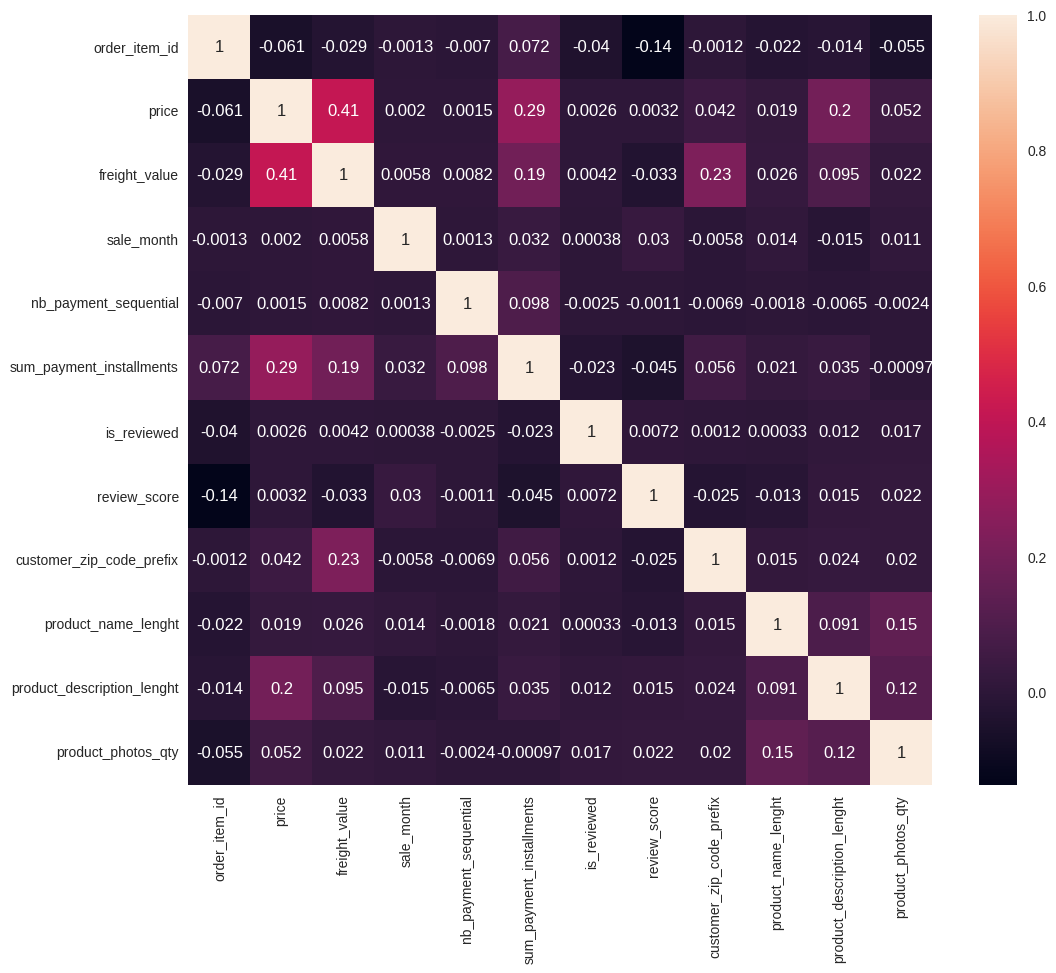

In [35]:
corr(data)

Nous remarquons que nous n'avons pas de correlation entre nos differe,tes features.

# **ETUDE RFM**

En marketing RFM represente : 



*   R: Recency : ce qui represente la recnse des achats
*   F: Frequency : Frequence des achats
*   M!: Monetary : cela peut representer la somme totale des achats ou le panier moyen (pour notre etude nous optons pour la somme)




Pour notre etude, nous avons deux id clients: 


*   Customer ID : identification du client par transaction (nous pouvons avoir pour le meme client plusieurs customer id)
*   Customer unique ID : identification unique du client (qq soit l'achat, nous avons un seul et unique customeruniuqeid)

Nous nous basons pour nos calcul sur **customer_unique_id**

In [36]:
#Grouping the data by Customer Unique ID to find the latest order of each customer:
recency_df = data.groupby(by = 'customer_unique_id', as_index = False)['order_purchase_timestamp'].max()

#Renaming the column:
recency_df.rename(columns = {"order_purchase_timestamp": "LastPurchaseDate"}, inplace = True)

#Removing time and extracting only date from the datetime field:
recency_df["LastPurchaseDate"] = recency_df["LastPurchaseDate"].dt.date

#Using the last order in the entire dataset as a reference point to calculate recency:
recent_date = data['order_purchase_timestamp'].dt.date.max()
recency_df['Recency'] = recency_df['LastPurchaseDate'].apply(lambda x: (recent_date - x).days)

recency_df.head()

customer_unique_id LastPurchaseDate  Recency
0  0000366f3b9a7992bf8c76cfdf3221e2       2018-05-10      111
1  0000b849f77a49e4a4ce2b2a4ca5be3f       2018-05-07      114
2  0000f46a3911fa3c0805444483337064       2017-03-10      537
3  0000f6ccb0745a6a4b88665a16c9f078       2017-10-12      321
4  0004aac84e0df4da2b147fca70cf8255       2017-11-14      288

In [37]:
#Grouping the data by Customer Unique ID to calculate the number of unique Order IDs for every customer.
frequency_df = data.groupby(["customer_unique_id"]).agg({"order_id": "nunique"}).reset_index()

#Renaming the column:
frequency_df.rename(columns = {"order_id": "Frequency"}, inplace = True)

frequency_df.head()

customer_unique_id  Frequency
0  0000366f3b9a7992bf8c76cfdf3221e2          1
1  0000b849f77a49e4a4ce2b2a4ca5be3f          1
2  0000f46a3911fa3c0805444483337064          1
3  0000f6ccb0745a6a4b88665a16c9f078          1
4  0004aac84e0df4da2b147fca70cf8255          1

In [38]:
#Grouping the data by Customer Unique ID to calulcate the total spending of every customer.
monetary_df = data.groupby('customer_unique_id', as_index = False)['price'].sum()

#Renaming the column:
monetary_df.rename(columns = {"price": "Monetary"}, inplace = True)

monetary_df.head()

customer_unique_id  Monetary
0  0000366f3b9a7992bf8c76cfdf3221e2    129.90
1  0000b849f77a49e4a4ce2b2a4ca5be3f     18.90
2  0000f46a3911fa3c0805444483337064     69.00
3  0000f6ccb0745a6a4b88665a16c9f078     25.99
4  0004aac84e0df4da2b147fca70cf8255    180.00

In [39]:
#creating RFM dataset
rfm = recency_df.merge(frequency_df, on = 'customer_unique_id') \
                .merge(monetary_df, on = 'customer_unique_id')



rfm.head()

customer_unique_id LastPurchaseDate  Recency  Frequency  \
0  0000366f3b9a7992bf8c76cfdf3221e2       2018-05-10      111          1   
1  0000b849f77a49e4a4ce2b2a4ca5be3f       2018-05-07      114          1   
2  0000f46a3911fa3c0805444483337064       2017-03-10      537          1   
3  0000f6ccb0745a6a4b88665a16c9f078       2017-10-12      321          1   
4  0004aac84e0df4da2b147fca70cf8255       2017-11-14      288          1   

   Monetary  
0    129.90  
1     18.90  
2     69.00  
3     25.99  
4    180.00

In [40]:
#statistical details
rfm.describe()

Recency     Frequency      Monetary
count  93358.000000  93358.000000  93358.000000
mean     237.478877      1.033420    141.621480
std      152.595054      0.209097    215.694014
min        0.000000      1.000000      0.850000
25%      114.000000      1.000000     47.650000
50%      218.000000      1.000000     89.730000
75%      346.000000      1.000000    154.737500
max      713.000000     15.000000  13440.000000

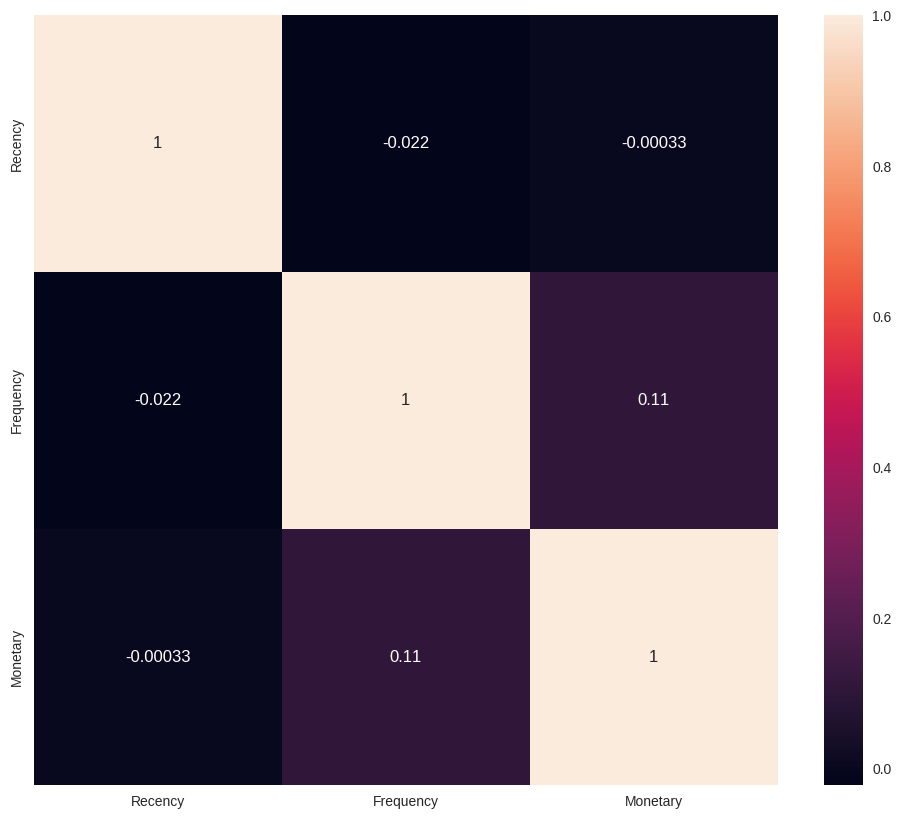

In [41]:
#correlation matrix
corr(rfm)

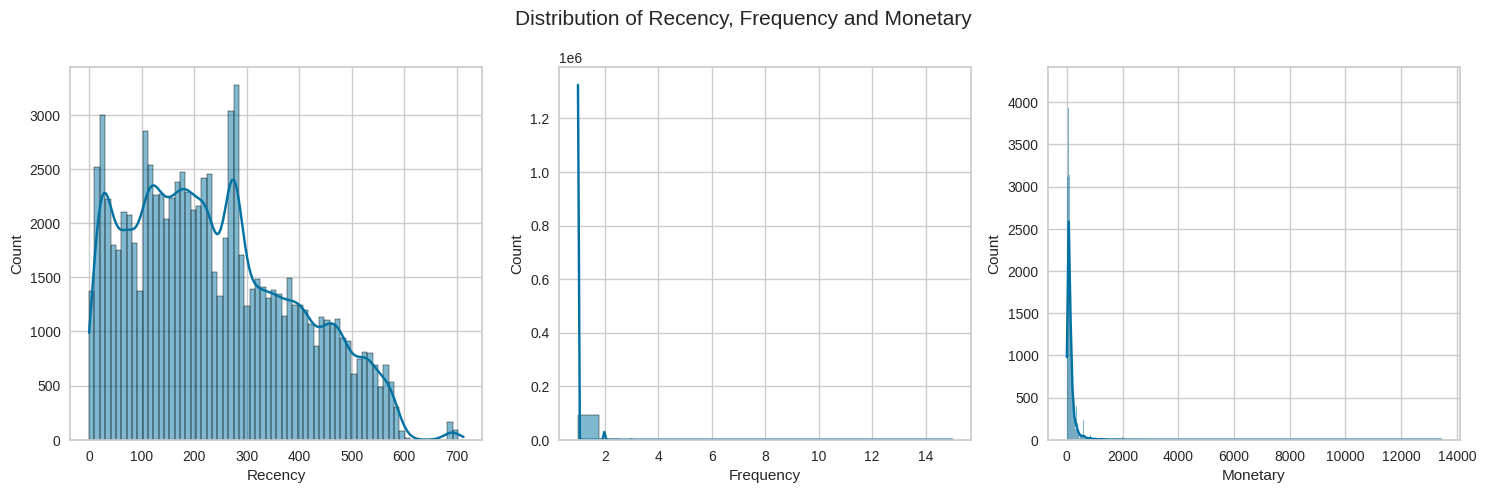

In [42]:
#plotting, recency, frequency and monetary
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 5))
sns.histplot(rfm['Recency'], kde = True, ax = ax[0])
sns.histplot(rfm['Frequency'], kde = True, ax = ax[1])
sns.histplot(rfm['Monetary'], kde = True, ax = ax[2])
plt.suptitle('Distribution of Recency, Frequency and Monetary', fontsize = 15)
plt.tight_layout(pad = 1)
plt.show()

In [43]:
rfm_transformed = rfm.copy()
for feature in rfm.columns[2:]:
    rfm_transformed[feature] = rfm_transformed[feature].apply(
                                                  lambda x: np.power(x, (1/10)))  

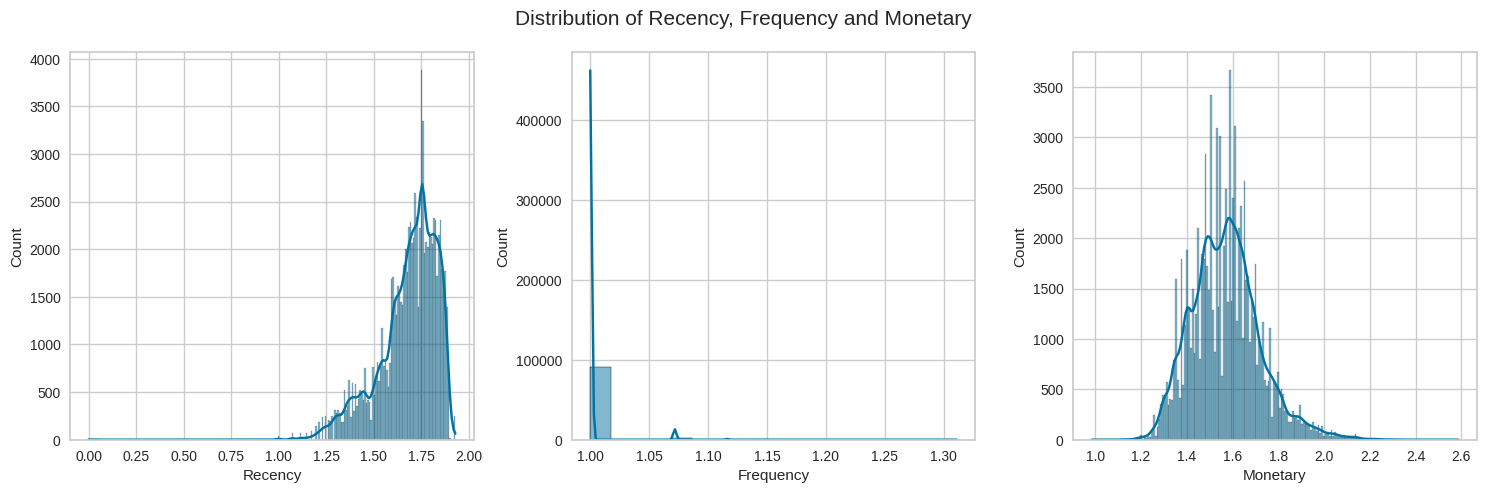

In [44]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 5))
sns.histplot(rfm_transformed['Recency'], kde = True, ax = ax[0])
sns.histplot(rfm_transformed['Frequency'], kde = True, ax = ax[1])
sns.histplot(rfm_transformed['Monetary'], kde = True, ax = ax[2])
plt.suptitle('Distribution of Recency, Frequency and Monetary', fontsize = 15)
plt.tight_layout(pad = 1)
plt.show()

On commence la segmentation par creer des scores 

In [45]:
rfm["recency_score"]  = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])
rfm["frequency_score"] = pd.qcut(rfm['Frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
rfm["monetary_score"] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])

In [46]:
# Nouveau rfm dataset incluant les scores
rfm.head(5)

customer_unique_id LastPurchaseDate  Recency  Frequency  \
0  0000366f3b9a7992bf8c76cfdf3221e2       2018-05-10      111          1   
1  0000b849f77a49e4a4ce2b2a4ca5be3f       2018-05-07      114          1   
2  0000f46a3911fa3c0805444483337064       2017-03-10      537          1   
3  0000f6ccb0745a6a4b88665a16c9f078       2017-10-12      321          1   
4  0004aac84e0df4da2b147fca70cf8255       2017-11-14      288          1   

   Monetary recency_score frequency_score monetary_score  
0    129.90             4               1              4  
1     18.90             4               1              1  
2     69.00             1               1              2  
3     25.99             2               1              1  
4    180.00             2               1              5

In [47]:
print("recency_score: ",rfm["recency_score"].unique() )
print("*********" )
print("frequency_score: ",rfm["frequency_score"].unique() )
print("*********" )
print("monetary_score: ",rfm["monetary_score"].unique() )

recency_score:  [4, 1, 2, 3, 5]
Categories (5, int64): [5 < 4 < 3 < 2 < 1]
*********
frequency_score:  [1, 5, 2, 3, 4]
Categories (5, int64): [1 < 2 < 3 < 4 < 5]
*********
monetary_score:  [4, 1, 2, 5, 3]
Categories (5, int64): [1 < 2 < 3 < 4 < 5]


In [48]:
#creation RFM Score, represeting score R(score)F(score)M(score)
rfm['RFM_SCORE'] = rfm.recency_score.astype(str)+ rfm.frequency_score.astype(str) + rfm.monetary_score.astype(str)
rfm

customer_unique_id LastPurchaseDate  Recency  Frequency  \
0      0000366f3b9a7992bf8c76cfdf3221e2       2018-05-10      111          1   
1      0000b849f77a49e4a4ce2b2a4ca5be3f       2018-05-07      114          1   
2      0000f46a3911fa3c0805444483337064       2017-03-10      537          1   
3      0000f6ccb0745a6a4b88665a16c9f078       2017-10-12      321          1   
4      0004aac84e0df4da2b147fca70cf8255       2017-11-14      288          1   
...                                 ...              ...      ...        ...   
93353  fffcf5a5ff07b0908bd4e2dbc735a684       2017-06-08      447          1   
93354  fffea47cd6d3cc0a88bd621562a9d061       2017-12-10      262          1   
93355  ffff371b4d645b6ecea244b27531430a       2017-02-07      568          1   
93356  ffff5962728ec6157033ef9805bacc48       2018-05-02      119          1   
93357  ffffd2657e2aad2907e67c3e9daecbeb       2017-05-02      484          1   

       Monetary recency_score frequency_score monetary_score RFM_SCORE  
0        129.90             4               1              4       414  
1         18.90             4               1              1       411  
2         69.00             1               1              2       112  
3         25.99             2               1              1       211  
4        180.00             2               1              5       215  
...         ...           ...             ...            ...       ...  
93353   1570.00             1               5              5       155  
93354     64.89             3               5              2       352  
93355     89.90             1               5              3       153  
93356    115.00             4               5              4       454  
93357     56.99             1               5              2       152  

[93358 rows x 9 columns]

la segmentation RFM se base sur les score pour attribur les segments, on va alors grouper par RFM Score ensuite attribuer les segmantation selon ce qui est convenu mondialement

In [49]:
#grouping bu RFM Score
RFM_score = rfm[["RFM_SCORE", "Recency", "Frequency", "Monetary"]].groupby("RFM_SCORE").agg(['mean'])
RFM_score 

Recency Frequency    Monetary
                 mean      mean        mean
RFM_SCORE                                  
111        476.997644  1.000000   25.907338
112        471.073750  1.000000   55.973800
113        470.643836  1.000000   91.410986
114        471.891775  1.000000  139.596205
115        478.078983  1.000000  403.187952
...               ...       ...         ...
551         44.937226  1.016058   25.992905
552         42.776552  1.064828   54.844138
553         44.747320  1.136294   89.152527
554         47.243655  1.192893  140.717462
555         46.228306  1.443182  407.090041

[125 rows x 3 columns]

In [50]:
#RFM scores et segmentation
seg_map= {
    r'111|112|121|131|141|151': 'Lost customers',
    r'332|322|233|232|223|222|132|123|122|212|211': 'Hibernating customers', 
    r'155|154|144|214|215|115|114|113': 'Cannot Lose Them',
    r'255|254|245|244|253|252|243|242|235|234|225|224|153|152|145|143|142|135|134|133|125|124': 'At Risk',
    r'331|321|312|221|213|231|241|251': 'About To Sleep', 
    r'535|534|443|434|343|334|325|324': 'Need Attention',
    r'525|524|523|522|521|515|514|513|425|424|413|414|415|315|314|313': 'Promising',
    r'512|511|422|421|412|411|311': 'New Customers',
    r'553|551|552|541|542|533|532|531|452|451|442|441|431|453|433|432|423|353|352|351|342|341|333|323': 'Potential Loyalist',
    r'543|444|435|355|354|345|344|335': 'Loyal',
    r'555|554|544|545|454|455|445': 'Champions'
}

In [51]:
#creation "Segment" feature
rfm['Segment'] = rfm['recency_score'].astype(str) + rfm['frequency_score'].astype(str) + rfm['monetary_score'].astype(str)
rfm['Segment'] = rfm['Segment'].replace(seg_map, regex=True)
rfm.head()

customer_unique_id LastPurchaseDate  Recency  Frequency  \
0  0000366f3b9a7992bf8c76cfdf3221e2       2018-05-10      111          1   
1  0000b849f77a49e4a4ce2b2a4ca5be3f       2018-05-07      114          1   
2  0000f46a3911fa3c0805444483337064       2017-03-10      537          1   
3  0000f6ccb0745a6a4b88665a16c9f078       2017-10-12      321          1   
4  0004aac84e0df4da2b147fca70cf8255       2017-11-14      288          1   

   Monetary recency_score frequency_score monetary_score RFM_SCORE  \
0    129.90             4               1              4       414   
1     18.90             4               1              1       411   
2     69.00             1               1              2       112   
3     25.99             2               1              1       211   
4    180.00             2               1              5       215   

                 Segment  
0              Promising  
1          New Customers  
2         Lost customers  
3  Hibernating customers  
4       Cannot Lose Them

In [52]:
rfm['Segment'].unique()

array(['Promising', 'New Customers', 'Lost customers',
       'Hibernating customers', 'Cannot Lose Them', 'About To Sleep',
       'Loyal', 'Potential Loyalist', 'At Risk', 'Champions',
       'Need Attention'], dtype=object)

In [53]:
rfm['Segment'].nunique()

11

In [54]:
rfm.shape

(93358, 10)

In [55]:
RFMStats = rfm[["Segment", "Recency", "Frequency", "Monetary"]].groupby("Segment").agg(['mean','median', 'min', 'max', 'count'])
RFMStats

Recency                         Frequency         \
                             mean median  min  max  count      mean median   
Segment                                                                      
About To Sleep         276.819595  278.0  178  382   5981  1.001672    1.0   
At Risk                385.592956  366.0  269  713  15900  1.043899    1.0   
Cannot Lose Them       435.400348  437.0  269  695   5745  1.057441    1.0   
Champions               85.078998   82.0    0  177   5709  1.196181    1.0   
Hibernating customers  341.167099  324.0  178  694   8486  1.000000    1.0   
Lost customers         475.031224  469.0  383  695   4900  1.004694    1.0   
Loyal                  179.044699  194.0    0  268   6018  1.088069    1.0   
Need Attention         155.917820  176.0    1  268   5707  1.000000    1.0   
New Customers          122.639396  126.0    0  268   5427  1.000000    1.0   
Potential Loyalist     129.790088  129.0    0  268  17636  1.023191    1.0   
Promising              105.681745   92.0    0  268  11849  1.000000    1.0   

                                        Monetary                           \
                      min max  count        mean  median     min      max   
Segment                                                                     
About To Sleep          1   2   5981   37.078671   29.90    2.29    109.9   
At Risk                 1   6  15900  198.720421  129.00   39.92   5934.6   
Cannot Lose Them        1   4   5745  243.080573  159.80   69.98  13440.0   
Champions               1  15   5709  293.840396  198.90  109.95   4400.0   
Hibernating customers   1   1   8486   61.443153   59.00    3.85    109.9   
Lost customers          1   4   4900   30.908673   29.49    3.90     69.9   
Loyal                   1   9   6018  251.872278  179.90   69.95   3690.0   
Need Attention          1   1   5707  193.386699  139.00   69.94   7160.0   
New Customers           1   1   5427   38.457947   36.90    2.20     69.9   
Potential Loyalist      1   3  17636   56.127223   52.90    0.85    109.9   
Promising               1   1  11849  192.015176  129.90    3.00   6729.0   

                              
                       count  
Segment                       
About To Sleep          5981  
At Risk                15900  
Cannot Lose Them        5745  
Champions               5709  
Hibernating customers   8486  
Lost customers          4900  
Loyal                   6018  
Need Attention          5707  
New Customers           5427  
Potential Loyalist     17636  
Promising              11849

In [56]:
RFMStats['Ratio'] = (100*RFMStats['Monetary']["count"]/RFMStats['Monetary']["count"].sum()).round(2)
RFMStats

Recency                         Frequency         \
                             mean median  min  max  count      mean median   
Segment                                                                      
About To Sleep         276.819595  278.0  178  382   5981  1.001672    1.0   
At Risk                385.592956  366.0  269  713  15900  1.043899    1.0   
Cannot Lose Them       435.400348  437.0  269  695   5745  1.057441    1.0   
Champions               85.078998   82.0    0  177   5709  1.196181    1.0   
Hibernating customers  341.167099  324.0  178  694   8486  1.000000    1.0   
Lost customers         475.031224  469.0  383  695   4900  1.004694    1.0   
Loyal                  179.044699  194.0    0  268   6018  1.088069    1.0   
Need Attention         155.917820  176.0    1  268   5707  1.000000    1.0   
New Customers          122.639396  126.0    0  268   5427  1.000000    1.0   
Potential Loyalist     129.790088  129.0    0  268  17636  1.023191    1.0   
Promising              105.681745   92.0    0  268  11849  1.000000    1.0   

                                        Monetary                           \
                      min max  count        mean  median     min      max   
Segment                                                                     
About To Sleep          1   2   5981   37.078671   29.90    2.29    109.9   
At Risk                 1   6  15900  198.720421  129.00   39.92   5934.6   
Cannot Lose Them        1   4   5745  243.080573  159.80   69.98  13440.0   
Champions               1  15   5709  293.840396  198.90  109.95   4400.0   
Hibernating customers   1   1   8486   61.443153   59.00    3.85    109.9   
Lost customers          1   4   4900   30.908673   29.49    3.90     69.9   
Loyal                   1   9   6018  251.872278  179.90   69.95   3690.0   
Need Attention          1   1   5707  193.386699  139.00   69.94   7160.0   
New Customers           1   1   5427   38.457947   36.90    2.20     69.9   
Potential Loyalist      1   3  17636   56.127223   52.90    0.85    109.9   
Promising               1   1  11849  192.015176  129.90    3.00   6729.0   

                              Ratio  
                       count         
Segment                              
About To Sleep          5981   6.41  
At Risk                15900  17.03  
Cannot Lose Them        5745   6.15  
Champions               5709   6.12  
Hibernating customers   8486   9.09  
Lost customers          4900   5.25  
Loyal                   6018   6.45  
Need Attention          5707   6.11  
New Customers           5427   5.81  
Potential Loyalist     17636  18.89  
Promising              11849  12.69

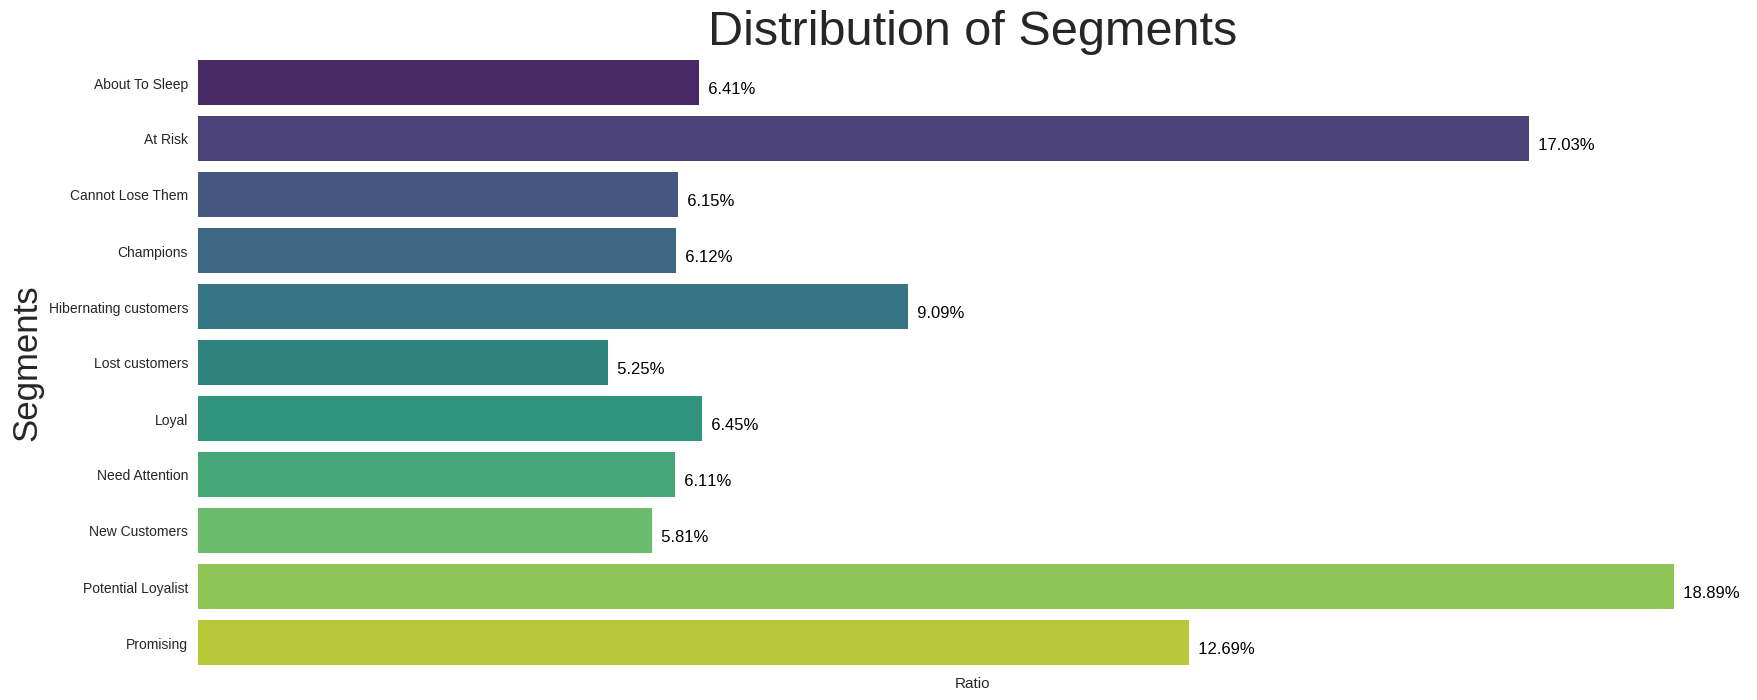

In [57]:
plt.figure(figsize = (20,8))
#plt.rc('font', size = 20)
per = sns.barplot(x = RFMStats['Ratio'], y = RFMStats.index, data = RFMStats, palette = "viridis")
sns.despine(bottom = True, left = True)
for i, v in enumerate(RFMStats['Ratio']):
    per.text(v, i+.20,"  {:.2f}".format(v)+"%", color = 'black', ha = "left")
per.set_ylabel('Segments', fontsize=25)
per.set(xticks = [])
plt.title('Distribution of Segments', fontsize=35)
plt.show()

In [58]:
sns.color_palette("husl", 11)

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.8836443049112893, 0.5240073524369634, 0.19569304285113343),
 (0.710130687316902, 0.6046852192663268, 0.19426060163712158),
 (0.5432776721247529, 0.6540981095185215, 0.19324494273892204),
 (0.19592059105779686, 0.6981620017487838, 0.3452219818913641),
 (0.2067117296964458, 0.6829103404254792, 0.5829988925822328),
 (0.21420912437215422, 0.6714963557258681, 0.6986206664203177),
 (0.22537170008202412, 0.6531400148480775, 0.841007805313343),
 (0.5596943802099308, 0.5764402169887779, 0.9583930713150347),
 (0.8578978803740231, 0.44058452715322166, 0.957819659566579),
 (0.9628653850704806, 0.4025928454059796, 0.7779310354076443)]

In [59]:
print(sns.color_palette("husl", 11).as_hex())

['#f77189', '#e18632', '#b59a32', '#8ba731', '#32b258', '#35ae95', '#37abb2', '#39a7d6', '#8f93f4', '#db70f4', '#f667c6']


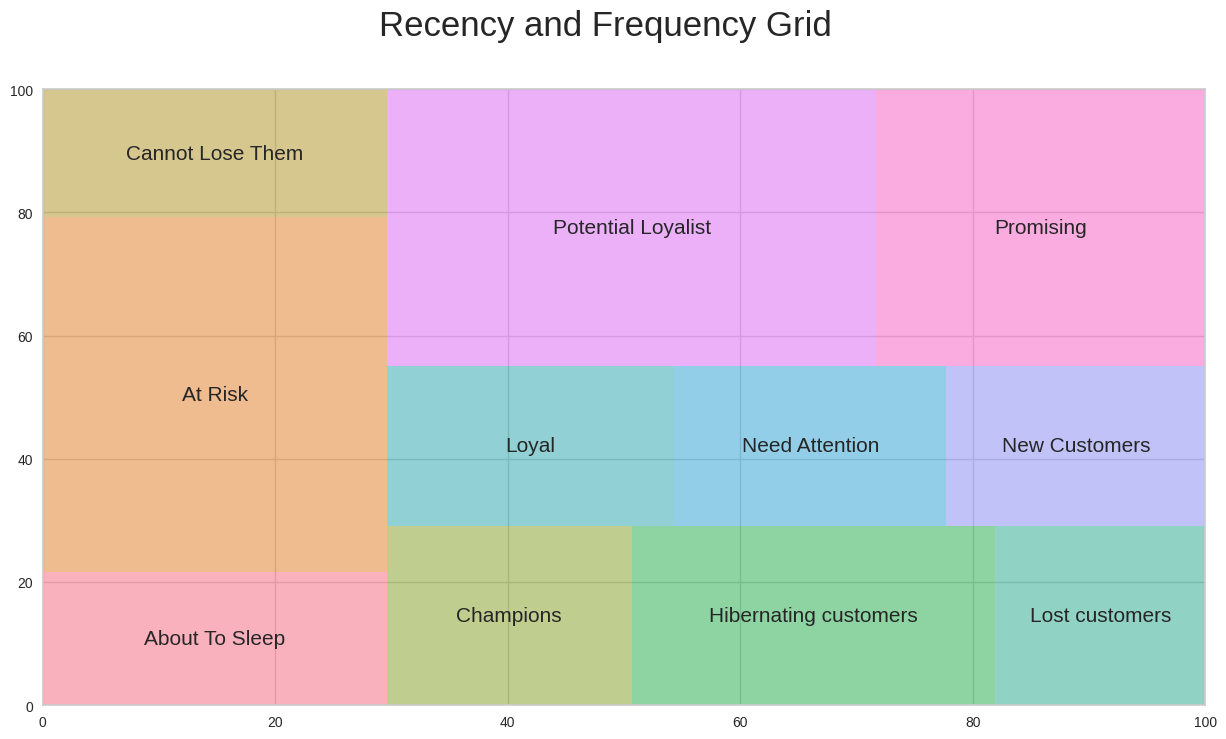

In [60]:
# Map rececy and frequency
plt.figure(figsize = (15,8))
plt.rc('font', size = 15)
squarify.plot(sizes = RFMStats["Recency"]["count"], label = RFMStats.index,
              color =['#f77189', '#e18632', '#b59a32', '#8ba731', '#32b258',
                      '#35ae95',  '#37abb2', '#39a7d6', '#8f93f4', '#db70f4', 
                      '#f667c6'],alpha = .55)
plt.suptitle("Recency and Frequency Grid", fontsize = 25);

Le but etant de trouver le meilleur modele notre approche serait de nous baser sur notre segmentation RFM pour trouver le meilleur modele d'apprentissage entre K-mean, hierrachie et DBSCAN

Une fois modele trouvé nous allons rajouter des features du dataset DATA nettoye dans le notebook 1 pour ameliorer le resultat.

# **Clustering avec l'algorithme du K-Means**


---



---





Preparation des données

In [61]:
rfm_2= rfm.drop(["recency_score", "frequency_score", "monetary_score",
                 "RFM_SCORE","LastPurchaseDate"  ], axis = 1)

In [62]:
rfm_1 = rfm_2.drop("Segment", axis = 1)
rfm_1

customer_unique_id  Recency  Frequency  Monetary
0      0000366f3b9a7992bf8c76cfdf3221e2      111          1    129.90
1      0000b849f77a49e4a4ce2b2a4ca5be3f      114          1     18.90
2      0000f46a3911fa3c0805444483337064      537          1     69.00
3      0000f6ccb0745a6a4b88665a16c9f078      321          1     25.99
4      0004aac84e0df4da2b147fca70cf8255      288          1    180.00
...                                 ...      ...        ...       ...
93353  fffcf5a5ff07b0908bd4e2dbc735a684      447          1   1570.00
93354  fffea47cd6d3cc0a88bd621562a9d061      262          1     64.89
93355  ffff371b4d645b6ecea244b27531430a      568          1     89.90
93356  ffff5962728ec6157033ef9805bacc48      119          1    115.00
93357  ffffd2657e2aad2907e67c3e9daecbeb      484          1     56.99

[93358 rows x 4 columns]

In [63]:
def check_skew(df, column):
    skew = stats.skew(df[column])
    skewtest = stats.skewtest(df[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df[column])
    plt.show()
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return

In [64]:
RFM_log = rfm_1.copy()
for i in RFM_log.columns[1:]:
    RFM_log[i] = np.log10(RFM_log[i])

In [65]:
RFM_log

customer_unique_id   Recency  Frequency  Monetary
0      0000366f3b9a7992bf8c76cfdf3221e2  2.045323        0.0  2.113609
1      0000b849f77a49e4a4ce2b2a4ca5be3f  2.056905        0.0  1.276462
2      0000f46a3911fa3c0805444483337064  2.729974        0.0  1.838849
3      0000f6ccb0745a6a4b88665a16c9f078  2.506505        0.0  1.414806
4      0004aac84e0df4da2b147fca70cf8255  2.459392        0.0  2.255273
...                                 ...       ...        ...       ...
93353  fffcf5a5ff07b0908bd4e2dbc735a684  2.650308        0.0  3.195900
93354  fffea47cd6d3cc0a88bd621562a9d061  2.418301        0.0  1.812178
93355  ffff371b4d645b6ecea244b27531430a  2.754348        0.0  1.953760
93356  ffff5962728ec6157033ef9805bacc48  2.075547        0.0  2.060698
93357  ffffd2657e2aad2907e67c3e9daecbeb  2.684845        0.0  1.755799

[93358 rows x 4 columns]

## Preprocessing



In [66]:
rfm_1.columns

Index(['customer_unique_id', 'Recency', 'Frequency', 'Monetary'], dtype='object')

In [67]:
rfm_1.drop(["customer_unique_id"], axis=1, inplace=True)

In [68]:
rfm_1.shape

(93358, 3)

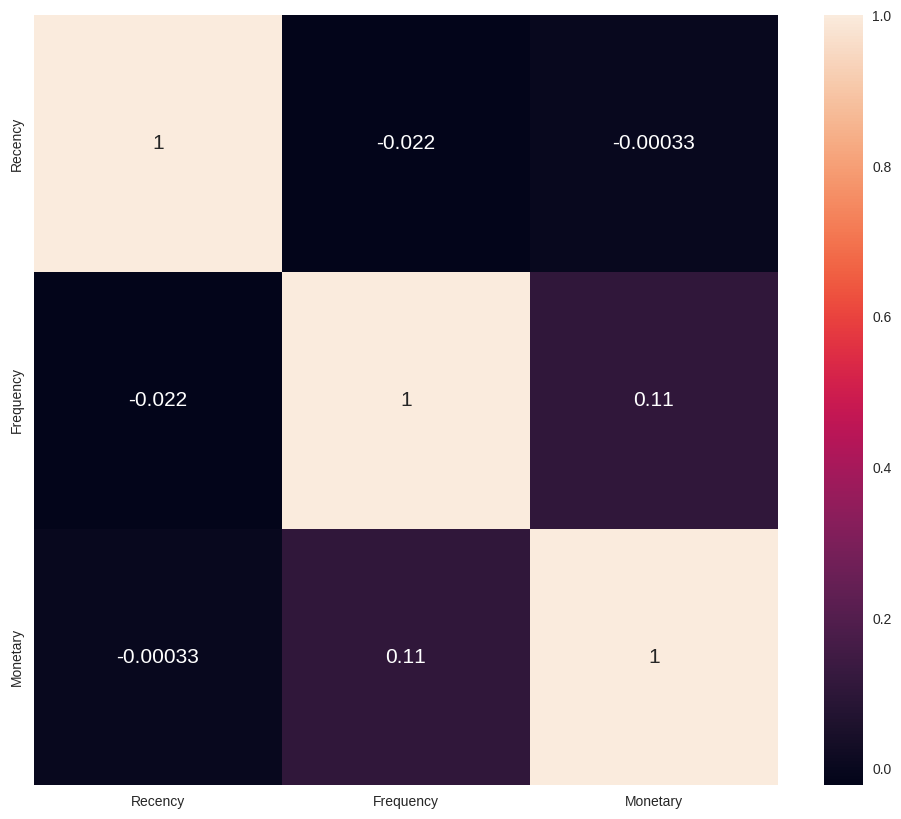

In [69]:
corr(rfm_1)

In [70]:
categorical_features = list(rfm_1.select_dtypes(exclude=['int64', 'float64', 'uint8']).columns)
numerical_features = list(rfm_1.select_dtypes(include=['int64','float64', 'uint8']).columns)
print('categorical_features  : ', categorical_features)
print('*****')
print('numerical_features: ', numerical_features)
print('*****')
len(numerical_features)

categorical_features  :  []
*****
numerical_features:  ['Recency', 'Frequency', 'Monetary']
*****


3

On prepare  le preprocessor :

In [71]:
scaler = MinMaxScaler()

preprocessor = ColumnTransformer([
    ('scaler', scaler, numerical_features)])

**Méthode du coude **: nous permet de déterminer le meilleur K (elbow method)


Un pipeline SKLearn est créé pour y inclure le preprocessing et la visualisation de la méthode du coude de notre KMeans.

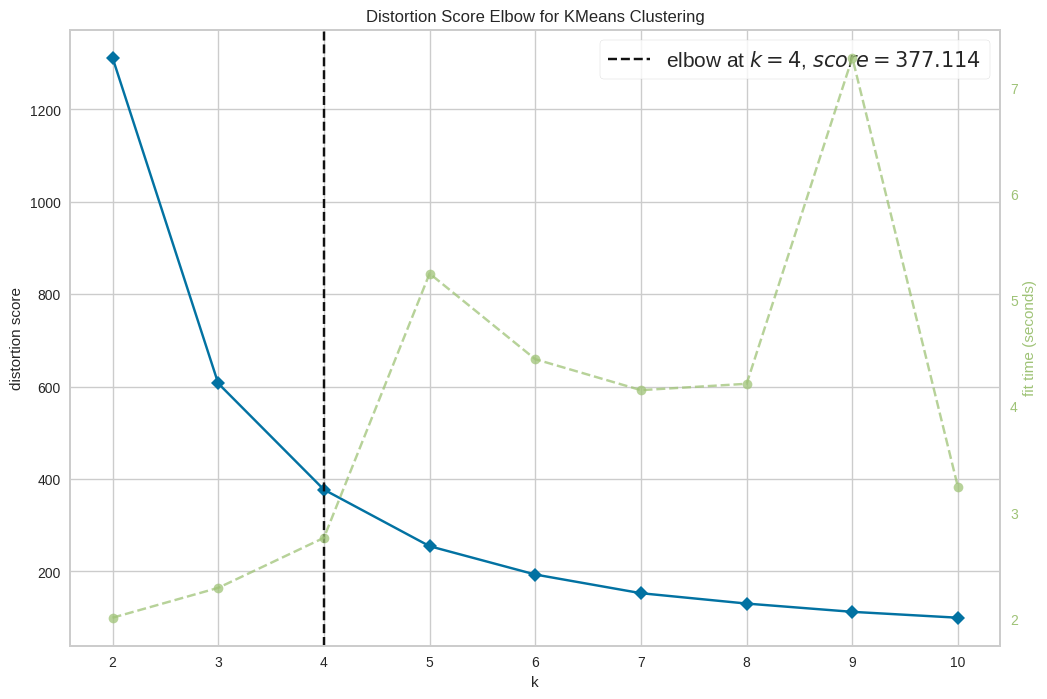

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [72]:
X = rfm_1.copy()
# Elbow method
kmeans_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("kelbowvisualizer", KElbowVisualizer(KMeans(),K=(4,12)))])
kmeans_visualizer.fit(X)
kmeans_visualizer.named_steps['kelbowvisualizer'].show()

Grâce ce graphe, nous deduisons qu'avec **K=4** clusters on aura le clusturing

## Coefficient de silhouette



Pour vérifier si ce clustering fonctionne, nous allons utiliser SilhouetteVisualizer pour afficher le coefficient de silhouette pour un échantillonage de chaque cluster. Cela permet de visualiser la densité et la séparation des clusters.

* **Silouhette** : rapport moyen entre la distance intra-cluster et la distance du cluster le plus proche,


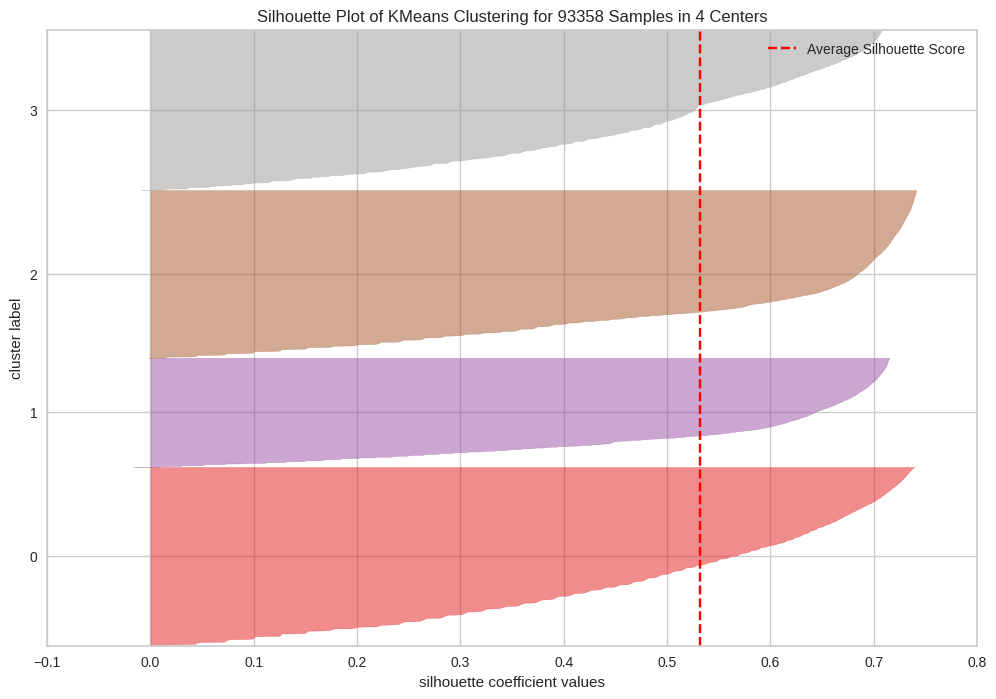

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 93358 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [73]:
# Visualisation silhouette:
K = kmeans_visualizer.named_steps['kelbowvisualizer'].elbow_value_


silhouette_visualizer = Pipeline([("preprocessor", preprocessor),
                                    ("silhouettevisualizer", 
                                     SilhouetteVisualizer(KMeans(K)))])
silhouette_visualizer.fit(X)
silhouette_visualizer.named_steps['silhouettevisualizer'].show()

Ici, les clusters semblent relativement bien répartis et les séparations sont claires avec cependant quelques erreurs sur l'un des clusters.



## Distances intercluster

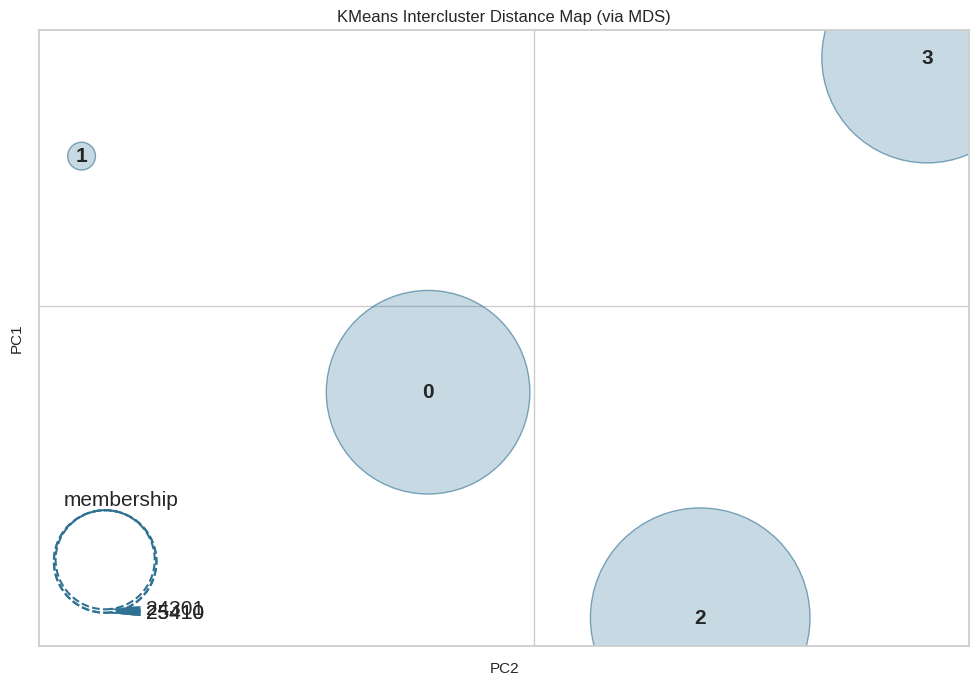

<Axes: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [74]:
# Intercluster distance Map with best k
distance_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("distancevisualizer", InterclusterDistance(KMeans(K)))])
distance_visualizer.fit(X)
distance_visualizer.named_steps['distancevisualizer'].show()

Sur cette projection en 2D, on remarque que les différents clusters sont bien séparés sur les 2 premières composantes principales. Le clustering semble donc performant et il faut a présent identifier les composantes métier de chaque cluster.



## Analyse des différents clusters

A présent, nous allons entrainer notre KMeans avec le K optimal sélectionné et affecter son cluster à chaque client. Ainsi, nous pourrons analyser les différences entre chaque cluster :

In [75]:
# KMeans Pipeline with best K
kmeans_model = Pipeline([("preprocessor", preprocessor),
                         ("kmeans", KMeans(K))])
kmeans_model.fit(X)

# Kmeans labels
kmeans_labels = kmeans_model.named_steps['kmeans'].labels_
rfm_2["Cluster"] = kmeans_labels

Nous allons dans un premier temps grouper les individus par cluster pour analyser les moyennes :

In [76]:
kmeans_clusters_means = rfm_2.groupby("Cluster").mean().reset_index()
kmeans_clusters_means

Cluster     Recency  Frequency    Monetary
0        0  313.831365   1.031768  142.915545
1        1  183.426700   1.035321  138.044000
2        2  483.372078   1.024890  141.090510
3        3   61.909327   1.038528  144.544357

In [77]:
kmeans_clusters_means.shape

(4, 4)

In [78]:
kmeans_clusters_means.columns

Index(['Cluster', 'Recency', 'Frequency', 'Monetary'], dtype='object')

In [79]:
rfm_2

customer_unique_id  Recency  Frequency  Monetary  \
0      0000366f3b9a7992bf8c76cfdf3221e2      111          1    129.90   
1      0000b849f77a49e4a4ce2b2a4ca5be3f      114          1     18.90   
2      0000f46a3911fa3c0805444483337064      537          1     69.00   
3      0000f6ccb0745a6a4b88665a16c9f078      321          1     25.99   
4      0004aac84e0df4da2b147fca70cf8255      288          1    180.00   
...                                 ...      ...        ...       ...   
93353  fffcf5a5ff07b0908bd4e2dbc735a684      447          1   1570.00   
93354  fffea47cd6d3cc0a88bd621562a9d061      262          1     64.89   
93355  ffff371b4d645b6ecea244b27531430a      568          1     89.90   
93356  ffff5962728ec6157033ef9805bacc48      119          1    115.00   
93357  ffffd2657e2aad2907e67c3e9daecbeb      484          1     56.99   

                     Segment  Cluster  
0                  Promising        3  
1              New Customers        3  
2             Lost customers        2  
3      Hibernating customers        0  
4           Cannot Lose Them        0  
...                      ...      ...  
93353       Cannot Lose Them        2  
93354     Potential Loyalist        0  
93355                At Risk        2  
93356              Champions        3  
93357                At Risk        2  

[93358 rows x 6 columns]

In [80]:
#Affichons les segment appartenants au cluster 0
rfm_cluster_0 = rfm_2[rfm_2['Cluster']==0]
rfm_cluster_0.Segment.unique()

array(['Hibernating customers', 'Cannot Lose Them', 'About To Sleep',
       'New Customers', 'Promising', 'Lost customers', 'At Risk', 'Loyal',
       'Potential Loyalist', 'Need Attention'], dtype=object)

In [81]:
rfm_cluster_0['Segment'].value_counts()

At Risk                  9652
Hibernating customers    5215
About To Sleep           4011
Cannot Lose Them         1863
Potential Loyalist       1014
Loyal                     836
Need Attention            610
Lost customers            525
Promising                 433
New Customers             142
Name: Segment, dtype: int64

In [82]:
labels_rfm_0 = rfm_cluster_0.Segment.unique()

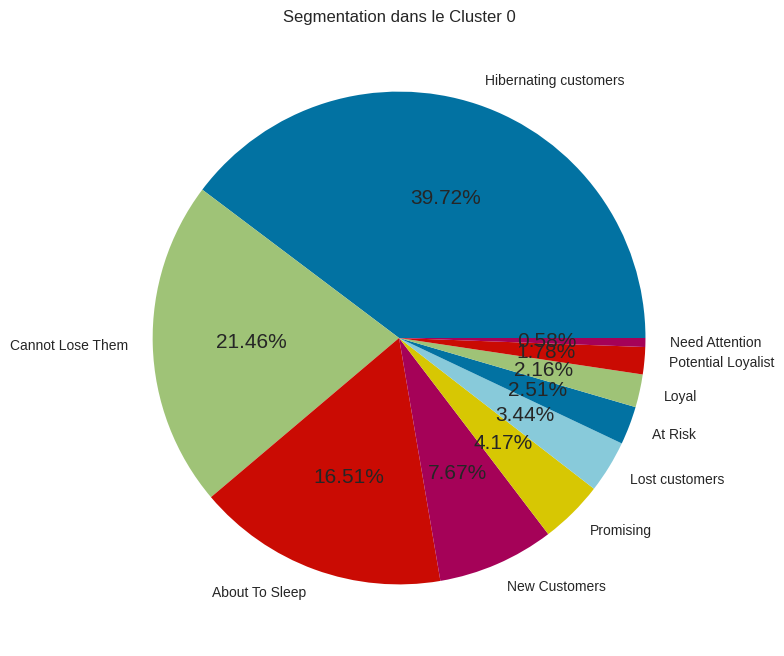

In [83]:
plt.pie(rfm_cluster_0['Segment'].value_counts(),
        labels = labels_rfm_0 ,
        autopct = lambda x: str(round(x, 2))
                   + '%', normalize = True)
plt.title ("Segmentation dans le Cluster 0")    
plt.show()

In [84]:
#Affichons les segment appartenants au cluster 1
rfm_cluster_1 = rfm_2[rfm_2['Cluster']==1]
labels_rfm_1 = rfm_cluster_1.Segment.unique()
labels_rfm_1

array(['Promising', 'New Customers', 'Loyal', 'About To Sleep',
       'Champions', 'Potential Loyalist', 'Need Attention',
       'Hibernating customers'], dtype=object)

In [85]:
rfm_cluster_1['Segment'].value_counts()


Potential Loyalist       8348
Promising                4150
Loyal                    3958
Need Attention           3152
New Customers            2699
About To Sleep           1970
Champions                1594
Hibernating customers    1223
Name: Segment, dtype: int64

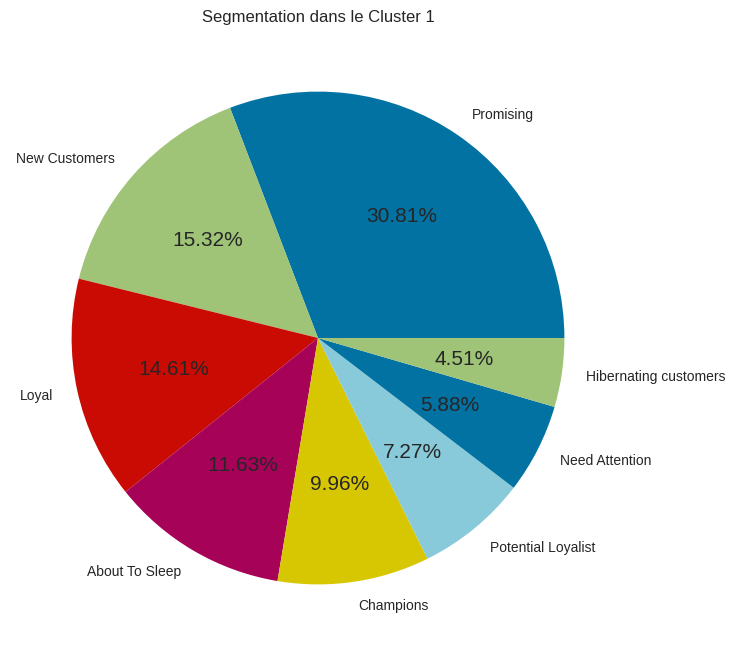

In [86]:
plt.pie(rfm_cluster_1['Segment'].value_counts(),
        labels = labels_rfm_1,
         autopct = lambda x: str(round(x, 2))
                   + '%', normalize = True)
plt.title ("Segmentation dans le Cluster 1")
plt.show()

In [87]:
#Affichons les segment appartenants au cluster 2
rfm_cluster_2 = rfm_2[rfm_2['Cluster']==2]
labels_rfm_2 = rfm_cluster_2.Segment.unique()
labels_rfm_2

array(['Lost customers', 'Cannot Lose Them', 'At Risk',
       'Hibernating customers'], dtype=object)

In [88]:
rfm_cluster_2['Segment'].value_counts()

At Risk                  6248
Lost customers           4375
Cannot Lose Them         3882
Hibernating customers    2048
Name: Segment, dtype: int64

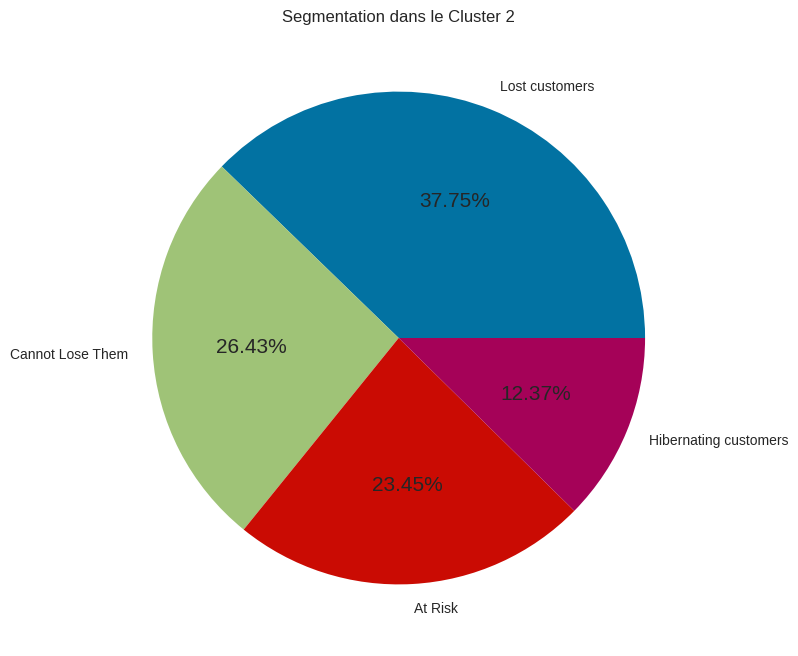

In [89]:
plt.pie(rfm_cluster_2['Segment'].value_counts(),
        labels =labels_rfm_2,
        autopct = lambda x: str(round(x, 2))
                   + '%', normalize = True)
plt.title ("Segmentation dans le Cluster 2")
plt.show()

In [90]:
#Affichons les segments appartenants au cluster 3
rfm_cluster_3 = rfm_2[rfm_2['Cluster']==3]
labels_rfm_3 = rfm_cluster_3.Segment.unique()
labels_rfm_3

array(['Promising', 'New Customers', 'Potential Loyalist', 'Champions',
       'Need Attention', 'Loyal'], dtype=object)

In [91]:
rfm_cluster_3['Segment'].value_counts()

Potential Loyalist    8274
Promising             7266
Champions             4115
New Customers         2586
Need Attention        1945
Loyal                 1224
Name: Segment, dtype: int64

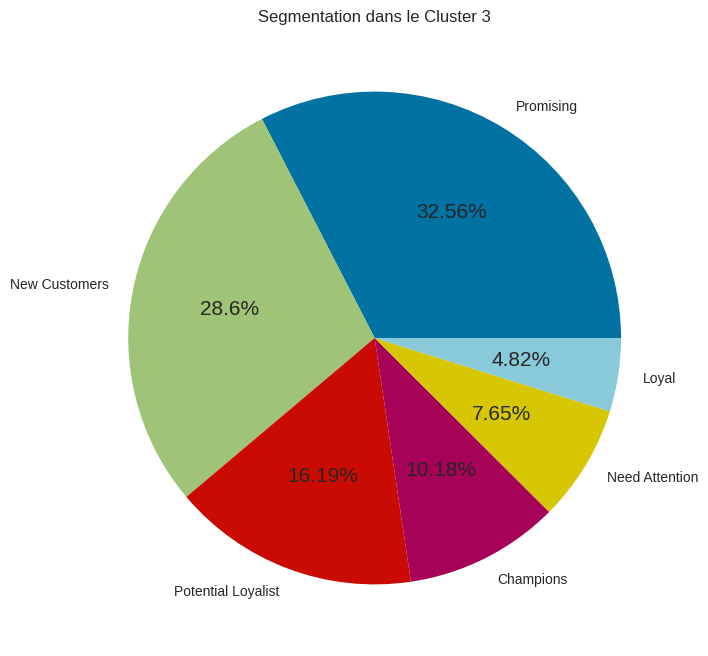

In [92]:
plt.pie(rfm_cluster_3['Segment'].value_counts(),
        labels = labels_rfm_3,
        autopct = lambda x: str(round(x, 2)) 
                  + '%', normalize = True)
plt.title ("Segmentation dans le Cluster 3")
plt.show()

In [93]:
rfm_2.to_csv('/content/drive/MyDrive/OC: Data Science/Datasets/Projet 5/seg_rfm_2.csv', index=False)

on entrainte notre modele avec k=4

In [94]:
X_scaled = preprocessor.fit_transform(X)

In [95]:
X_scaled = pd.DataFrame(X_scaled)

In [96]:
X_scaled.shape


(93358, 3)

In [97]:
X_scaled["Clusters"] = kmeans_labels

In [98]:
X_scaled.groupby("Clusters").mean()

0         1         2
Clusters                              
0         0.440156  0.002269  0.010571
1         0.257260  0.002523  0.010209
2         0.677941  0.001778  0.010435
3         0.086829  0.002752  0.010692

In [99]:
X_scaled_clusters = X_scaled.groupby("Clusters").mean()
X_scaled_clusters

0         1         2
Clusters                              
0         0.440156  0.002269  0.010571
1         0.257260  0.002523  0.010209
2         0.677941  0.001778  0.010435
3         0.086829  0.002752  0.010692

# Réduction dimensionnelle - PCA

Nous allons réaliser une Analyse en Composantes Principales pour vérifier s'il est possible de catégoriser nos clients avec moins de variables. L'objectif étant de conserver une inertie de 95%

In [100]:
# PCA Pipeline
pca = Pipeline([("preprocessor", MinMaxScaler()),
                ("pca", PCA(svd_solver='full'))])
pca.fit(X)
X_projected = pca.transform(X)

## Eboulis des valeurs propres

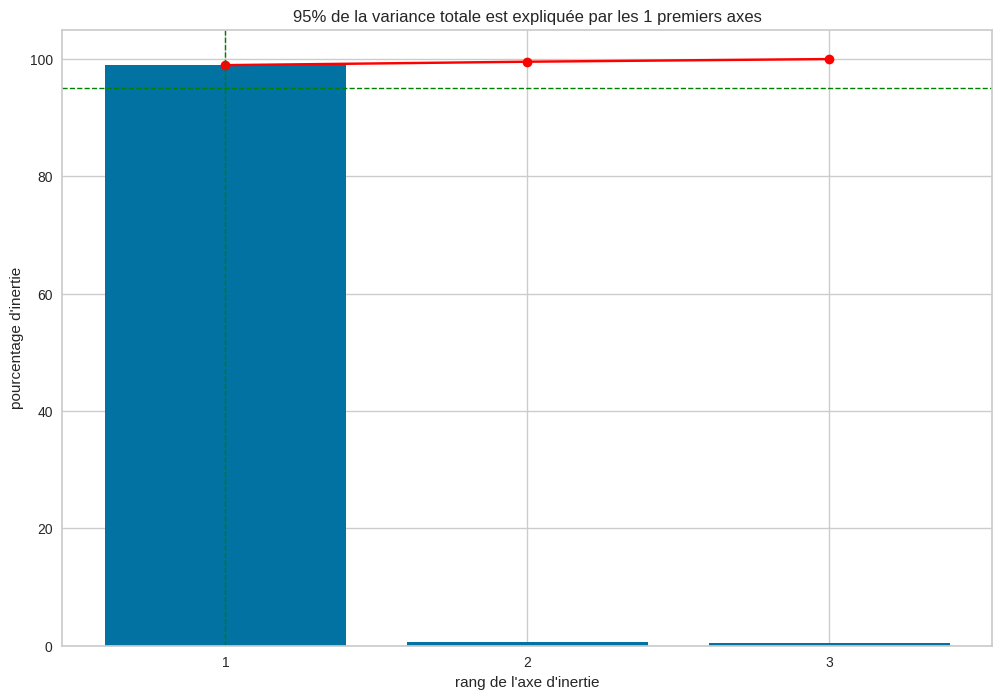

In [101]:
# Explained variance
varexpl = pca.named_steps['pca'].explained_variance_ratio_*100

# Plot of cumulated variance
plt.figure(figsize=(12,8))
plt.bar(np.arange(len(varexpl))+1, varexpl)

cumSumVar = varexpl.cumsum()
plt.plot(np.arange(len(varexpl))+1, cumSumVar,c="red",marker='o')
plt.axhline(y=95, linestyle="--", 
            color="green",
            linewidth=1)

limit = 95
valid_idx = np.where(cumSumVar >= limit)[0]
min_plans = valid_idx[cumSumVar[valid_idx].argmin()]+1
plt.axvline(x=min_plans, linestyle="--", 
            color="green",
            linewidth=1)

plt.xlabel("rang de l'axe d'inertie")
plt.xticks(np.arange(len(varexpl))+1)
plt.ylabel("pourcentage d'inertie")
plt.title("{}% de la variance totale est expliquée"\
          " par les {} premiers axes".format(limit,
                                            min_plans))
plt.show(block=False)

# Cercle des corrélations

In [102]:
def cerle_corr(pcs, n_comp, pca, axis_ranks, 
               labels = None, label_rotation = 0):
    
    fig = plt.figure(figsize = (20,n_comp*5))
    count = 1
    for d1, d2 in axis_ranks:
        if d2 < n_comp:
            
            # initialisation de la figure
            #fig.subplots_adjust(left=0.1,right=0.9,bottom=0.1,top=0.9)
            ax = plt.subplot(int(n_comp/2),2,count)
            ax.set_aspect('equal', adjustable = 'box') 
            
            #détermination des limites du graphique
            ax.set_xlim(-1,1) 
            ax.set_ylim(-1,1) 

            #affichage des flèches 
            ax.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                       pcs[d1,:],pcs[d2,:], 
                       angles='xy', scale_units='xy', scale=1, 
                       color="grey", alpha = 0.5)
            # et noms de variables
            for i,(x,y) in enumerate(pcs[[d1,d2]].T):
                ax.annotate(labels[i],(x,y),
                             ha='center', va = 'center',
                             fontsize='14',color="#17aafa", alpha=0.8) 

            #ajouter les axes 
            ax.plot([-1,1],[0,0],linewidth = 1, color = 'grey', ls='--') 
            ax.plot([0,0],[-1,1],linewidth = 1, color = 'grey', ls='--')

            #ajouter un cercle 
            cercle = plt.Circle((0,0),1,color='#17aafa',fill=False) 
            ax.add_artist(cercle) 

            # nom des axes, avec le pourcentage d'inertie expliqué
            ax.set_xlabel('F{} ({}%)'.format(d1+1, 
                                          round(100*pca.explained_variance_ratio_[d1],1)))
            ax.set_ylabel('F{} ({}%)'.format(d2+1, 
                                          round(100*pca.explained_variance_ratio_[d2],1)))

            ax.set_title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            count+=1
            
    plt.suptitle("Cercles des corrélations sur les {} premiers axes".format(n_comp),
                 y=.9, color="blue", fontsize=18)        
    plt.show(block=False)

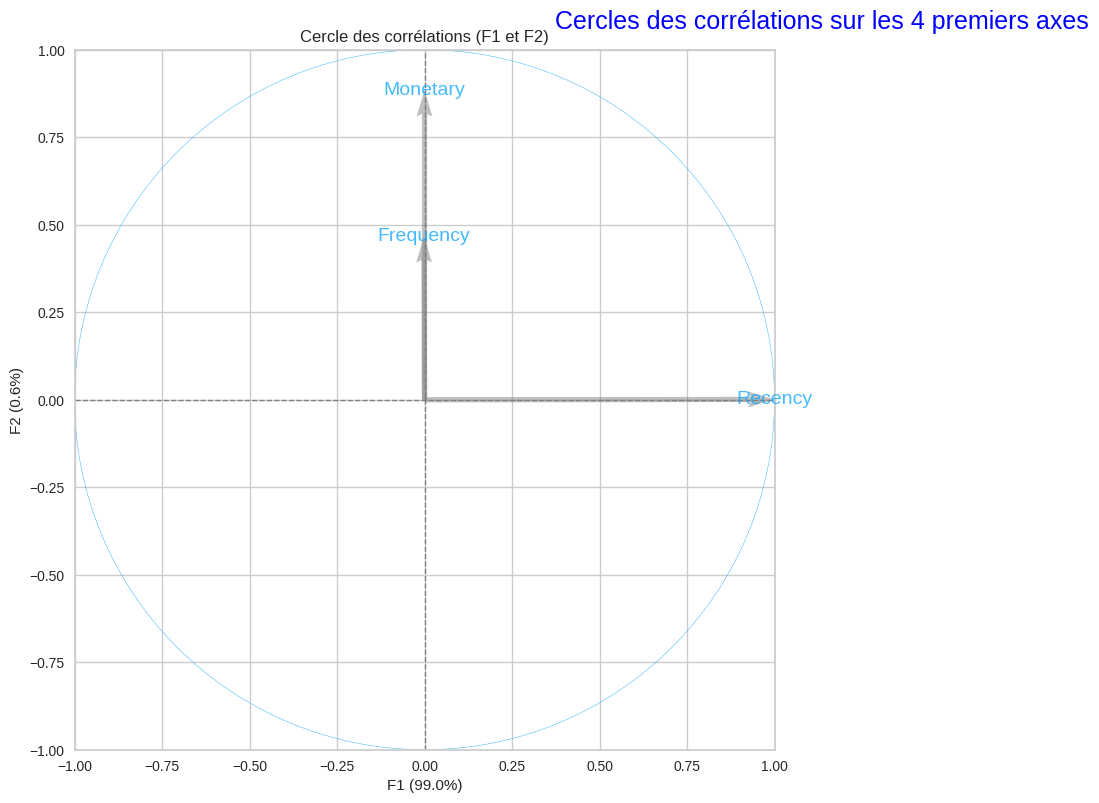

In [103]:
# Principal component space
pcs = pca.named_steps['pca'].components_

# Plot correlation circle
cerle_corr(pcs,
           4,
           pca.named_steps['pca'],
           [(0,1)],
           labels = np.array(X.columns))

On peut ainsi voir parfaitement les variables qui contribuent le plus à chaque axe. Par exemple, 



Nous allons donc intégrer à notre pipeline Kmeans une PCA sur 5 composantes pour vérifier si la réduction dimensionnelle réduit la qualité de la segmentation 

# Classification ascendante hiérarchique sur echantillon 



## Classification ascendante hiérarchique

---





In [104]:
rfm_3 = rfm_1.copy()

In [105]:
scaler = MinMaxScaler()

preprocessor = ColumnTransformer([
    ('scaler', scaler, rfm_3)])

In [106]:
X_3 = rfm_3.copy()
X_3.head()

Recency  Frequency  Monetary
0      111          1    129.90
1      114          1     18.90
2      537          1     69.00
3      321          1     25.99
4      288          1    180.00

In [107]:
X_3.columns

Index(['Recency', 'Frequency', 'Monetary'], dtype='object')

In [108]:
# Preprocessing 

# Scaling the data to bring all the attributes to a comparable level
scaler = StandardScaler()
X_3_scaled = scaler.fit_transform(X_3)
  
# Normalizing the data so that 
# the data approximately follows a Gaussian distribution
X_3_normalized = normalize(X_3_scaled)
  
# Converting the numpy array into a pandas DataFrame
X_3_normalized = pd.DataFrame(X_3_normalized)

In [109]:
# Explained variance
pca = PCA()
pca.fit(X_3_normalized)

print(pca.explained_variance_)
print(pca.explained_variance_ratio_)

[0.62293573 0.25302325 0.05768206]
[0.66721117 0.27100699 0.06178184]


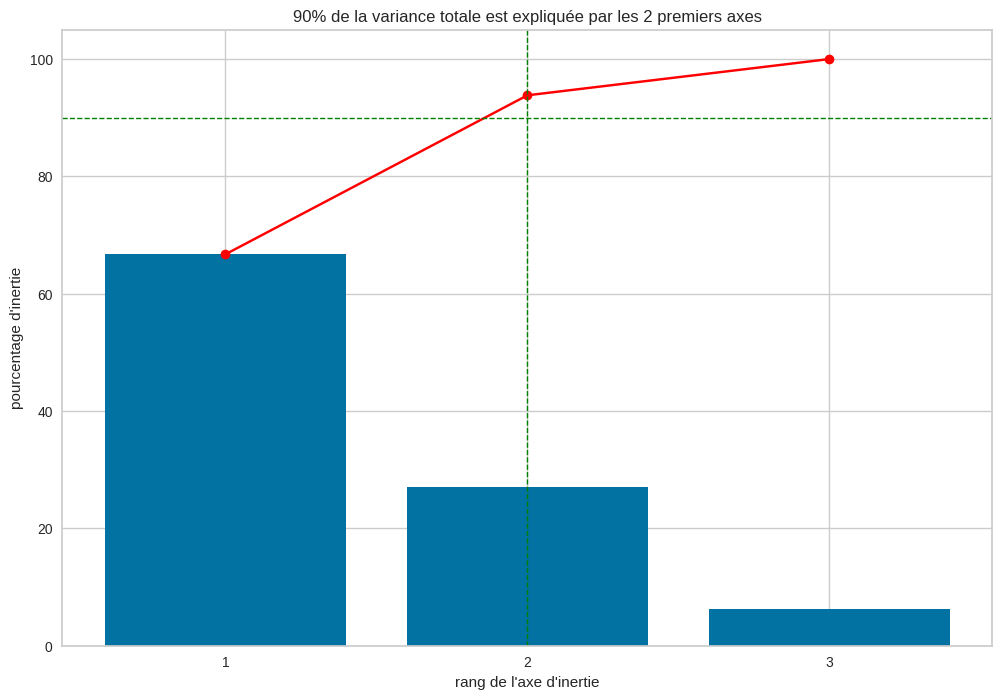

In [110]:
# Explained variance
pca = PCA()
pca.fit(X_3_normalized)
varexpl = pca.explained_variance_ratio_*100

# Plot of cumulated variance
plt.figure(figsize=(12,8))
plt.bar(np.arange(len(varexpl))+1, varexpl)

cumSumVar = varexpl.cumsum()
plt.plot(np.arange(len(varexpl))+1, cumSumVar,c="red",marker='o')
plt.axhline(y=90, linestyle="--", 
            color="green",
            linewidth=1)

limit = 90
valid_idx = np.where(cumSumVar >= limit)[0]
min_plans = valid_idx[cumSumVar[valid_idx].argmin()]+1
plt.axvline(x=min_plans, linestyle="--", 
            color="green",
            linewidth=1)

plt.xlabel("rang de l'axe d'inertie")
plt.xticks(np.arange(len(varexpl))+1)
plt.ylabel("pourcentage d'inertie")
plt.title("{}% de la variance totale est expliquée"\
          " par les {} premiers axes".format(limit,
                                            min_plans))
plt.show(block=False)

In [111]:
#  Réduire la dimensionnalité des Données

pca = PCA(n_components = 2)
X_principal = pca.fit_transform(X_3_normalized)
X_principal = pd.DataFrame(X_principal)
X_principal.columns = ['P1', 'P2']

In [112]:
import numpy as np
from sklearn.model_selection import train_test_split

In [113]:
 X_3_train, X_3_test = train_test_split(X_principal, test_size = 0.8, random_state = 0)

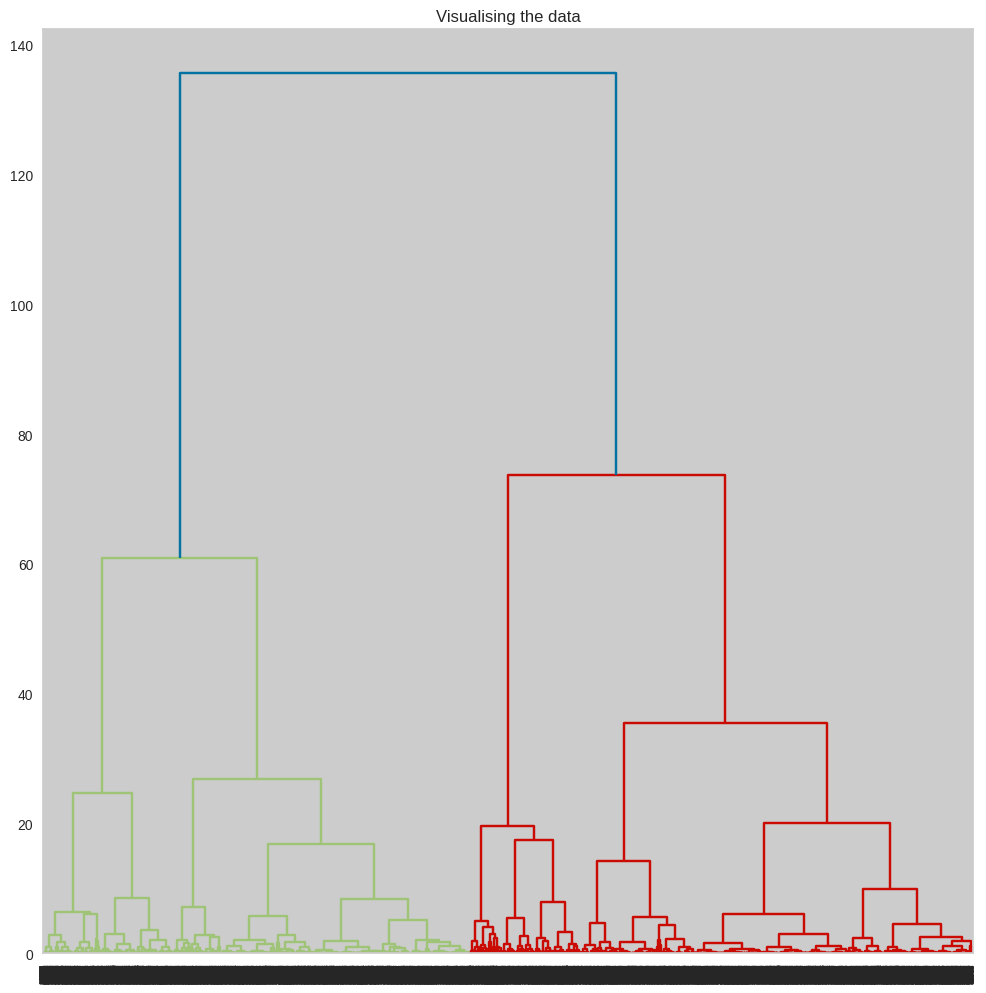

In [114]:
# Dendogrammes pour diviser le cluster en plusieur

plt.figure(figsize = (12, 12))
plt.title('Visualising the data')
Dendrogram = shc.dendrogram((shc.linkage(X_3_train, method ='ward')))

In [115]:
 y_3_train, y_3_test,  = train_test_split(X_principal, test_size = 0.2, random_state = 0)

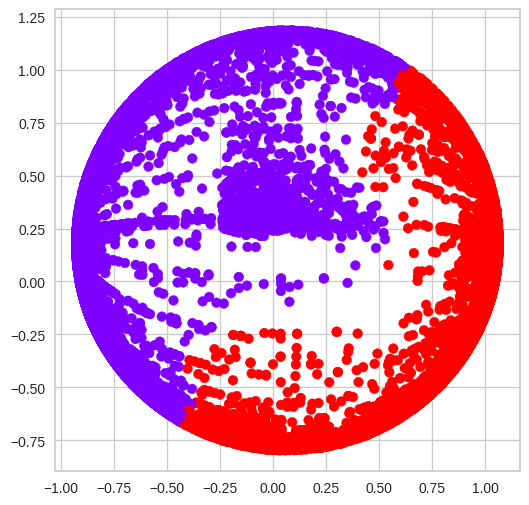

In [116]:
# k = 2

ac2 = AgglomerativeClustering(n_clusters = 2)
  

plt.figure(figsize =(6, 6))
plt.scatter(y_3_test['P1'], y_3_test['P2'],
            c = ac2.fit_predict(y_3_test), cmap ='rainbow')
plt.show()

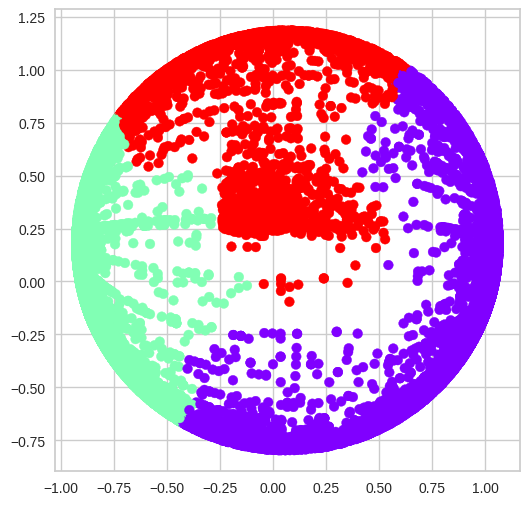

In [117]:
# k = 3

ac3 = AgglomerativeClustering(n_clusters = 3)
  
plt.figure(figsize =(6, 6))
plt.scatter(y_3_test['P1'], y_3_test['P2'],
            c = ac3.fit_predict(y_3_test), cmap ='rainbow')
plt.show()

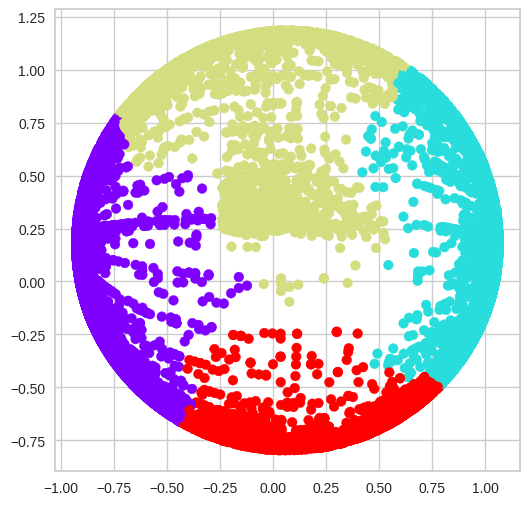

In [118]:
# k = 4

ac4 = AgglomerativeClustering(n_clusters = 4)
  
plt.figure(figsize =(6, 6))
plt.scatter(y_3_test['P1'], y_3_test['P2'],
            c = ac4.fit_predict(y_3_test), cmap ='rainbow')
plt.show()

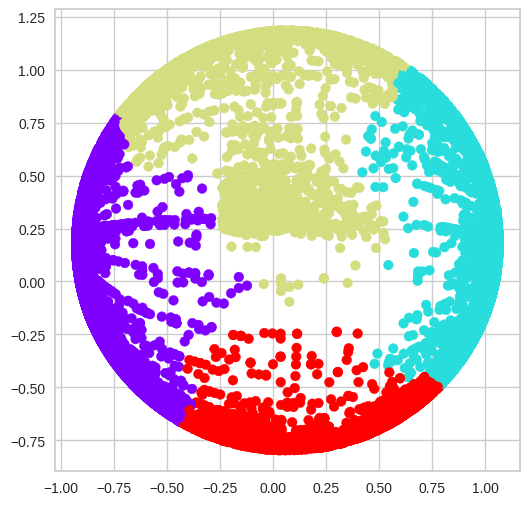

In [119]:
# k = 5

ac5 = AgglomerativeClustering(n_clusters = 5)
  
plt.figure(figsize =(6, 6))
plt.scatter(y_3_test['P1'], y_3_test['P2'],
            c = ac4.fit_predict(y_3_test), cmap ='rainbow')
plt.show()

meme avec une hierarchie a 5 clusters nous ne degageons que 4 clusters

### ==> les scores de silhouette

In [120]:
# Évaluation des différents modèles et visualisation des résultats.


silhouette_scores = []
silhouette_scores.append(
        silhouette_score(y_3_test, ac2.fit_predict(y_3_test)))
silhouette_scores.append(
        silhouette_score(y_3_test, ac3.fit_predict(y_3_test)))
silhouette_scores.append(
        silhouette_score(y_3_test, ac4.fit_predict(y_3_test)))
silhouette_scores.append(
        silhouette_score(y_3_test, ac5.fit_predict(y_3_test)))

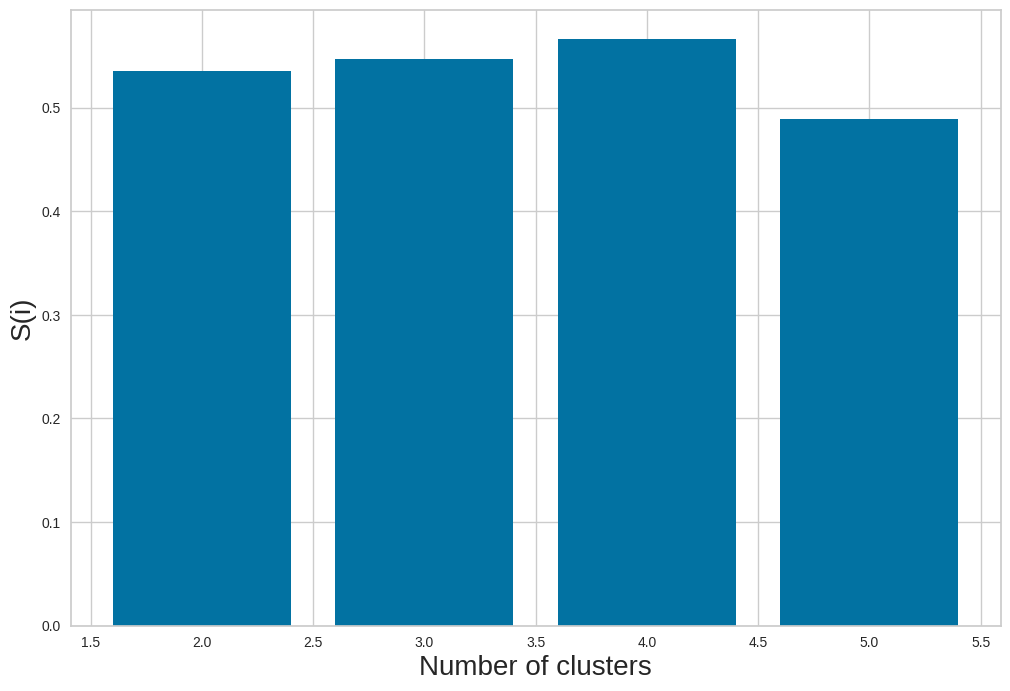

In [121]:
# Plotting 
k = [2, 3, 4, 5]
plt.bar(k, silhouette_scores)
plt.xlabel('Number of clusters', fontsize = 20)
plt.ylabel('S(i)', fontsize = 20)
plt.show()

Le nombre de **Clusters** optimal est de **4**


In [122]:
X1_train,X1_test = train_test_split(X_3_normalized, test_size = 0.8, random_state = 0)                     

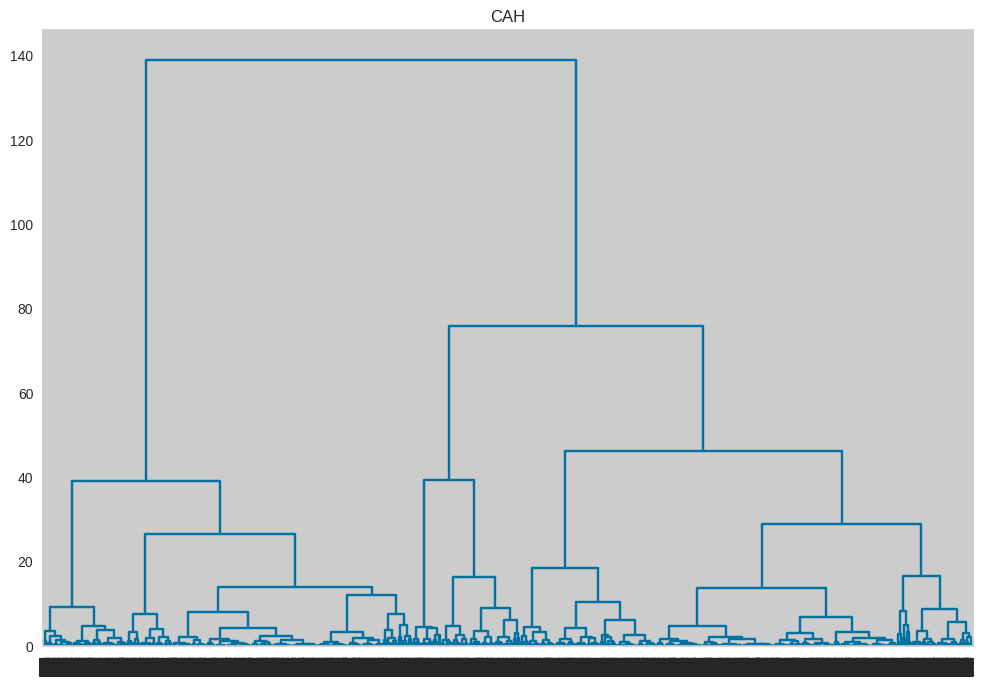

In [123]:
Z = linkage(X1_train,method='ward',metric='euclidean')
#affichage du dendrogramme
plt.title("CAH")
dendrogram(Z,labels=X1_train.index,orientation='top',color_threshold=0)
plt.show()

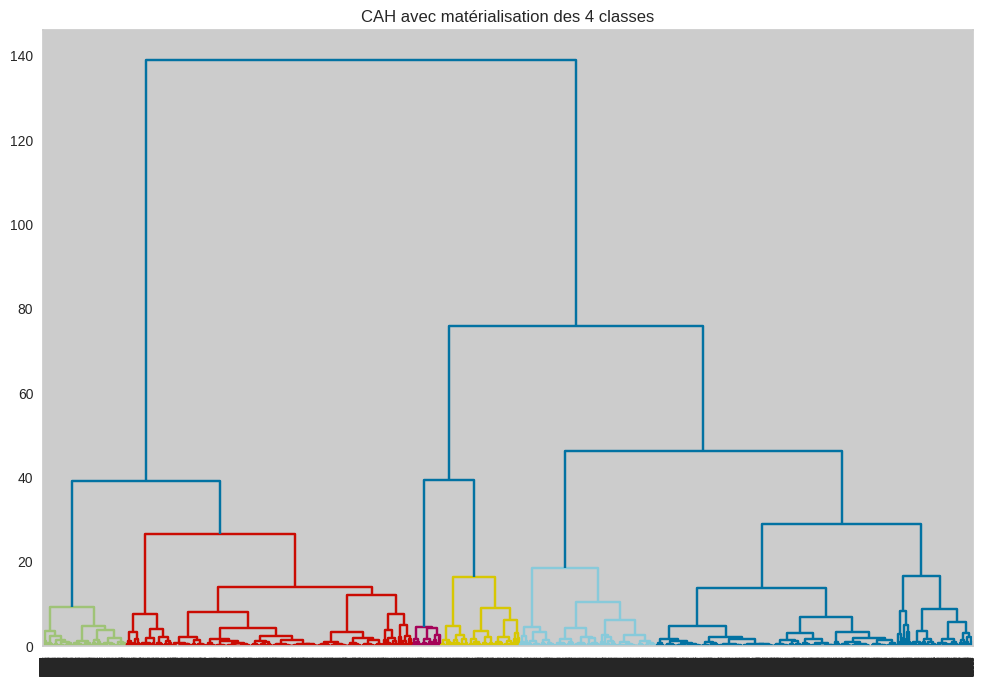

[4 3 2 ... 2 1 1]
        0
1   68268
1   20138
1   67126
1    2914
1   79628
..    ...
4   26211
4   63495
4   59999
4   36116
4   24683

[18671 rows x 1 columns]


In [124]:
from scipy.cluster.hierarchy import ward, fcluster
#matérialisation des 4 classes (hauteur t = 42)
plt.title('CAH avec matérialisation des 4 classes')
dendrogram(Z,labels=X1_train.index,orientation='top',color_threshold=38)
plt.show()
#découpage à la hauteur t = 42==> identifiants de 4 groupes obtenus
groupes_cah = fcluster(Z,t=42,criterion='distance')
print(groupes_cah)
#index triés des groupes 
idg = np.argsort(groupes_cah)
#affichage des observations et leurs groupes
print(pd.DataFrame(X_3_train.index[idg],groupes_cah[idg]))


In [125]:
X1_train = pd.DataFrame(X1_train, index=X1_train.index, columns=X1_train.columns)
X1_train_clusters = X1_train.mean()
X1_train_clusters

0   -0.059253
1   -0.180379
2   -0.175691
dtype: float64

# CLUSTERING PAR DBSCAN

In [126]:
# Numpy array of all the cluster labels assigned to each data point
db_default = DBSCAN(eps = 0.025, min_samples = 5).fit(X_principal)
labels = db_default.labels_

In [127]:
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(
                             n_samples = 750, centers = centers, cluster_std = 0.4, 
                              random_state=0    
                            )  

X = StandardScaler().fit_transform(X)

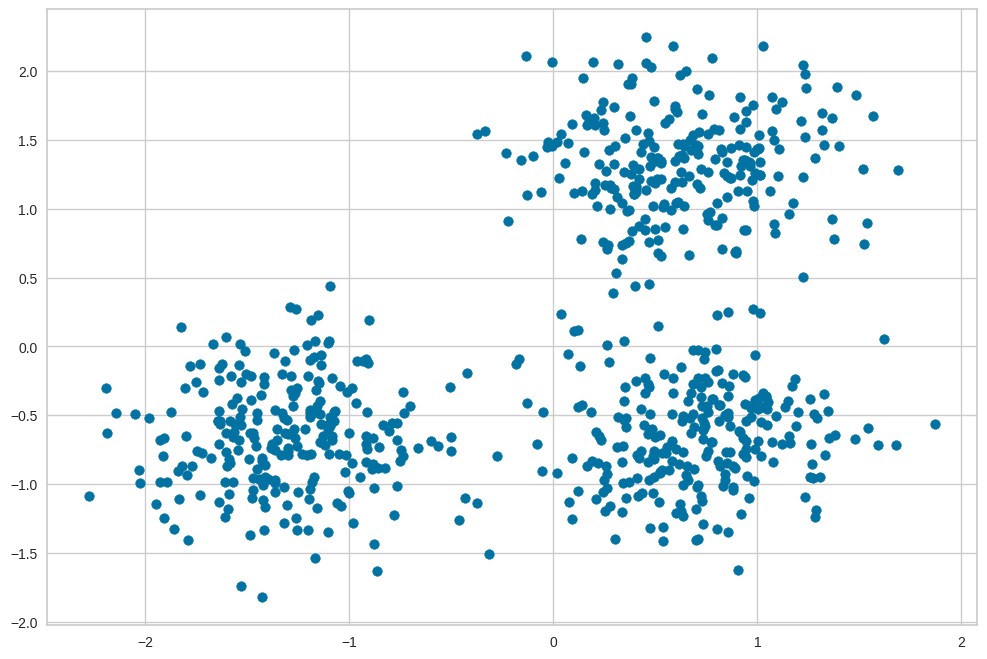

In [128]:
plt.scatter(X[:, 0], X[:, 1])
plt.show()

In [129]:
np.unique(labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
       50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
       67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83,
       84])

In [130]:
labels_true = X

db_default = DBSCAN(eps = 0.025, min_samples = 5).fit(X_principal)
core_samples_mask = np.zeros_like(db_default.labels_, dtype=bool)
core_samples_mask[db_default.core_sample_indices_] = True
labels = db_default.labels_


n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 85
Estimated number of noise points: 685


In [131]:
labels_true

array([[ 0.49426097,  1.45106697],
       [-1.42808099, -0.83706377],
       [ 0.33855918,  1.03875871],
       ...,
       [-0.05713876, -0.90926105],
       [-1.16939407,  0.03959692],
       [ 0.26322951, -0.92649949]])

In [132]:
labels

array([0, 0, 0, ..., 0, 0, 0])

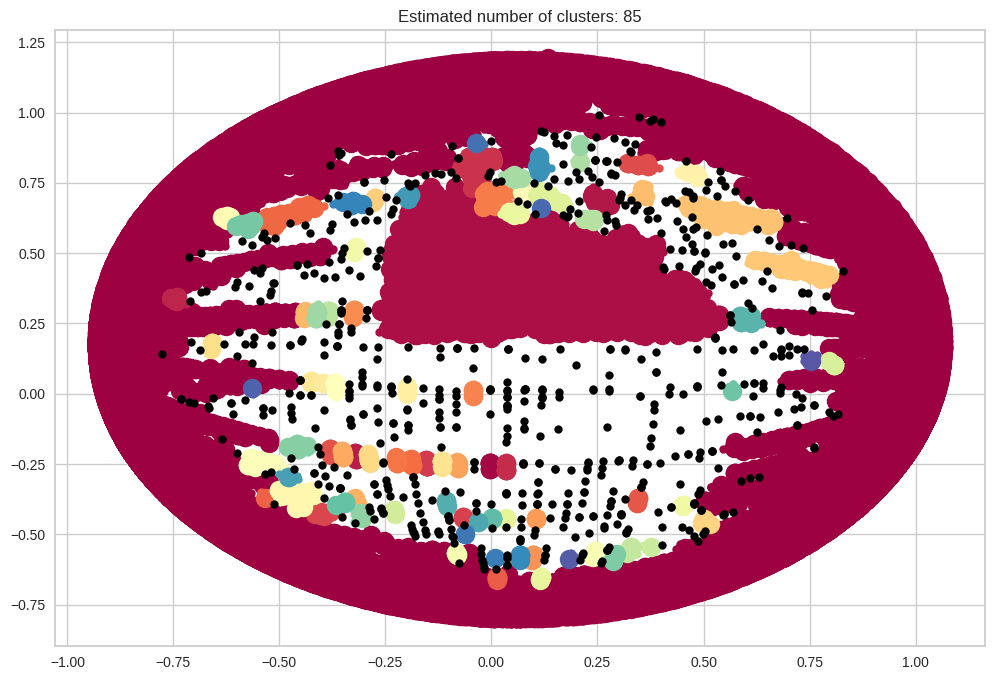

In [133]:
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X_principal[class_member_mask & core_samples_mask]
    plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X_principal[class_member_mask & ~core_samples_mask]
    plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

Vu le nombre de clusters **(85)** c'est inutile de continer avec ce modele

# Conclusion

---

---





Au vu des resultats, on en déduit que le meilleur modele a appliquer pour notre étude est le K-menas, avec un nombre de clusters K = 4,




In [134]:
data = pd.read_csv('/content/drive/MyDrive/OC: Data Science/Datasets/Projet 5/olist-customers-segmentation.csv')

In [135]:
rfm_2 = pd.read_csv('/content/drive/MyDrive/OC: Data Science/Datasets/Projet 5/seg_rfm_2.csv')

In [136]:
data.head(2)

customer_unique_id  nb_orders  total_spend  freight_value  \
0  0000366f3b9a7992bf8c76cfdf3221e2          1        129.9          12.00   
1  0000b849f77a49e4a4ce2b2a4ca5be3f          1         18.9           8.29   

   mean_payment_installments  mean_review_score  total_items  mean_nb_items  \
0                        8.0                5.0          1.0            1.0   
1                        1.0                4.0          1.0            1.0   

                   min                  max  order_mean_delay  \
0  2018-05-10 10:56:27  2018-05-10 10:56:27             111.0   
1  2018-05-07 11:11:27  2018-05-07 11:11:27             114.0   

                        customer_id  
0  fadbb3709178fc513abc1b2670aa1ad2  
1  4cb282e167ae9234755102258dd52ee8

In [137]:
rfm_2.head(2)

customer_unique_id  Recency  Frequency  Monetary  \
0  0000366f3b9a7992bf8c76cfdf3221e2      111          1     129.9   
1  0000b849f77a49e4a4ce2b2a4ca5be3f      114          1      18.9   

         Segment  Cluster  
0      Promising        3  
1  New Customers        3

In [138]:
rfm

customer_unique_id LastPurchaseDate  Recency  Frequency  \
0      0000366f3b9a7992bf8c76cfdf3221e2       2018-05-10      111          1   
1      0000b849f77a49e4a4ce2b2a4ca5be3f       2018-05-07      114          1   
2      0000f46a3911fa3c0805444483337064       2017-03-10      537          1   
3      0000f6ccb0745a6a4b88665a16c9f078       2017-10-12      321          1   
4      0004aac84e0df4da2b147fca70cf8255       2017-11-14      288          1   
...                                 ...              ...      ...        ...   
93353  fffcf5a5ff07b0908bd4e2dbc735a684       2017-06-08      447          1   
93354  fffea47cd6d3cc0a88bd621562a9d061       2017-12-10      262          1   
93355  ffff371b4d645b6ecea244b27531430a       2017-02-07      568          1   
93356  ffff5962728ec6157033ef9805bacc48       2018-05-02      119          1   
93357  ffffd2657e2aad2907e67c3e9daecbeb       2017-05-02      484          1   

       Monetary recency_score frequency_score monetary_score RFM_SCORE  \
0        129.90             4               1              4       414   
1         18.90             4               1              1       411   
2         69.00             1               1              2       112   
3         25.99             2               1              1       211   
4        180.00             2               1              5       215   
...         ...           ...             ...            ...       ...   
93353   1570.00             1               5              5       155   
93354     64.89             3               5              2       352   
93355     89.90             1               5              3       153   
93356    115.00             4               5              4       454   
93357     56.99             1               5              2       152   

                     Segment  
0                  Promising  
1              New Customers  
2             Lost customers  
3      Hibernating customers  
4           Cannot Lose Them  
...                      ...  
93353       Cannot Lose Them  
93354     Potential Loyalist  
93355                At Risk  
93356              Champions  
93357                At Risk  

[93358 rows x 10 columns]

In [139]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93358 entries, 0 to 93357
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   customer_unique_id  93358 non-null  object  
 1   LastPurchaseDate    93358 non-null  object  
 2   Recency             93358 non-null  int64   
 3   Frequency           93358 non-null  int64   
 4   Monetary            93358 non-null  float64 
 5   recency_score       93358 non-null  category
 6   frequency_score     93358 non-null  category
 7   monetary_score      93358 non-null  category
 8   RFM_SCORE           93358 non-null  object  
 9   Segment             93358 non-null  object  
dtypes: category(3), float64(1), int64(2), object(4)
memory usage: 6.0+ MB


Maintenant que nous savons que le modele clustering le plus adapté à notre problematique est **KMEANS** nous allons faire plusieurs essais avec differentes features. 
le but etant de trouver la meilleur distribution



---



---



# K-means RFM+Payment


---



---




In [140]:
data_payment = data.drop(['nb_orders', 'total_spend', 'freight_value', 
                          'mean_review_score', 'total_items',  'mean_nb_items',
                          'min', 'max', 'order_mean_delay', 'customer_id'], axis = 1)

In [141]:
data_payment.head(2)

customer_unique_id  mean_payment_installments
0  0000366f3b9a7992bf8c76cfdf3221e2                        8.0
1  0000b849f77a49e4a4ce2b2a4ca5be3f                        1.0

In [142]:
data_payment = data_payment.merge(rfm, on = 'customer_unique_id', how = 'left')
data_payment

customer_unique_id  mean_payment_installments  \
0      0000366f3b9a7992bf8c76cfdf3221e2                        8.0   
1      0000b849f77a49e4a4ce2b2a4ca5be3f                        1.0   
2      0000f46a3911fa3c0805444483337064                        8.0   
3      0000f6ccb0745a6a4b88665a16c9f078                        4.0   
4      0004aac84e0df4da2b147fca70cf8255                        6.0   
...                                 ...                        ...   
93353  fffcf5a5ff07b0908bd4e2dbc735a684                       10.0   
93354  fffea47cd6d3cc0a88bd621562a9d061                        1.0   
93355  ffff371b4d645b6ecea244b27531430a                        1.0   
93356  ffff5962728ec6157033ef9805bacc48                        5.0   
93357  ffffd2657e2aad2907e67c3e9daecbeb                        4.0   

      LastPurchaseDate  Recency  Frequency  Monetary recency_score  \
0           2018-05-10      111          1    129.90             4   
1           2018-05-07      114          1     18.90             4   
2           2017-03-10      537          1     69.00             1   
3           2017-10-12      321          1     25.99             2   
4           2017-11-14      288          1    180.00             2   
...                ...      ...        ...       ...           ...   
93353       2017-06-08      447          1   1570.00             1   
93354       2017-12-10      262          1     64.89             3   
93355       2017-02-07      568          1     89.90             1   
93356       2018-05-02      119          1    115.00             4   
93357       2017-05-02      484          1     56.99             1   

      frequency_score monetary_score RFM_SCORE                Segment  
0                   1              4       414              Promising  
1                   1              1       411          New Customers  
2                   1              2       112         Lost customers  
3                   1              1       211  Hibernating customers  
4                   1              5       215       Cannot Lose Them  
...               ...            ...       ...                    ...  
93353               5              5       155       Cannot Lose Them  
93354               5              2       352     Potential Loyalist  
93355               5              3       153                At Risk  
93356               5              4       454              Champions  
93357               5              2       152                At Risk  

[93358 rows x 11 columns]

In [143]:
data_payment.shape

(93358, 11)

In [144]:
data_payment.dtypes

customer_unique_id             object
mean_payment_installments     float64
LastPurchaseDate               object
Recency                         int64
Frequency                       int64
Monetary                      float64
recency_score                category
frequency_score              category
monetary_score               category
RFM_SCORE                      object
Segment                        object
dtype: object

In [145]:
data_payment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93358 entries, 0 to 93357
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   customer_unique_id         93358 non-null  object  
 1   mean_payment_installments  93358 non-null  float64 
 2   LastPurchaseDate           93358 non-null  object  
 3   Recency                    93358 non-null  int64   
 4   Frequency                  93358 non-null  int64   
 5   Monetary                   93358 non-null  float64 
 6   recency_score              93358 non-null  category
 7   frequency_score            93358 non-null  category
 8   monetary_score             93358 non-null  category
 9   RFM_SCORE                  93358 non-null  object  
 10  Segment                    93358 non-null  object  
dtypes: category(3), float64(2), int64(2), object(4)
memory usage: 6.7+ MB


In [146]:
rfm_pay = data_payment.drop(['customer_unique_id','Segment', 'LastPurchaseDate', 'recency_score' , 'frequency_score', 'RFM_SCORE', 'monetary_score'], axis = 1)

In [147]:
rfm_pay.head()

mean_payment_installments  Recency  Frequency  Monetary
0                        8.0      111          1    129.90
1                        1.0      114          1     18.90
2                        8.0      537          1     69.00
3                        4.0      321          1     25.99
4                        6.0      288          1    180.00

In [148]:
categorical_features_pay = list(rfm_pay.select_dtypes(
                                  include="object").columns)


numerical_features_pay = list(rfm_pay.select_dtypes(
                                  exclude= "object").columns)
print('categorical_features  : ', categorical_features_pay)
print("*****")
print('numerical_features: ', numerical_features_pay )
print("*****")
len(numerical_features_pay )

categorical_features  :  []
*****
numerical_features:  ['mean_payment_installments', 'Recency', 'Frequency', 'Monetary']
*****


4

In [149]:
scaler = MinMaxScaler()

preprocessor = ColumnTransformer([
    ('scaler', scaler, numerical_features_pay)])

In [150]:
data_payment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93358 entries, 0 to 93357
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   customer_unique_id         93358 non-null  object  
 1   mean_payment_installments  93358 non-null  float64 
 2   LastPurchaseDate           93358 non-null  object  
 3   Recency                    93358 non-null  int64   
 4   Frequency                  93358 non-null  int64   
 5   Monetary                   93358 non-null  float64 
 6   recency_score              93358 non-null  category
 7   frequency_score            93358 non-null  category
 8   monetary_score             93358 non-null  category
 9   RFM_SCORE                  93358 non-null  object  
 10  Segment                    93358 non-null  object  
dtypes: category(3), float64(2), int64(2), object(4)
memory usage: 6.7+ MB


In [151]:
X = rfm_pay.copy()
kmeans_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("kelbowvisualizer", KElbowVisualizer(KMeans(),K=(4,12)))])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', MinMaxScaler(),
                                                  ['mean_payment_installments',
                                                   'Recency', 'Frequency',
                                                   'Monetary'])])),
                ('kelbowvisualizer',
                 KElbowVisualizer(ax=<Axes: >,
                                  estimator=KMeans(n_clusters=10)))])

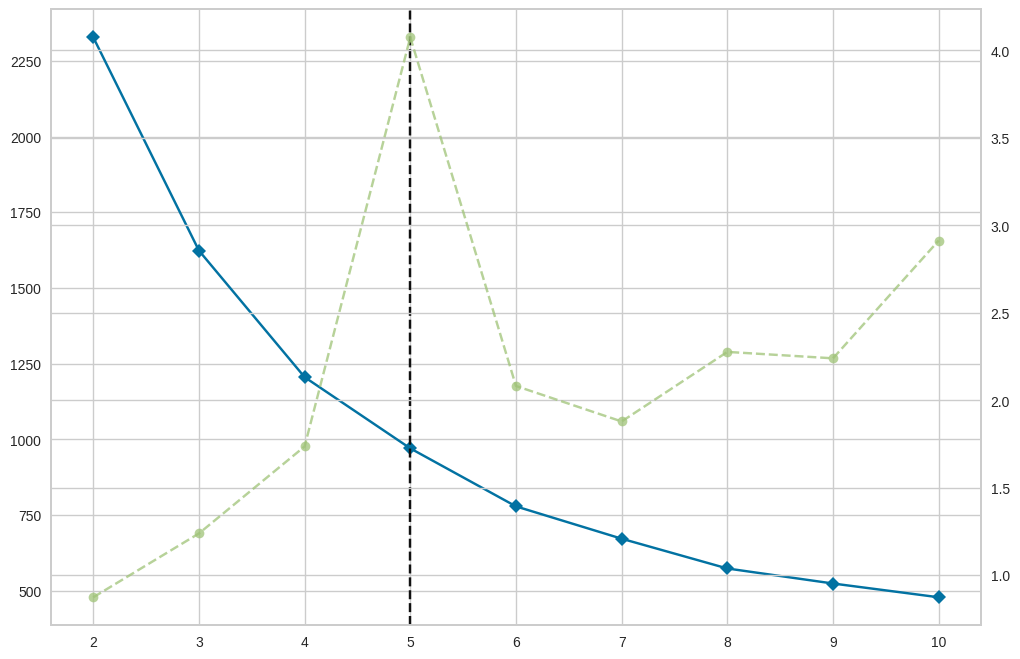

In [152]:
kmeans_visualizer.fit(X)

Nous remarquons qu'avec notre feature payment installement, notre K est de 5.

Regardons maintemant notre silhouette. 

In [153]:
kmeans_visualizer.named_steps['kelbowvisualizer'].show()

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [154]:
# KMeans Pipeline with best K
kmeans_model = Pipeline([("preprocessor", preprocessor),
                         ("kmeans", KMeans(K))])
kmeans_model.fit(X)

# Kmeans labels
kmeans_labels_pay = kmeans_model.named_steps['kmeans'].labels_
rfm_pay["Clusters"] = kmeans_labels_pay

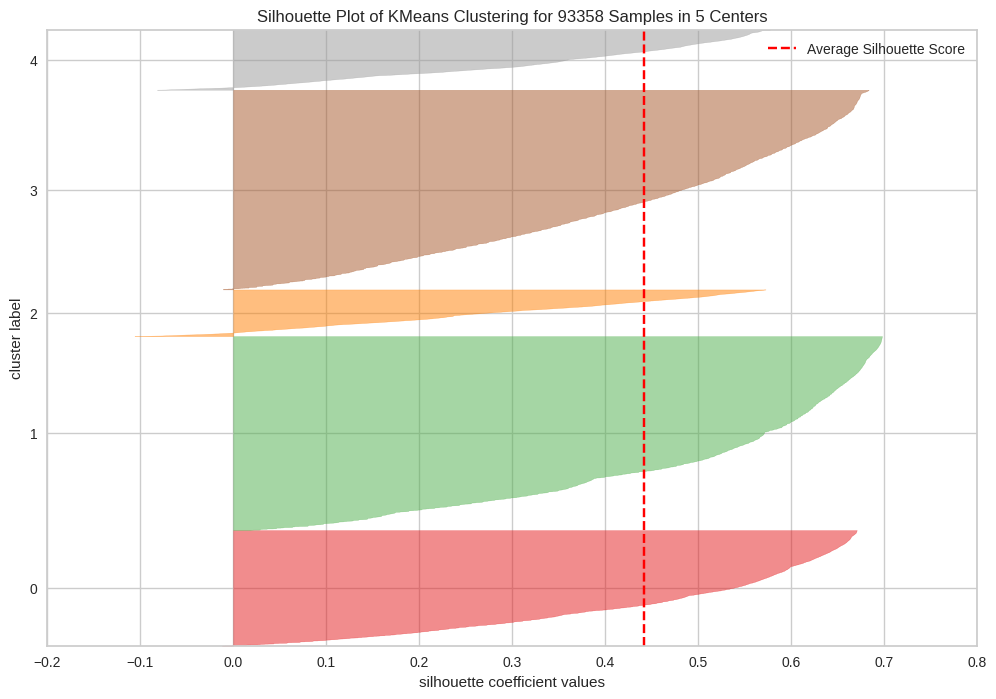

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 93358 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [155]:
K = kmeans_visualizer.named_steps['kelbowvisualizer'].elbow_value_


silhouette_visualizer = Pipeline([("preprocessor", preprocessor),
                                     ("silhouettevisualizer",
                                      SilhouetteVisualizer(KMeans(K)))])
silhouette_visualizer.fit(X)
silhouette_visualizer.named_steps['silhouettevisualizer'].show()

In [156]:
rfm_pay["Clusters"]

0        3
1        0
2        1
3        2
4        2
        ..
93353    1
93354    2
93355    1
93356    0
93357    1
Name: Clusters, Length: 93358, dtype: int32

In [157]:
kmeans_labels_pay

array([3, 0, 1, ..., 1, 0, 1], dtype=int32)

In [158]:
kmeans_clusters_means = rfm_pay.groupby("Clusters").mean().reset_index()
kmeans_clusters_means

Clusters  mean_payment_installments     Recency  Frequency    Monetary
0         0                   1.981747   85.323494   1.036639  117.631780
1         1                   3.274300  459.420827   1.026383  141.221928
2         2                   1.935173  258.185972   1.031012  114.756347
3         3                   8.331762  175.481614   1.045384  293.940622

In [159]:
kmeans_clusters_means.Clusters.unique()

array([0, 1, 2, 3])

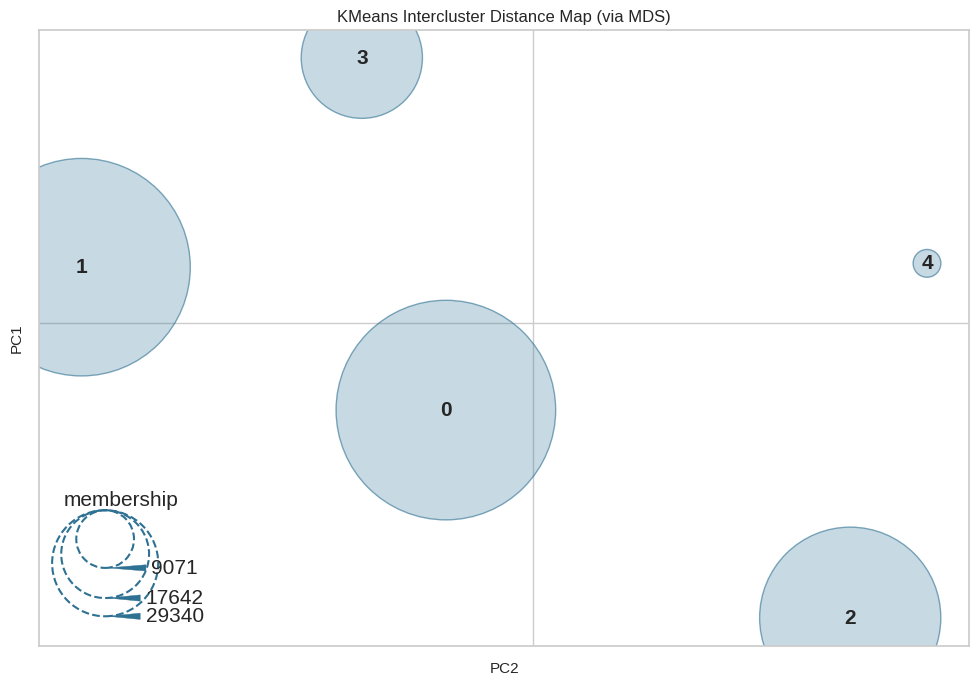

<Axes: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [160]:
distance_visualizer = Pipeline([
                                 ("preprocessor", preprocessor),
                                 ("distancevisualizer", InterclusterDistance(KMeans(K)))
                                 ]
                               )
distance_visualizer.fit(X)
distance_visualizer.named_steps['distancevisualizer'].show()

In [161]:
#definissions les segments selon cluster
rfm_pay

mean_payment_installments  Recency  Frequency  Monetary  Clusters
0                            8.0      111          1    129.90         3
1                            1.0      114          1     18.90         0
2                            8.0      537          1     69.00         1
3                            4.0      321          1     25.99         2
4                            6.0      288          1    180.00         2
...                          ...      ...        ...       ...       ...
93353                       10.0      447          1   1570.00         1
93354                        1.0      262          1     64.89         2
93355                        1.0      568          1     89.90         1
93356                        5.0      119          1    115.00         0
93357                        4.0      484          1     56.99         1

[93358 rows x 5 columns]

In [162]:
#scoring
rfm_pay["recency_score"]  = pd.qcut(rfm_pay['Recency'], 5, labels=[5, 4, 3, 2, 1])
rfm_pay["frequency_score"] = pd.qcut(rfm_pay['Frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
rfm_pay["monetary_score"] = pd.qcut(rfm_pay['Monetary'], 5, labels=[1, 2, 3, 4, 5])

rfm_pay['RFM_SCORE'] = rfm_pay.recency_score.astype(str)+ rfm_pay.frequency_score.astype(str) + rfm_pay.monetary_score.astype(str)

#segmentation
rfm_pay['Segment'] = rfm_pay['recency_score'].astype(str) + rfm_pay['frequency_score'].astype(str) + rfm_pay['monetary_score'].astype(str)
rfm_pay['Segment'] = rfm_pay['Segment'].replace(seg_map, regex=True)
rfm_pay.head()

mean_payment_installments  Recency  Frequency  Monetary  Clusters  \
0                        8.0      111          1    129.90         3   
1                        1.0      114          1     18.90         0   
2                        8.0      537          1     69.00         1   
3                        4.0      321          1     25.99         2   
4                        6.0      288          1    180.00         2   

  recency_score frequency_score monetary_score RFM_SCORE  \
0             4               1              4       414   
1             4               1              1       411   
2             1               1              2       112   
3             2               1              1       211   
4             2               1              5       215   

                 Segment  
0              Promising  
1          New Customers  
2         Lost customers  
3  Hibernating customers  
4       Cannot Lose Them

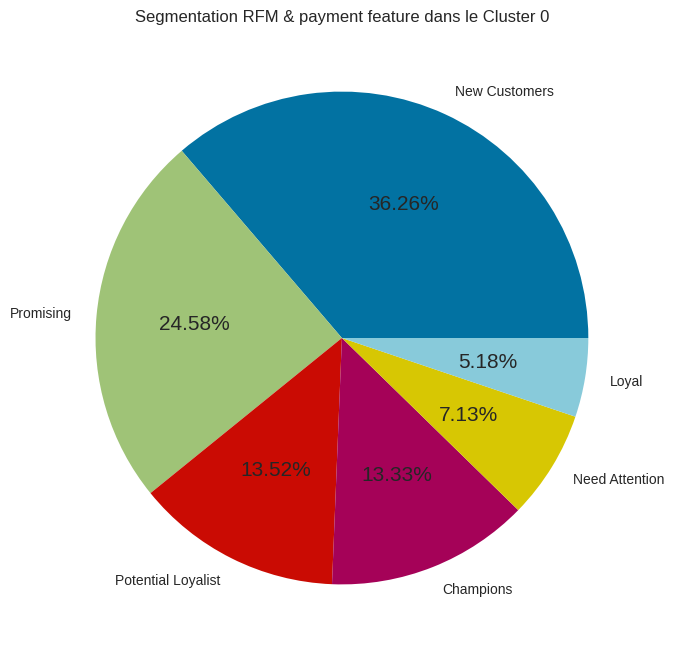

In [163]:
#Affichons les segment appartenants au cluster 0
rfm_pay_cluster_0 = rfm_pay[rfm_pay['Clusters']==0]
rfm_pay_cluster_0.Segment.unique()
#on compte les valeurs segments
rfm_pay_cluster_0['Segment'].value_counts()
#on attribue a labels les valeurs uniques (segments)
labels_rfm_pay_0 = rfm_pay_cluster_0.Segment.unique()
#pieplot
plt.pie(rfm_pay_cluster_0['Segment'].value_counts(),
        labels = labels_rfm_pay_0 ,
        autopct = lambda x: str(round(x, 2))
                   + '%', normalize = True)
plt.title ("Segmentation RFM & payment feature dans le Cluster 0")    
plt.show()


<Axes: >

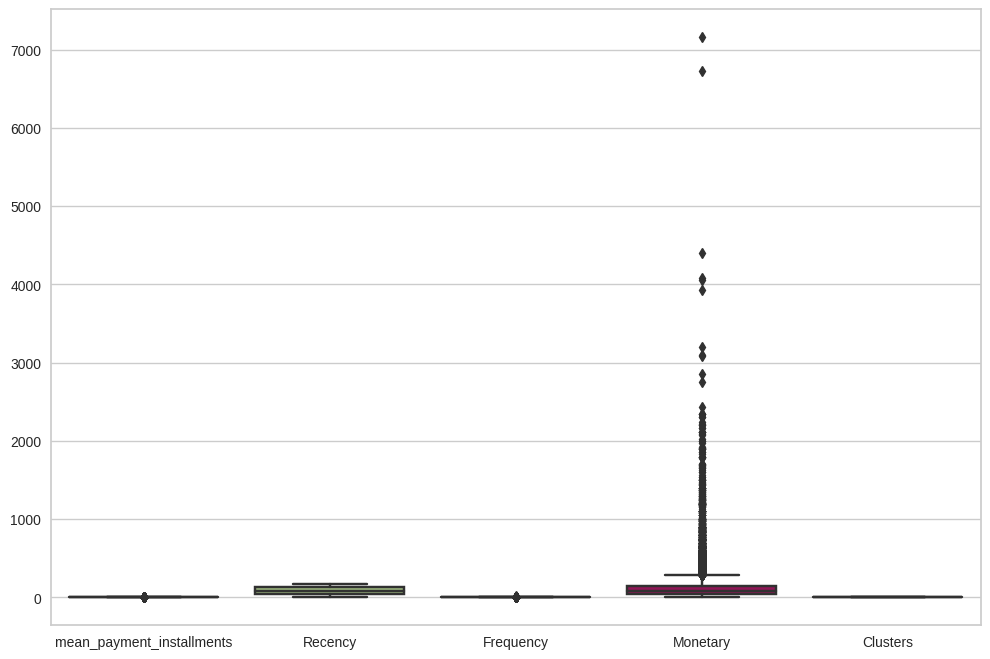

In [290]:
sns.boxplot(data = rfm_pay_cluster_0)

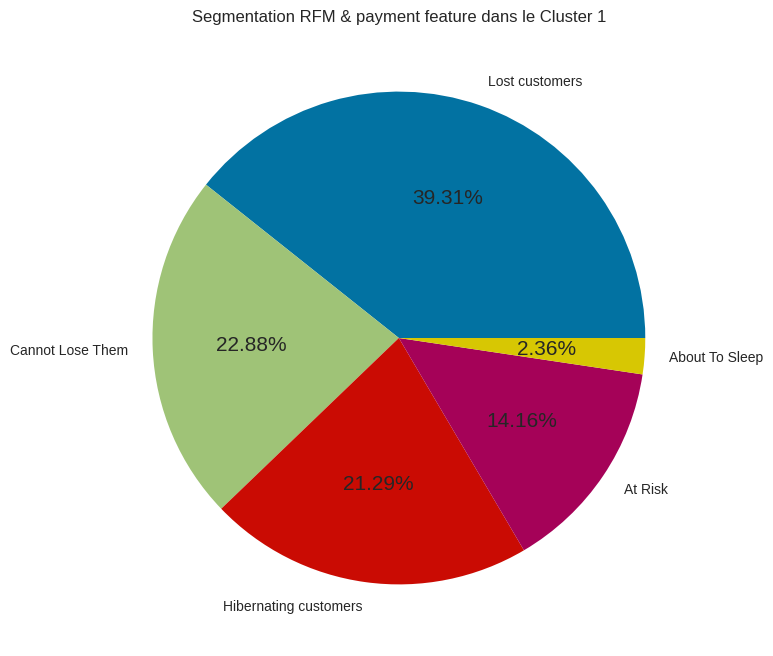

In [164]:
#Affichons les segment appartenants au cluster 1
rfm_pay_cluster_1 = rfm_pay[rfm_pay['Clusters']==1]
rfm_pay_cluster_1.Segment.unique()
#on compte les valeurs segments
rfm_pay_cluster_1['Segment'].value_counts()
#on attribue a labels les valeurs uniques (segments)
labels_rfm_pay_1 = rfm_pay_cluster_1.Segment.unique()
#pieplot
plt.pie(rfm_pay_cluster_1['Segment'].value_counts(),
        labels = labels_rfm_pay_1 ,
        autopct = lambda x: str(round(x, 2))
                   + '%', normalize = True)
plt.title ("Segmentation RFM & payment feature dans le Cluster 1")    
plt.show()

<Axes: >

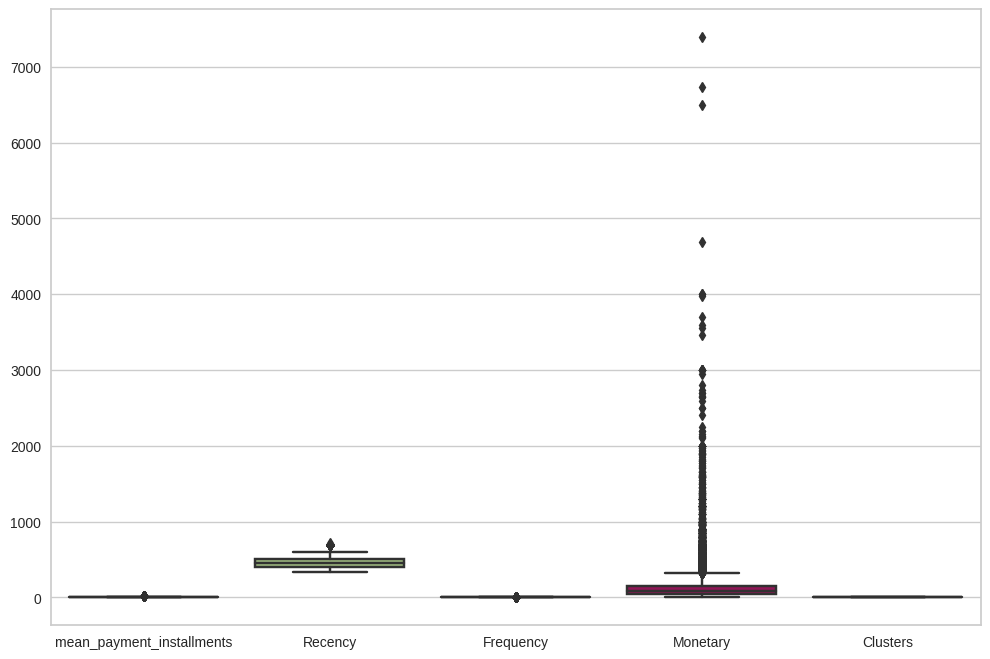

In [292]:
sns.boxplot(data = rfm_pay_cluster_1)

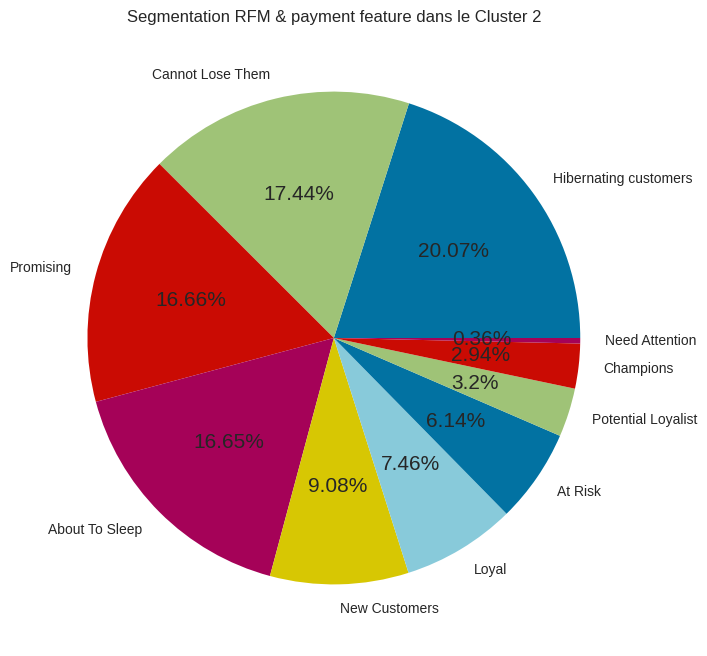

In [165]:
#Affichons les segment appartenants au cluster 2
rfm_pay_cluster_2 = rfm_pay[rfm_pay['Clusters']==2]
rfm_pay_cluster_2.Segment.unique()
#on compte les valeurs segments
rfm_pay_cluster_2['Segment'].value_counts()
#on attribue a labels les valeurs uniques (segments)
labels_rfm_pay_2 = rfm_pay_cluster_2.Segment.unique()
#pieplot
plt.pie(rfm_pay_cluster_2['Segment'].value_counts(),
        labels = labels_rfm_pay_2 ,
        autopct = lambda x: str(round(x, 2))
                   + '%', normalize = True)
plt.title ("Segmentation RFM & payment feature dans le Cluster 2")    
plt.show()

<Axes: >

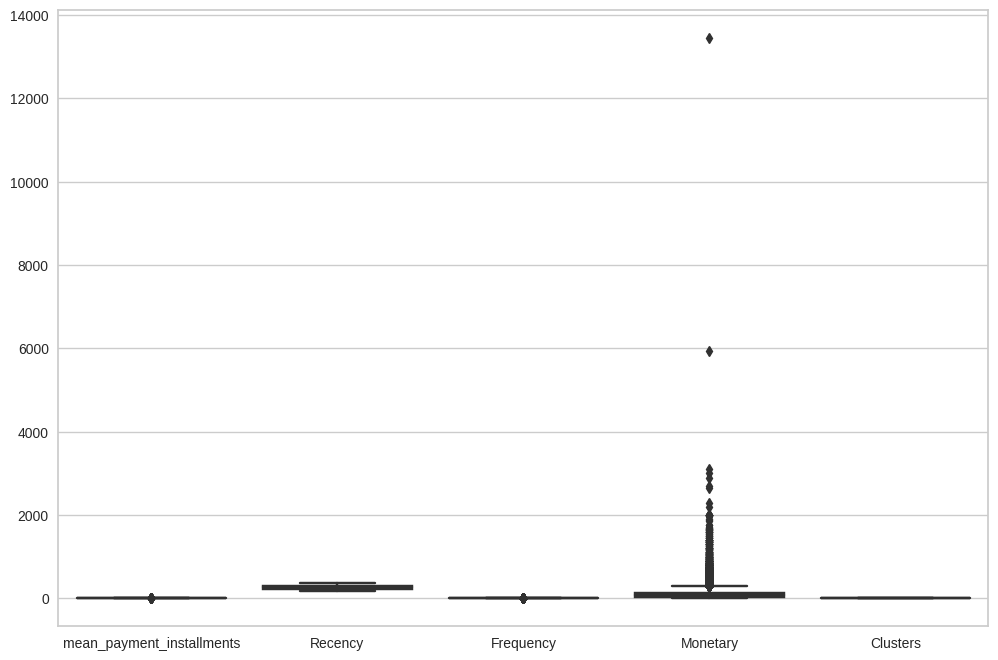

In [293]:
sns.boxplot(data = rfm_pay_cluster_2)

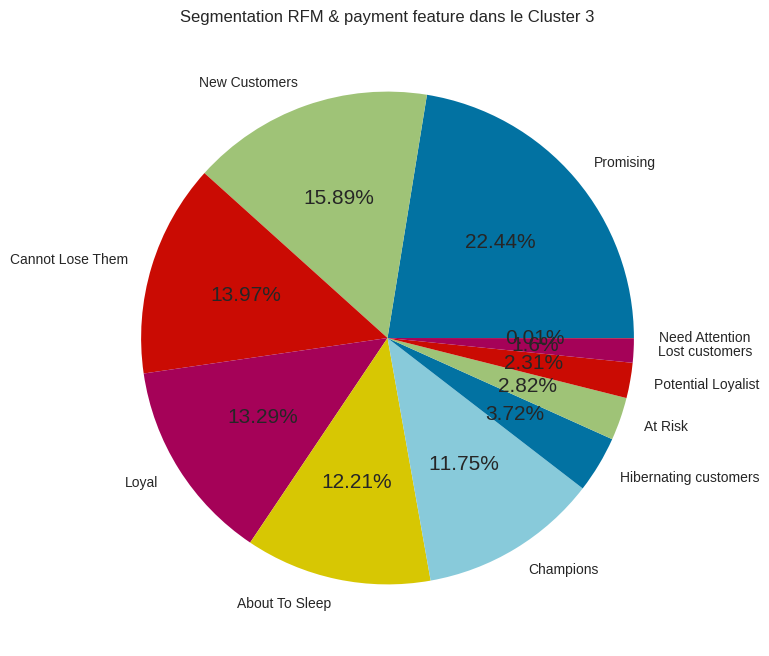

In [166]:
#Affichons les segment appartenants au cluster 3
rfm_pay_cluster_3 = rfm_pay[rfm_pay['Clusters']==3]
rfm_pay_cluster_3.Segment.unique()
#on compte les valeurs segments
rfm_pay_cluster_3['Segment'].value_counts()
#on attribue a labels les valeurs uniques (segments)
labels_rfm_pay_3 = rfm_pay_cluster_3.Segment.unique()
#pieplot
plt.pie(rfm_pay_cluster_3['Segment'].value_counts(),
        labels = labels_rfm_pay_3 ,
        autopct = lambda x: str(round(x, 2))
                   + '%', normalize = True)
plt.title ("Segmentation RFM & payment feature dans le Cluster 3")    
plt.show()

<Axes: >

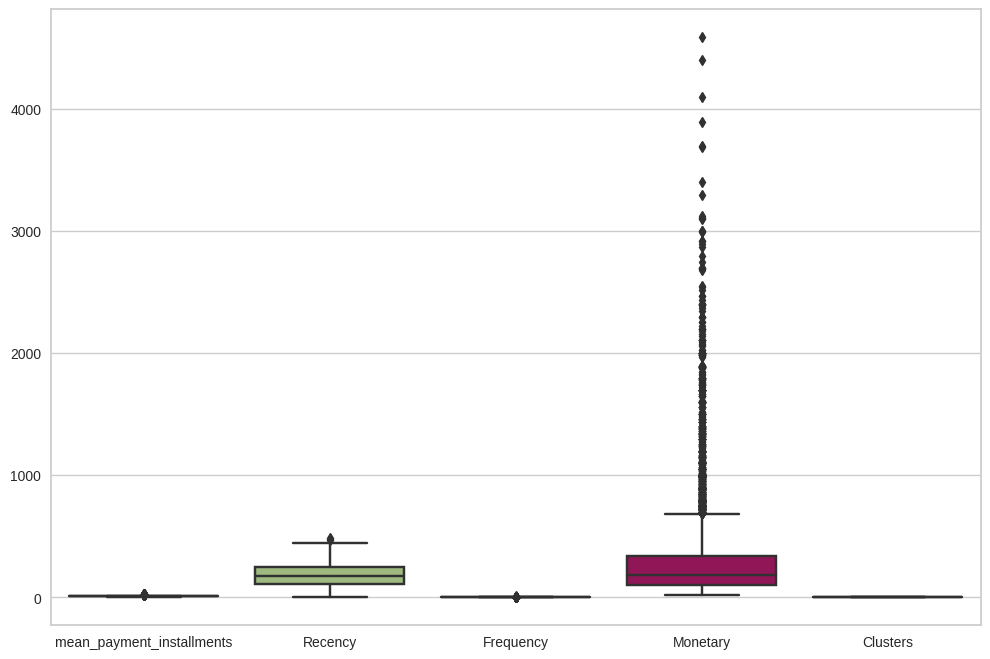

In [294]:
sns.boxplot(data = rfm_pay_cluster_3)

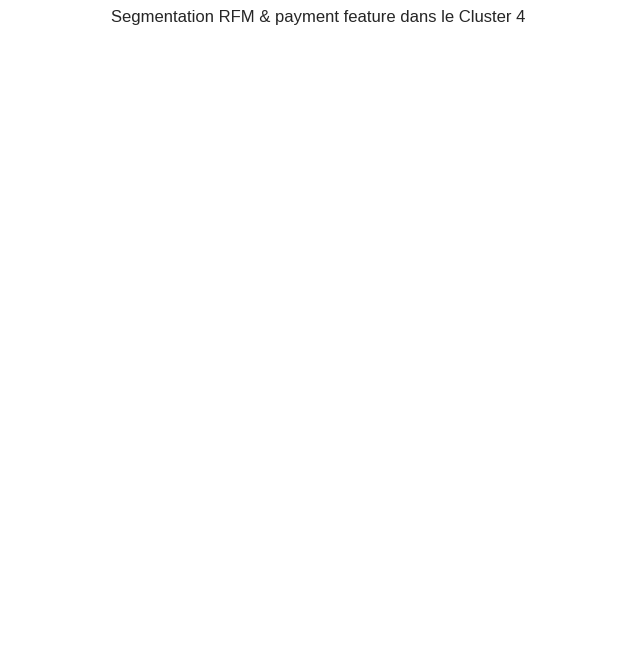

In [167]:
#Affichons les segment appartenants au cluster 4
rfm_pay_cluster_4 = rfm_pay[rfm_pay['Clusters']==4]
rfm_pay_cluster_4.Segment.unique()
#on compte les valeurs segments
rfm_pay_cluster_4['Segment'].value_counts()
#on attribue a labels les valeurs uniques (segments)
labels_rfm_pay_4 = rfm_pay_cluster_4.Segment.unique()
#pieplot
plt.pie(rfm_pay_cluster_4['Segment'].value_counts(),
        labels = labels_rfm_pay_4 ,
        autopct = lambda x: str(round(x, 2))
                   + '%', normalize = True)
plt.title ("Segmentation RFM & payment feature dans le Cluster 4")    
plt.show()

<Axes: >

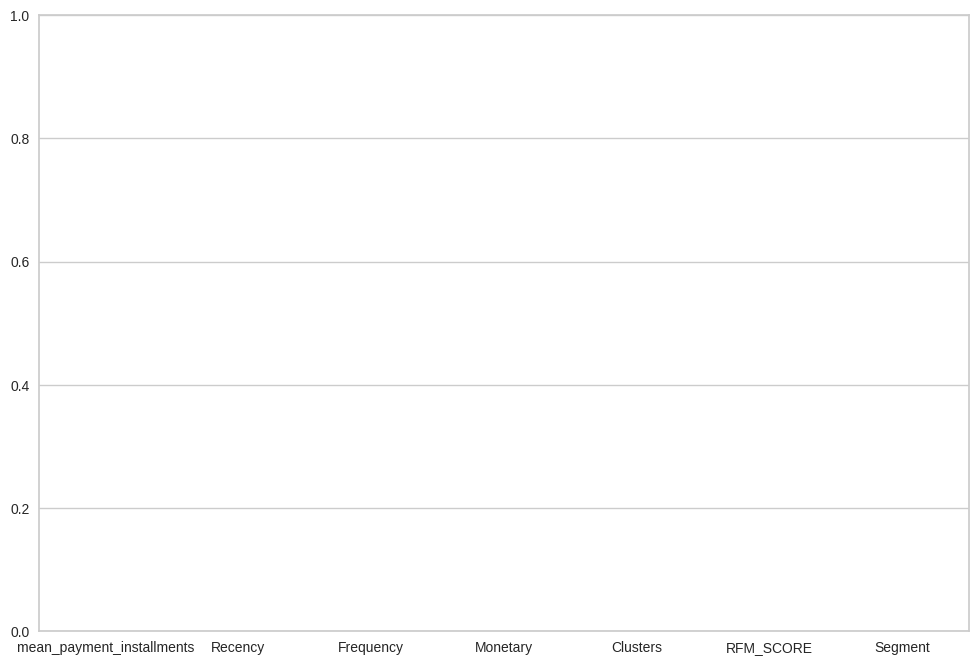

In [295]:
sns.boxplot(data = rfm_pay_cluster_4)

meme avec 5 clusters de definit, nous en avons que 4. Cluster 4 est vide

In [168]:
rfm_pay.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93358 entries, 0 to 93357
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   mean_payment_installments  93358 non-null  float64 
 1   Recency                    93358 non-null  int64   
 2   Frequency                  93358 non-null  int64   
 3   Monetary                   93358 non-null  float64 
 4   Clusters                   93358 non-null  int32   
 5   recency_score              93358 non-null  category
 6   frequency_score            93358 non-null  category
 7   monetary_score             93358 non-null  category
 8   RFM_SCORE                  93358 non-null  object  
 9   Segment                    93358 non-null  object  
dtypes: category(3), float64(2), int32(1), int64(2), object(2)
memory usage: 5.6+ MB


In [169]:
rfm_pay.to_csv('/content/drive/MyDrive/OC: Data Science/Datasets/Projet 5/seg_rfm_pay.csv', index=False)



---



---



# RFM + Review


---



---






In [170]:
data_review = data.drop(['nb_orders', 'total_spend', 'freight_value', 
                          'mean_payment_installments', 'total_items',
                           'mean_nb_items', 'min', 'max', 'order_mean_delay', 'customer_id'], 
                        axis = 1)

In [171]:
rfm_rev = rfm.merge(data_review, on = 'customer_unique_id', how = 'left' )

In [172]:
rfm_rev.head()

customer_unique_id LastPurchaseDate  Recency  Frequency  \
0  0000366f3b9a7992bf8c76cfdf3221e2       2018-05-10      111          1   
1  0000b849f77a49e4a4ce2b2a4ca5be3f       2018-05-07      114          1   
2  0000f46a3911fa3c0805444483337064       2017-03-10      537          1   
3  0000f6ccb0745a6a4b88665a16c9f078       2017-10-12      321          1   
4  0004aac84e0df4da2b147fca70cf8255       2017-11-14      288          1   

   Monetary recency_score frequency_score monetary_score RFM_SCORE  \
0    129.90             4               1              4       414   
1     18.90             4               1              1       411   
2     69.00             1               1              2       112   
3     25.99             2               1              1       211   
4    180.00             2               1              5       215   

                 Segment  mean_review_score  
0              Promising                5.0  
1          New Customers                4.0  
2         Lost customers                3.0  
3  Hibernating customers                4.0  
4       Cannot Lose Them                5.0

In [173]:
rfm_rev.drop(['customer_unique_id',	'LastPurchaseDate',	'recency_score', 
              'frequency_score', 'monetary_score', 	'RFM_SCORE'	, 'Segment'],
              axis = 1, inplace = True)

In [174]:
categorical_features_rev = list(rfm_rev.select_dtypes(exclude=['int64', 'float64', 'uint8']).columns)
numerical_features_rev= list(rfm_rev.select_dtypes(include=['int64','float64', 'uint8']).columns)
print('categorical_features  : ', categorical_features_rev)
print("*****")
print('numerical_features: ', numerical_features_rev)
print("*****")
len(numerical_features_rev)

categorical_features  :  []
*****
numerical_features:  ['Recency', 'Frequency', 'Monetary', 'mean_review_score']
*****


4

In [175]:
scaler = MinMaxScaler()

preprocessor = ColumnTransformer([('scaler', scaler, numerical_features_rev)])

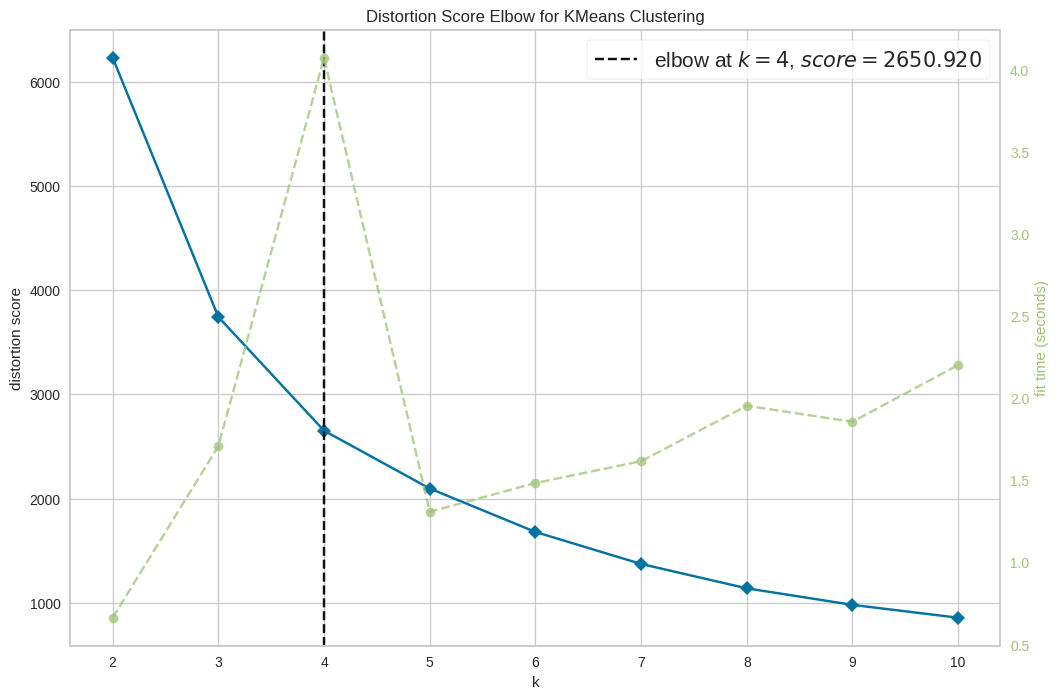

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [176]:
X = rfm_rev.copy()
# Elbow method
kmeans_visualizer = Pipeline([("preprocessor", preprocessor),
                               ("kelbowvisualizer", KElbowVisualizer(KMeans(),
                                                                     K=(4,12)))])
kmeans_visualizer.fit(X)
kmeans_visualizer.named_steps['kelbowvisualizer'].show()

In [177]:
# KMeans Pipeline with best K
kmeans_model = Pipeline([("preprocessor", preprocessor),
                         ("kmeans", KMeans(K))])
kmeans_model.fit(X)

# Kmeans labels
kmeans_labels_rev = kmeans_model.named_steps['kmeans'].labels_
rfm_rev["Clusters"] = kmeans_labels_rev

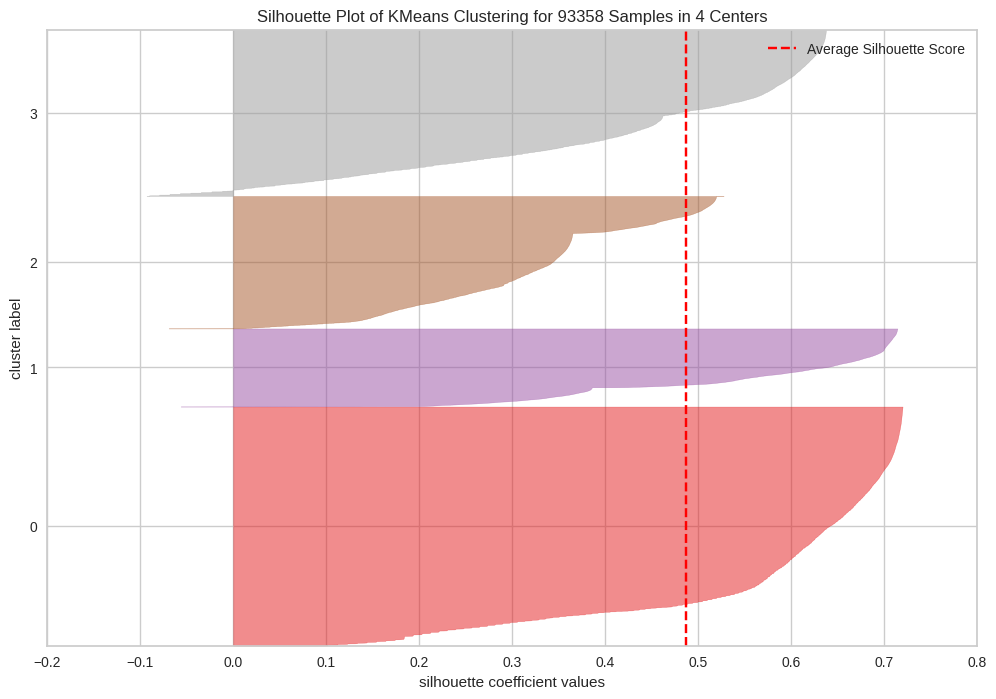

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 93358 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [178]:
K = kmeans_visualizer.named_steps['kelbowvisualizer'].elbow_value_


silhouette_visualizer = Pipeline([("preprocessor", preprocessor),
                                   ("silhouettevisualizer", 
                                    SilhouetteVisualizer(KMeans(K)))])
silhouette_visualizer.fit(X)
silhouette_visualizer.named_steps['silhouettevisualizer'].show()

On retrouve les 4 clusters mais aucune homegeneite

In [179]:
rfm_rev

Recency  Frequency  Monetary  mean_review_score  Clusters
0          111          1    129.90                5.0         0
1          114          1     18.90                4.0         4
2          537          1     69.00                3.0         3
3          321          1     25.99                4.0         3
4          288          1    180.00                5.0         2
...        ...        ...       ...                ...       ...
93353      447          1   1570.00                5.0         2
93354      262          1     64.89                4.0         4
93355      568          1     89.90                5.0         2
93356      119          1    115.00                5.0         0
93357      484          1     56.99                5.0         2

[93358 rows x 5 columns]

In [180]:
rfm_rev.Clusters.unique()

array([0, 4, 3, 2, 1], dtype=int32)

In [181]:
kmeans_clusters_means_rev = rfm_rev.groupby("Clusters").mean().reset_index()
kmeans_clusters_means_rev

Clusters     Recency  Frequency    Monetary  mean_review_score
0         0  122.468497   1.038036  138.113177           4.996765
1         1  233.625235   1.022522  164.325148           1.239230
2         2  387.899019   1.029980  141.627541           4.997779
3         3  392.281515   1.029304  134.980487           3.680606
4         4  133.329238   1.040582  136.291700           3.703163

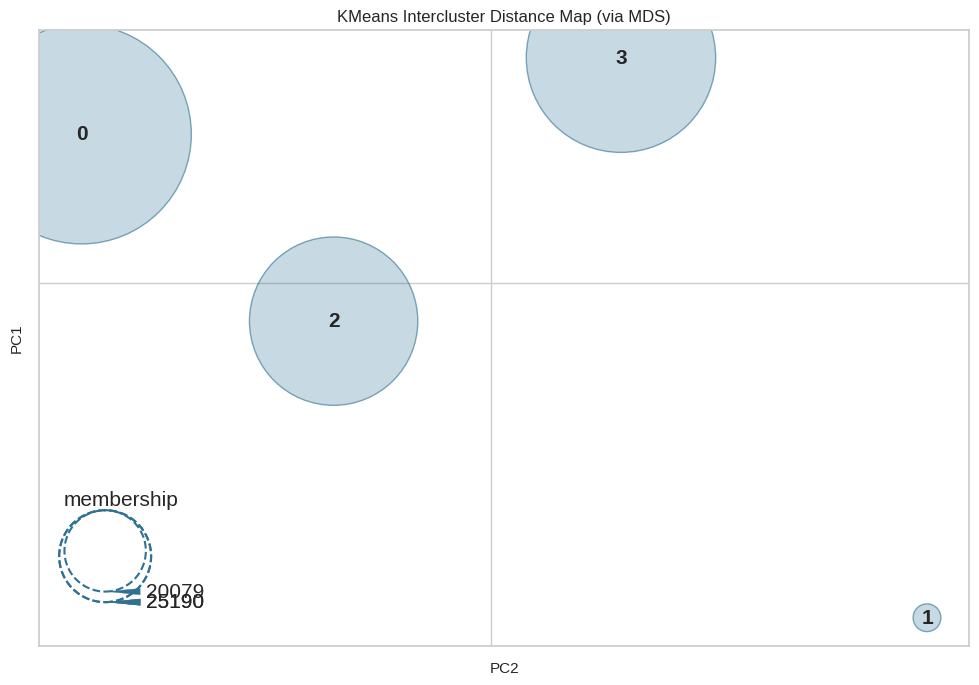

<Axes: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [182]:
distance_visualizer = Pipeline([
                                 ("preprocessor", preprocessor),
                                 ("distancevisualizer", InterclusterDistance(KMeans(K)))])
distance_visualizer.fit(X)
distance_visualizer.named_steps['distancevisualizer'].show()

In [183]:
rfm_rev

Recency  Frequency  Monetary  mean_review_score  Clusters
0          111          1    129.90                5.0         0
1          114          1     18.90                4.0         4
2          537          1     69.00                3.0         3
3          321          1     25.99                4.0         3
4          288          1    180.00                5.0         2
...        ...        ...       ...                ...       ...
93353      447          1   1570.00                5.0         2
93354      262          1     64.89                4.0         4
93355      568          1     89.90                5.0         2
93356      119          1    115.00                5.0         0
93357      484          1     56.99                5.0         2

[93358 rows x 5 columns]

In [184]:
#Scoring
rfm_rev["recency_score"]  = pd.qcut(rfm_rev['Recency'], 5, labels=[5, 4, 3, 2, 1])
rfm_rev["frequency_score"] = pd.qcut(rfm_rev['Frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
rfm_rev["monetary_score"] = pd.qcut(rfm_rev['Monetary'], 5, labels=[1, 2, 3, 4, 5])

rfm_rev['RFM_SCORE'] = rfm_rev.recency_score.astype(str)+ rfm_rev.frequency_score.astype(str) + rfm_rev.monetary_score.astype(str)

#Segmentation
rfm_rev['Segment'] = rfm_rev['recency_score'].astype(str) + rfm_rev['frequency_score'].astype(str) + rfm_rev['monetary_score'].astype(str)
rfm_rev['Segment'] = rfm_rev['Segment'].replace(seg_map, regex=True)
rfm_rev.head()

Recency  Frequency  Monetary  mean_review_score  Clusters recency_score  \
0      111          1    129.90                5.0         0             4   
1      114          1     18.90                4.0         4             4   
2      537          1     69.00                3.0         3             1   
3      321          1     25.99                4.0         3             2   
4      288          1    180.00                5.0         2             2   

  frequency_score monetary_score RFM_SCORE                Segment  
0               1              4       414              Promising  
1               1              1       411          New Customers  
2               1              2       112         Lost customers  
3               1              1       211  Hibernating customers  
4               1              5       215       Cannot Lose Them

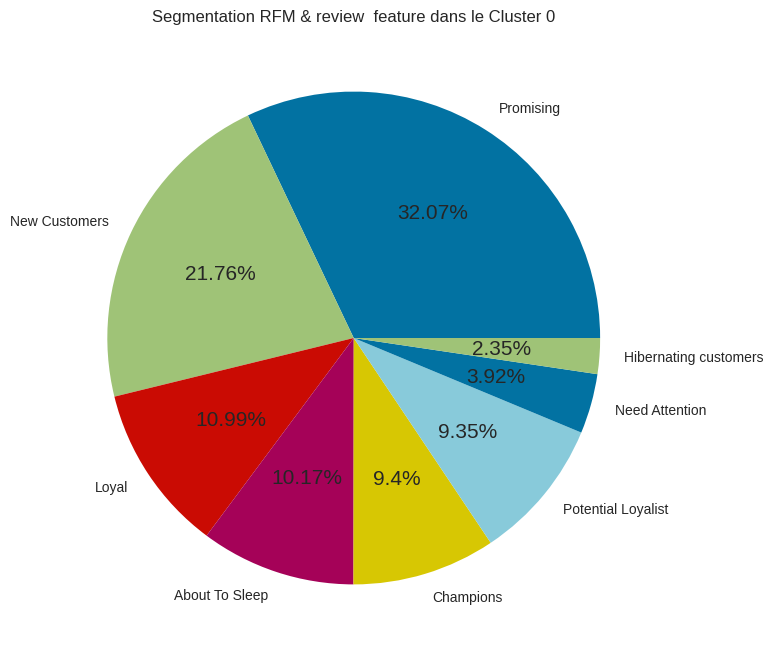

In [185]:
#Affichons les segment appartenants au cluster 0
rfm_rev_cluster_0 = rfm_rev[rfm_rev['Clusters']==0]
rfm_rev_cluster_0.Segment.unique()
rfm_rev_cluster_0['Segment'].value_counts()
labels_rfm_rev_0 = rfm_rev_cluster_0.Segment.unique()

plt.pie(rfm_rev_cluster_0['Segment'].value_counts(),
        labels = labels_rfm_rev_0 ,
        autopct = lambda x: str(round(x, 2))
                   + '%', normalize = True)
plt.title ("Segmentation RFM & review  feature dans le Cluster 0")    
plt.show()

<Axes: >

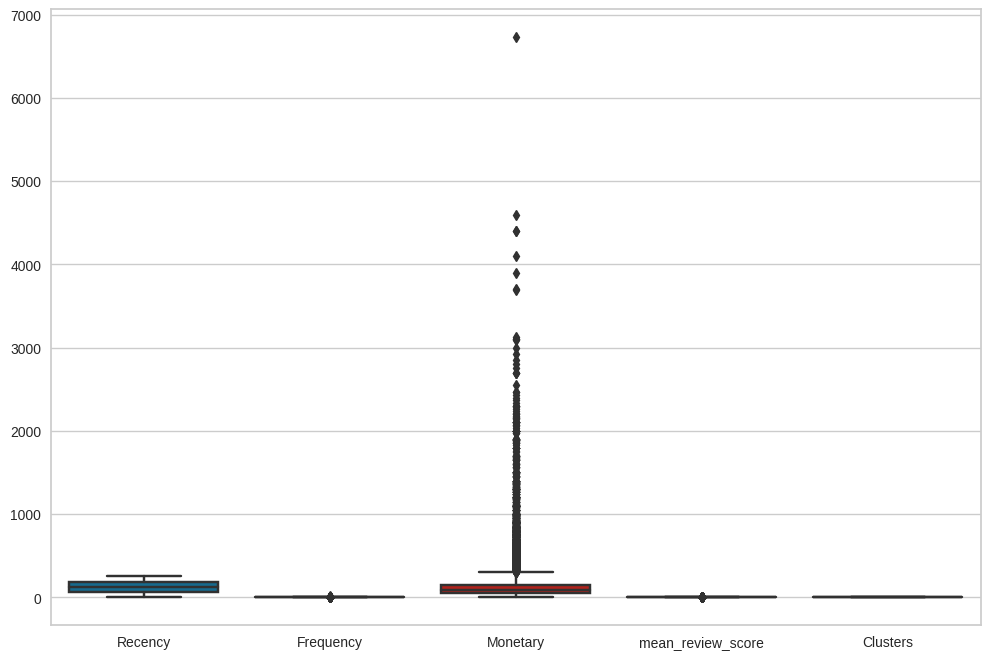

In [296]:
sns.boxplot(data = rfm_rev_cluster_0)

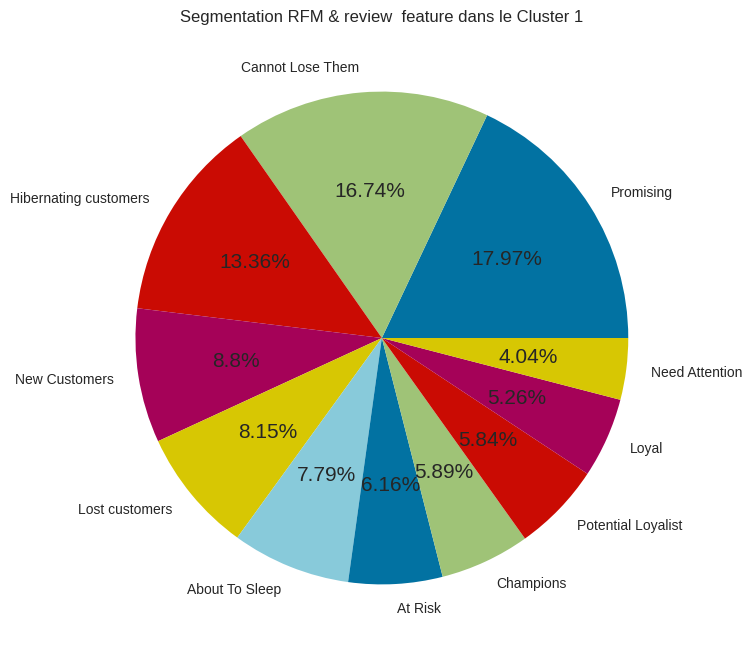

In [186]:
#Affichons les segment appartenants au cluster 1
rfm_rev_cluster_1 = rfm_rev[rfm_rev['Clusters']==1]
rfm_rev_cluster_1.Segment.unique()
rfm_rev_cluster_1['Segment'].value_counts()
labels_rfm_rev_1 = rfm_rev_cluster_1.Segment.unique()

plt.pie(rfm_rev_cluster_1['Segment'].value_counts(),
        labels = labels_rfm_rev_1 ,
        autopct = lambda x: str(round(x, 2))
                   + '%', normalize = True)
plt.title ("Segmentation RFM & review  feature dans le Cluster 1")    
plt.show()

<Axes: >

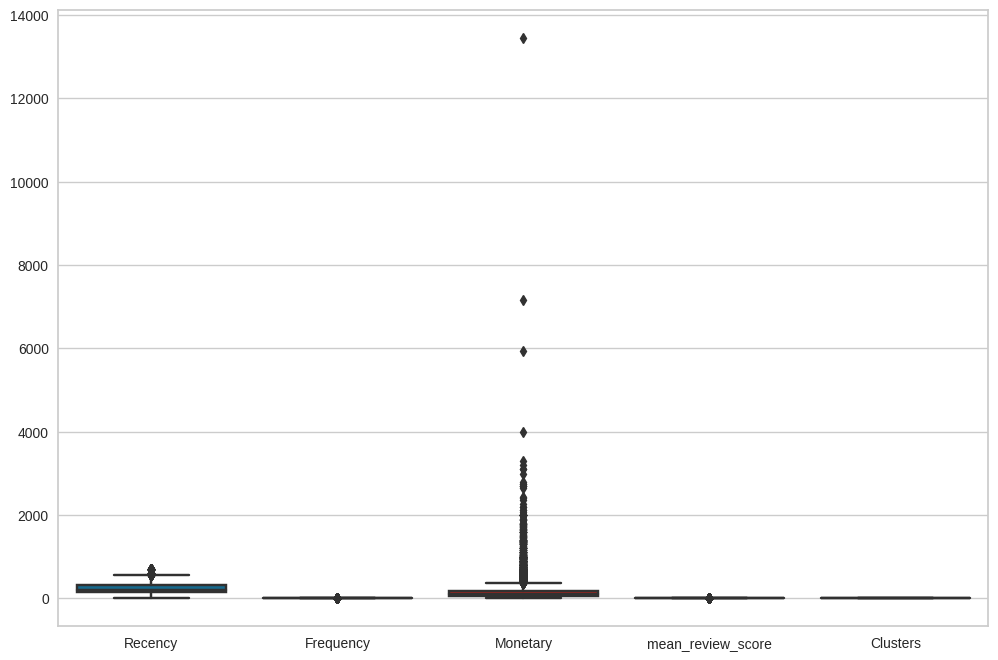

In [297]:
sns.boxplot(data = rfm_rev_cluster_1)

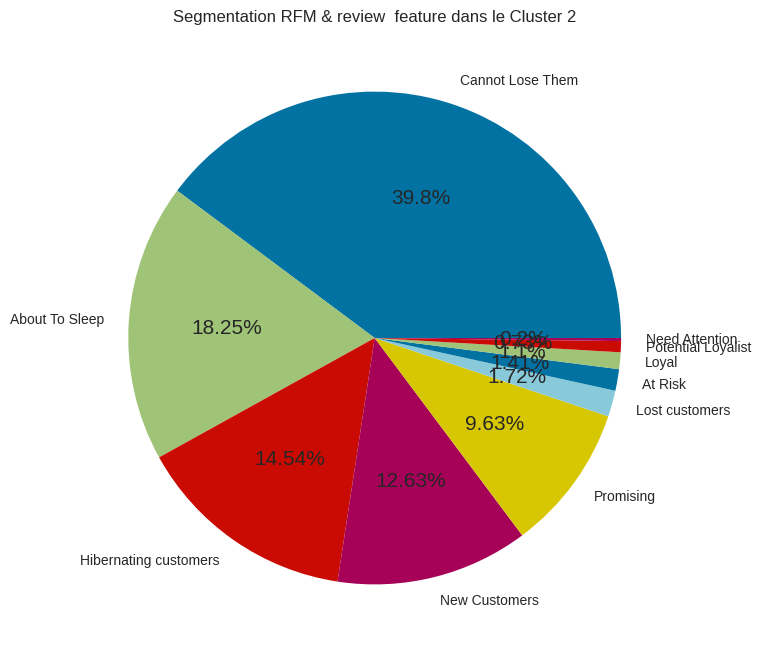

In [187]:
#Affichons les segment appartenants au cluster 2
rfm_rev_cluster_2 = rfm_rev[rfm_rev['Clusters']==2]
rfm_rev_cluster_2.Segment.unique()
rfm_rev_cluster_2['Segment'].value_counts()
labels_rfm_rev_2 = rfm_rev_cluster_2.Segment.unique()

plt.pie(rfm_rev_cluster_2['Segment'].value_counts(),
        labels = labels_rfm_rev_2 ,
        autopct = lambda x: str(round(x, 2))
                   + '%', normalize = True)
plt.title ("Segmentation RFM & review  feature dans le Cluster 2")    
plt.show()

<Axes: >

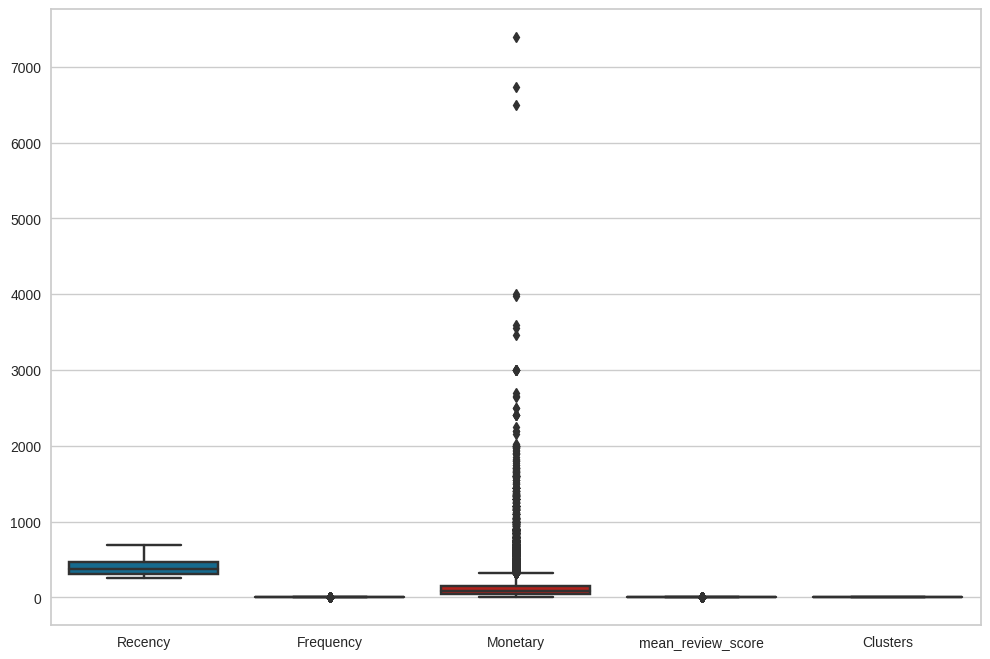

In [298]:
sns.boxplot(data = rfm_rev_cluster_2)

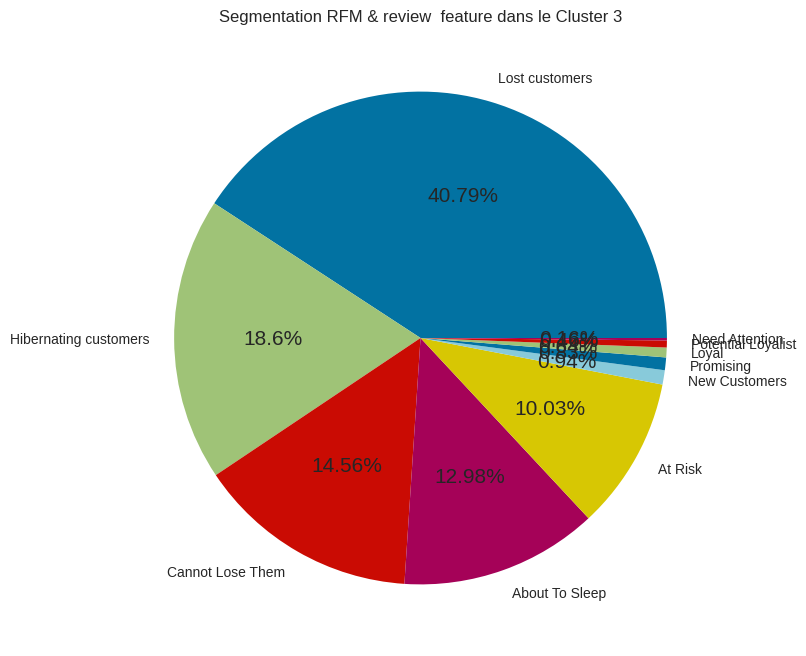

In [188]:
#Affichons les segment appartenants au cluster 3
rfm_rev_cluster_3 = rfm_rev[rfm_rev['Clusters']==3]
rfm_rev_cluster_3.Segment.unique()
rfm_rev_cluster_3['Segment'].value_counts()
labels_rfm_rev_3 = rfm_rev_cluster_3.Segment.unique()

plt.pie(rfm_rev_cluster_3['Segment'].value_counts(),
        labels = labels_rfm_rev_3 ,
        autopct = lambda x: str(round(x, 2))
                   + '%', normalize = True)
plt.title ("Segmentation RFM & review  feature dans le Cluster 3")    
plt.show()

<Axes: >

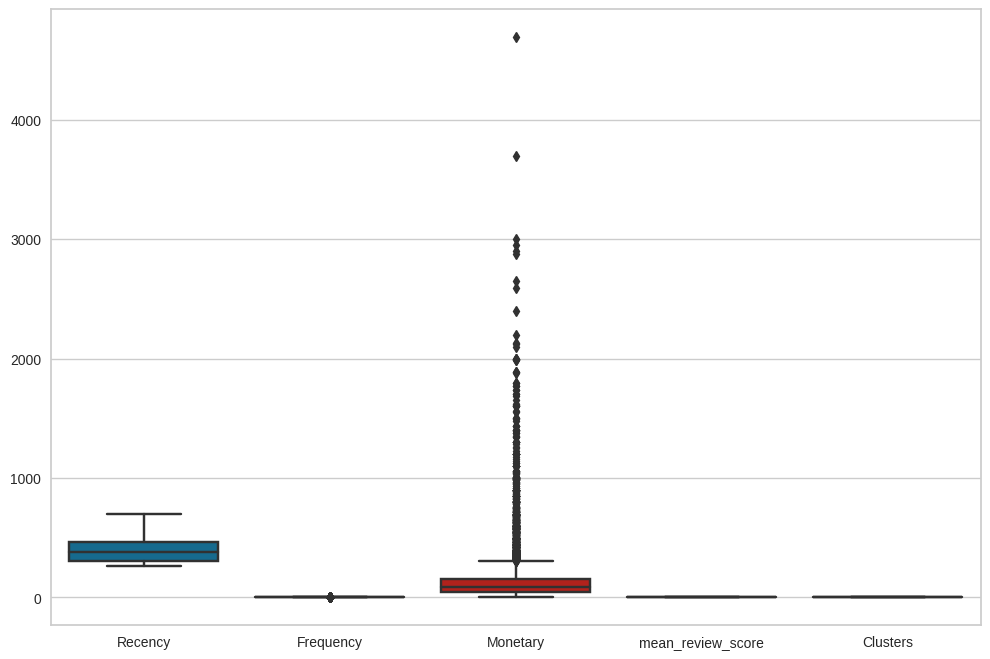

In [299]:
sns.boxplot(data = rfm_rev_cluster_3)

In [189]:
rfm_rev.to_csv('/content/drive/MyDrive/OC: Data Science/Datasets/Projet 5/seg_rfm_rev.csv', index=False)

# rfm & features

RFM + payment + review

In [190]:
rfm_features = data.merge(rfm_2, on = 'customer_unique_id', how = 'left' )

In [191]:
data.columns

Index(['customer_unique_id', 'nb_orders', 'total_spend', 'freight_value',
       'mean_payment_installments', 'mean_review_score', 'total_items',
       'mean_nb_items', 'min', 'max', 'order_mean_delay', 'customer_id'],
      dtype='object')

In [192]:
rfm_features

customer_unique_id  nb_orders  total_spend  \
0      0000366f3b9a7992bf8c76cfdf3221e2          1       129.90   
1      0000b849f77a49e4a4ce2b2a4ca5be3f          1        18.90   
2      0000f46a3911fa3c0805444483337064          1        69.00   
3      0000f6ccb0745a6a4b88665a16c9f078          1        25.99   
4      0004aac84e0df4da2b147fca70cf8255          1       180.00   
...                                 ...        ...          ...   
93353  fffcf5a5ff07b0908bd4e2dbc735a684          1      1570.00   
93354  fffea47cd6d3cc0a88bd621562a9d061          1        64.89   
93355  ffff371b4d645b6ecea244b27531430a          1        89.90   
93356  ffff5962728ec6157033ef9805bacc48          1       115.00   
93357  ffffd2657e2aad2907e67c3e9daecbeb          1        56.99   

       freight_value  mean_payment_installments  mean_review_score  \
0              12.00                        8.0                5.0   
1               8.29                        1.0                4.0   
2              17.22                        8.0                3.0   
3              17.63                        4.0                4.0   
4              16.89                        6.0                5.0   
...              ...                        ...                ...   
93353         497.42                       10.0                5.0   
93354          19.69                        1.0                4.0   
93355          22.56                        1.0                5.0   
93356          18.69                        5.0                5.0   
93357          14.57                        4.0                5.0   

       total_items  mean_nb_items                  min                  max  \
0              1.0            1.0  2018-05-10 10:56:27  2018-05-10 10:56:27   
1              1.0            1.0  2018-05-07 11:11:27  2018-05-07 11:11:27   
2              1.0            1.0  2017-03-10 21:05:03  2017-03-10 21:05:03   
3              1.0            1.0  2017-10-12 20:29:41  2017-10-12 20:29:41   
4              1.0            1.0  2017-11-14 19:45:42  2017-11-14 19:45:42   
...            ...            ...                  ...                  ...   
93353          2.0            2.0  2017-06-08 21:00:36  2017-06-08 21:00:36   
93354          1.0            1.0  2017-12-10 20:07:56  2017-12-10 20:07:56   
93355          1.0            1.0  2017-02-07 15:49:16  2017-02-07 15:49:16   
93356          1.0            1.0  2018-05-02 15:17:41  2018-05-02 15:17:41   
93357          1.0            1.0  2017-05-02 20:18:45  2017-05-02 20:18:45   

       order_mean_delay                       customer_id  Recency  Frequency  \
0                 111.0  fadbb3709178fc513abc1b2670aa1ad2      111          1   
1                 114.0  4cb282e167ae9234755102258dd52ee8      114          1   
2                 536.0  9b3932a6253894a02c1df9d19004239f      537          1   
3                 320.0  914991f0c02ef0843c0e7010c819d642      321          1   
4                 287.0  47227568b10f5f58a524a75507e6992c      288          1   
...                 ...                               ...      ...        ...   
93353             446.0  74be082247cd677a147d83ee670e9d53      447          1   
93354             261.0  0ecf8e0a08148af0bf313184f167670a      262          1   
93355             567.0  27f584b0f1dc4e610065c240f68b6be0      568          1   
93356             118.0  832a3b0254347d409512ae92eaf154a6      119          1   
93357             483.0  70bc4d9cf2bbeea3f7b09798370f5884      484          1   

       Monetary                Segment  Cluster  
0        129.90              Promising        3  
1         18.90          New Customers        3  
2         69.00         Lost customers        2  
3         25.99  Hibernating customers        0  
4        180.00       Cannot Lose Them        0  
...         ...                    ...      ...  
93353   1570.00       Cannot Lose Them        2  
93354     64.89     Potential Loyalist        0  
933

In [193]:
rfm_features.shape

(93358, 17)

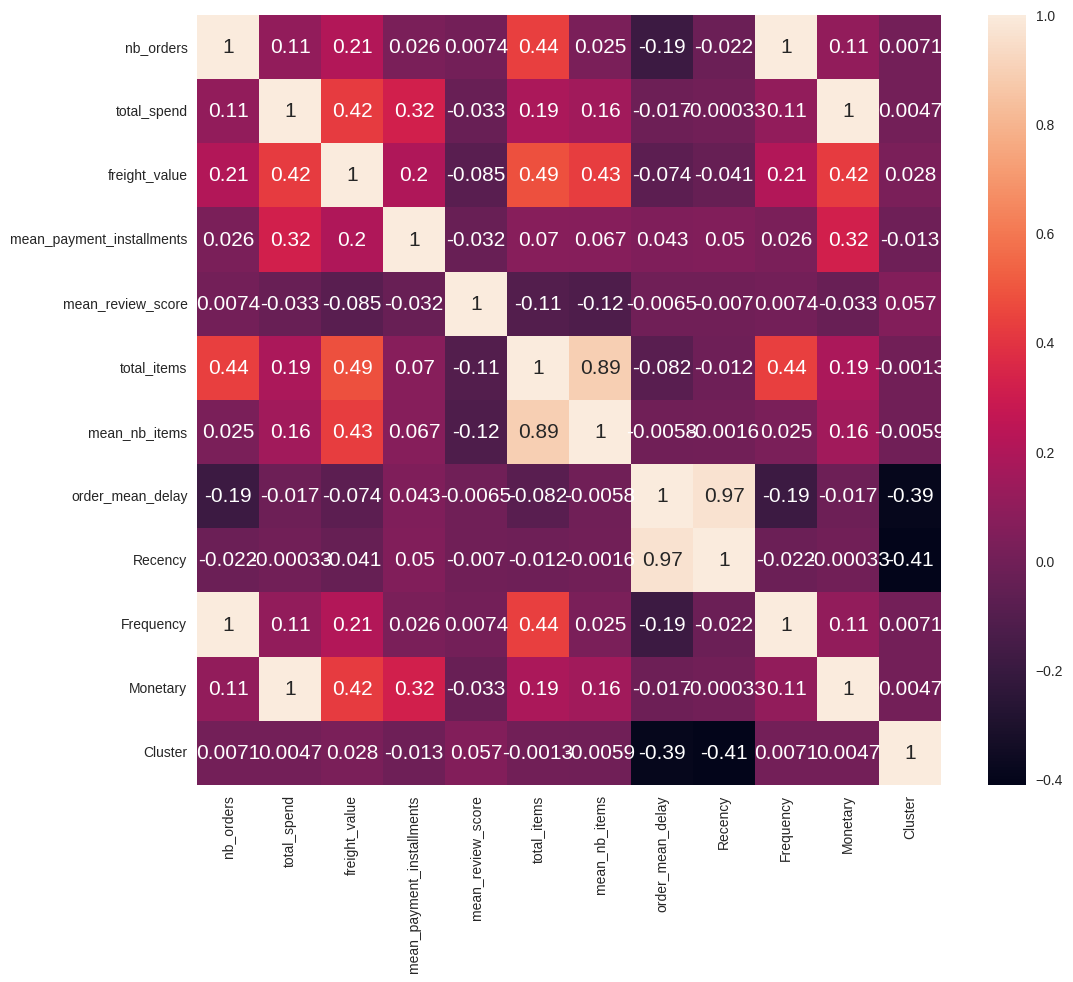

In [194]:
corr(rfm_features)

In [195]:
rfm_features.columns

Index(['customer_unique_id', 'nb_orders', 'total_spend', 'freight_value',
       'mean_payment_installments', 'mean_review_score', 'total_items',
       'mean_nb_items', 'min', 'max', 'order_mean_delay', 'customer_id',
       'Recency', 'Frequency', 'Monetary', 'Segment', 'Cluster'],
      dtype='object')

In [196]:
rfm_features_1 = rfm_features.drop(['customer_unique_id', 'nb_orders', 'total_spend',
                                  'freight_value', 'total_items', 'mean_nb_items',
                                  'min', 'max', 'order_mean_delay', 'customer_id',
                                     'Segment', 'Cluster'],  axis =1)

In [197]:
rfm_features_1.shape

(93358, 5)

In [198]:
rfm_features_1.columns

Index(['mean_payment_installments', 'mean_review_score', 'Recency',
       'Frequency', 'Monetary'],
      dtype='object')

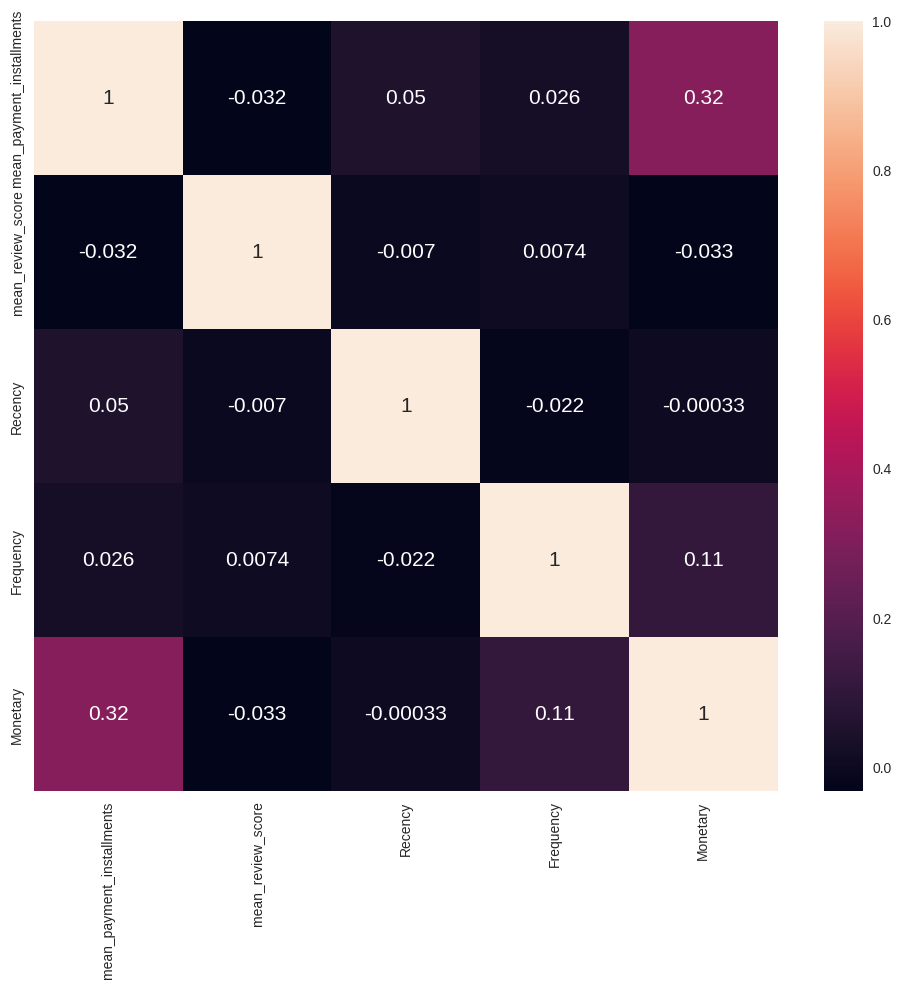

In [199]:
corr(rfm_features_1)

In [200]:
categorical_features = list(rfm_features_1.select_dtypes(exclude=['int64', 'float64', 'uint8']).columns)
numerical_features = list(rfm_features_1.select_dtypes(include=['int64','float64', 'uint8']).columns)
print('categorical_features  : ', categorical_features)
print("*****")
print('numerical_features: ', numerical_features)
print("*****")
len(numerical_features)

categorical_features  :  []
*****
numerical_features:  ['mean_payment_installments', 'mean_review_score', 'Recency', 'Frequency', 'Monetary']
*****


5

In [201]:
scaler = MinMaxScaler()

preprocessor = ColumnTransformer([('scaler', scaler, numerical_features)] )

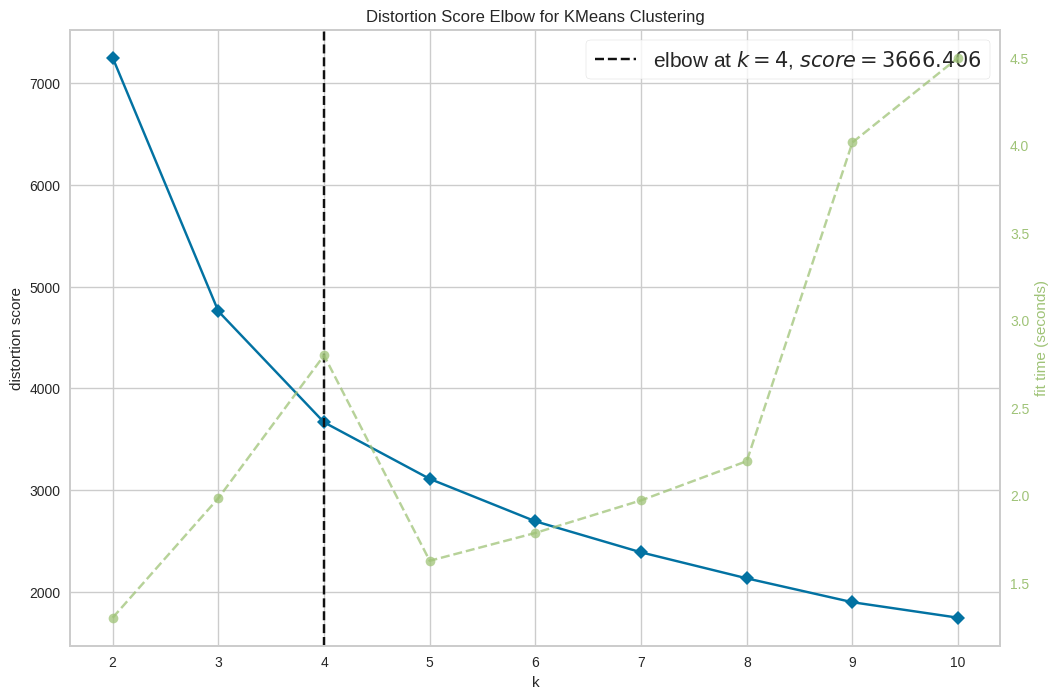

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [202]:
X = rfm_features_1.copy()
# Elbow method
kmeans_visualizer = Pipeline([("preprocessor", preprocessor),
                              ("kelbowvisualizer", KElbowVisualizer(KMeans(),
                                                                    K=(4,12)))])
kmeans_visualizer.fit(X)
kmeans_visualizer.named_steps['kelbowvisualizer'].show()

In [203]:
# KMeans Pipeline with best K
kmeans_model = Pipeline([("preprocessor", preprocessor),
                         ("kmeans", KMeans(K))])
kmeans_model.fit(X)

# Kmeans labels
kmeans_labels_features = kmeans_model.named_steps['kmeans'].labels_
rfm_features_1["Clusters"] = kmeans_labels_features

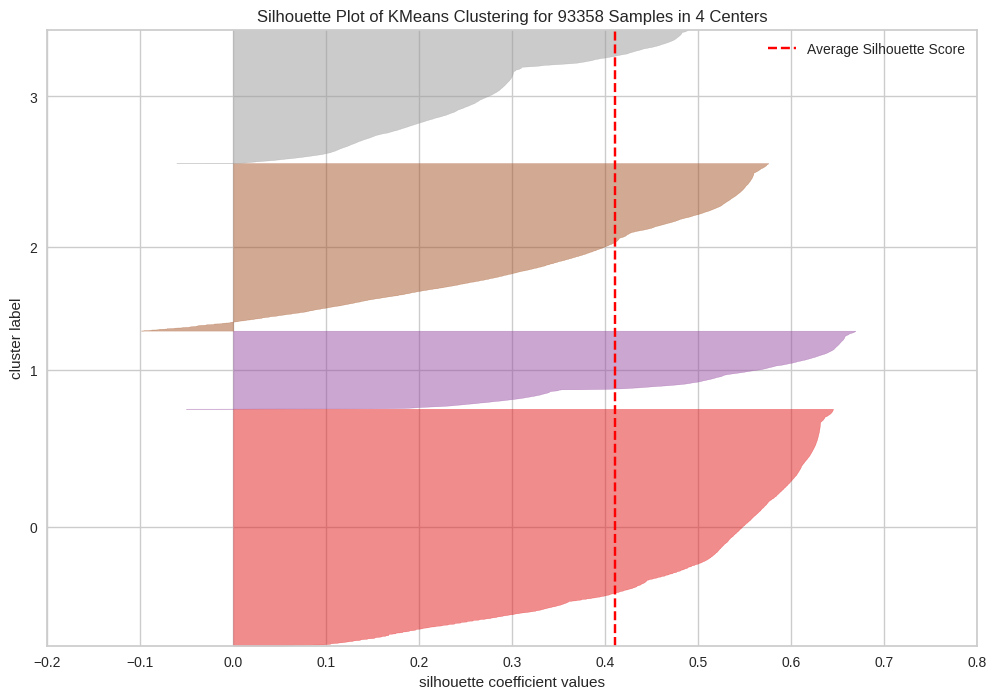

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 93358 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [204]:
K = kmeans_visualizer.named_steps['kelbowvisualizer'].elbow_value_


silhouette_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("silhouettevisualizer", SilhouetteVisualizer(KMeans(K)))])
silhouette_visualizer.fit(X)
silhouette_visualizer.named_steps['silhouettevisualizer'].show()

In [205]:
kmeans_clusters_means_features= rfm_features_1.groupby("Clusters").mean().reset_index()
kmeans_clusters_means_features 

Clusters  mean_payment_installments  mean_review_score     Recency  \
0         0                   2.773061           4.996758  138.744180   
1         1                   3.226326           1.246853  236.762211   
2         2                   3.226124           4.734844  420.716363   
3         3                   2.825319           3.650090  180.618708   

   Frequency    Monetary  
0   1.037536  136.473795  
1   1.023154  164.081604  
2   1.028653  143.233181  
3   1.038189  135.528903

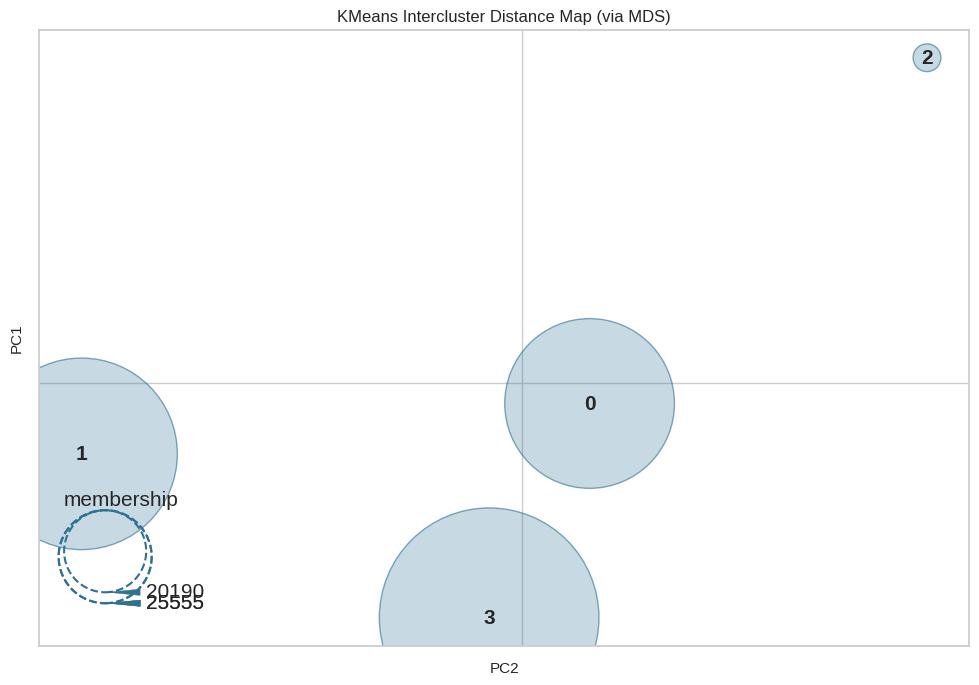

<Axes: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [206]:
distance_visualizer = Pipeline([("preprocessor", preprocessor),
                                  ("distancevisualizer",
                                   InterclusterDistance(KMeans(K)))])
distance_visualizer.fit(X)
distance_visualizer.named_steps['distancevisualizer'].show()

In [207]:
#Scoring
rfm_features_1["recency_score"]  = pd.qcut(rfm_features_1['Recency'], 5, labels=[5, 4, 3, 2, 1])
rfm_features_1["frequency_score"] = pd.qcut(rfm_features_1['Frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
rfm_features_1["monetary_score"] = pd.qcut(rfm_features_1['Monetary'], 5, labels=[1, 2, 3, 4, 5])

rfm_features_1['RFM_SCORE'] = rfm_features_1.recency_score.astype(str)+ rfm_features_1.frequency_score.astype(str) + rfm_features_1.monetary_score.astype(str)

#Segmentation
rfm_features_1['Segment'] = rfm_features_1['recency_score'].astype(str) + rfm_features_1['frequency_score'].astype(str) + rfm_features_1['monetary_score'].astype(str)
rfm_features_1['Segment'] = rfm_features_1['Segment'].replace(seg_map, regex=True)
rfm_features_1.head()

mean_payment_installments  mean_review_score  Recency  Frequency  Monetary  \
0                        8.0                5.0      111          1    129.90   
1                        1.0                4.0      114          1     18.90   
2                        8.0                3.0      537          1     69.00   
3                        4.0                4.0      321          1     25.99   
4                        6.0                5.0      288          1    180.00   

   Clusters recency_score frequency_score monetary_score RFM_SCORE  \
0         0             4               1              4       414   
1         3             4               1              1       411   
2         2             1               1              2       112   
3         3             2               1              1       211   
4         2             2               1              5       215   

                 Segment  
0              Promising  
1          New Customers  
2         Lost customers  
3  Hibernating customers  
4       Cannot Lose Them

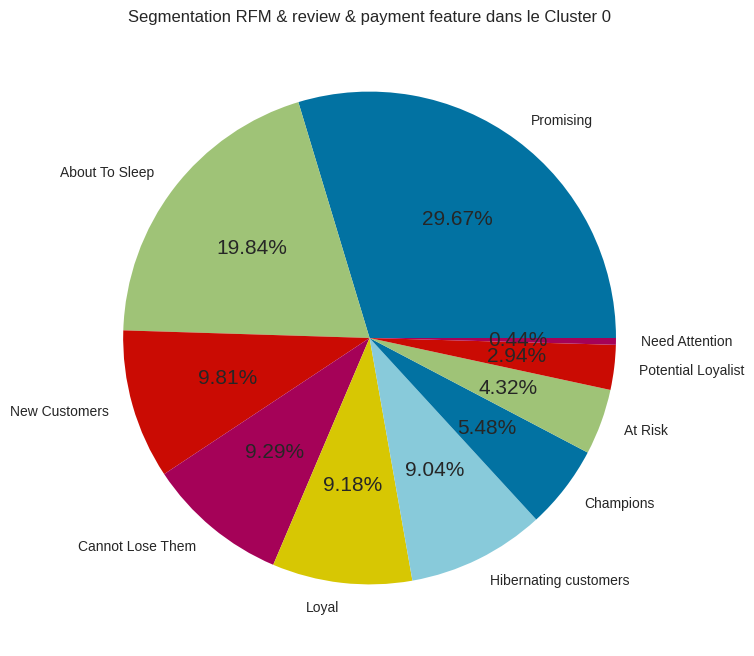

In [208]:
#Affichons les segment appartenants au cluster 0
rfm_features_1_cluster_0 = rfm_features_1[rfm_features_1['Clusters']==0]
rfm_features_1_cluster_0.Segment.unique()
rfm_features_1_cluster_0['Segment'].value_counts()
labels_rfm_features_1_0 = rfm_features_1_cluster_0.Segment.unique()

plt.pie(rfm_features_1_cluster_0['Segment'].value_counts(),
        labels = labels_rfm_features_1_0 ,
        autopct = lambda x: str(round(x, 2))
                   + '%', normalize = True)
plt.title ("Segmentation RFM & review & payment feature dans le Cluster 0")    
plt.show()

<Axes: >

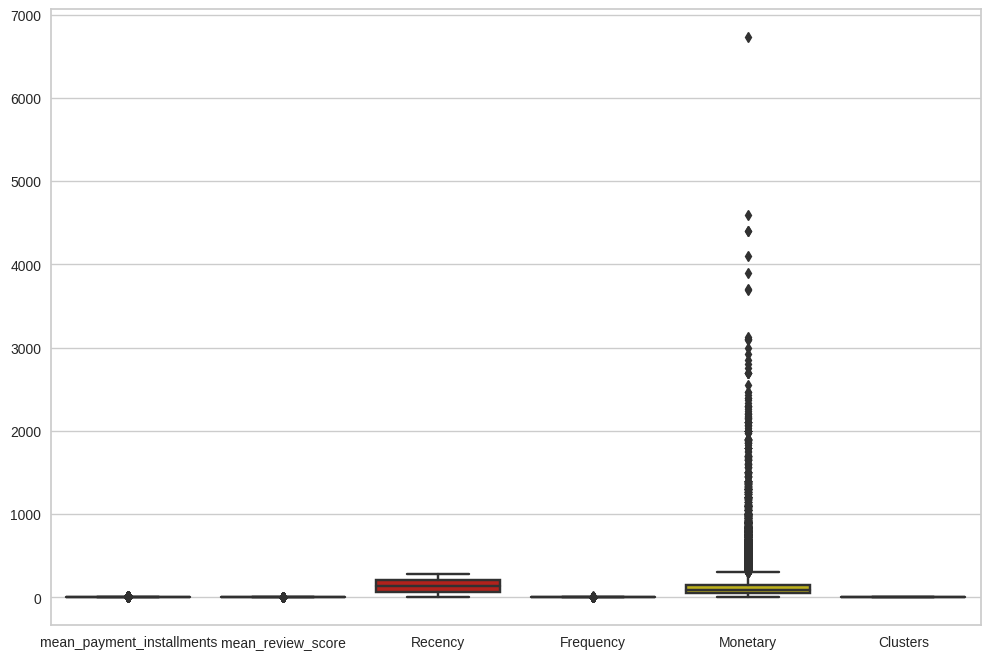

In [300]:
sns.boxplot(data = rfm_features_1_cluster_0)

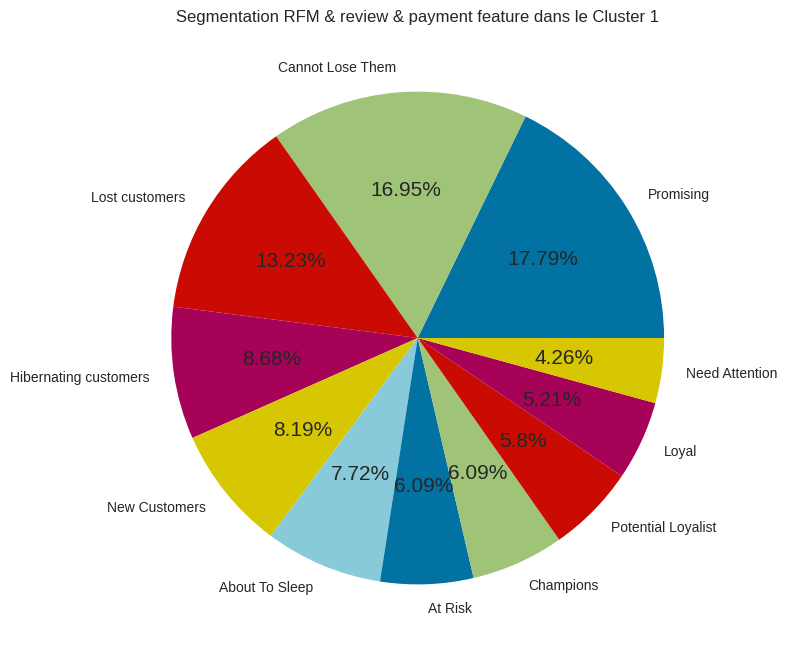

In [209]:
#Affichons les segment appartenants au cluster 1
rfm_features_1_cluster_1 = rfm_features_1[rfm_features_1['Clusters']==1]
rfm_features_1_cluster_1.Segment.unique()
rfm_features_1_cluster_1['Segment'].value_counts()
labels_rfm_features_1_1 = rfm_features_1_cluster_1.Segment.unique()

plt.pie(rfm_features_1_cluster_1['Segment'].value_counts(),
        labels = labels_rfm_features_1_1 ,
        autopct = lambda x: str(round(x, 2))
                   + '%', normalize = True)
plt.title ("Segmentation RFM & review & payment feature dans le Cluster 1")    
plt.show()

<Axes: >

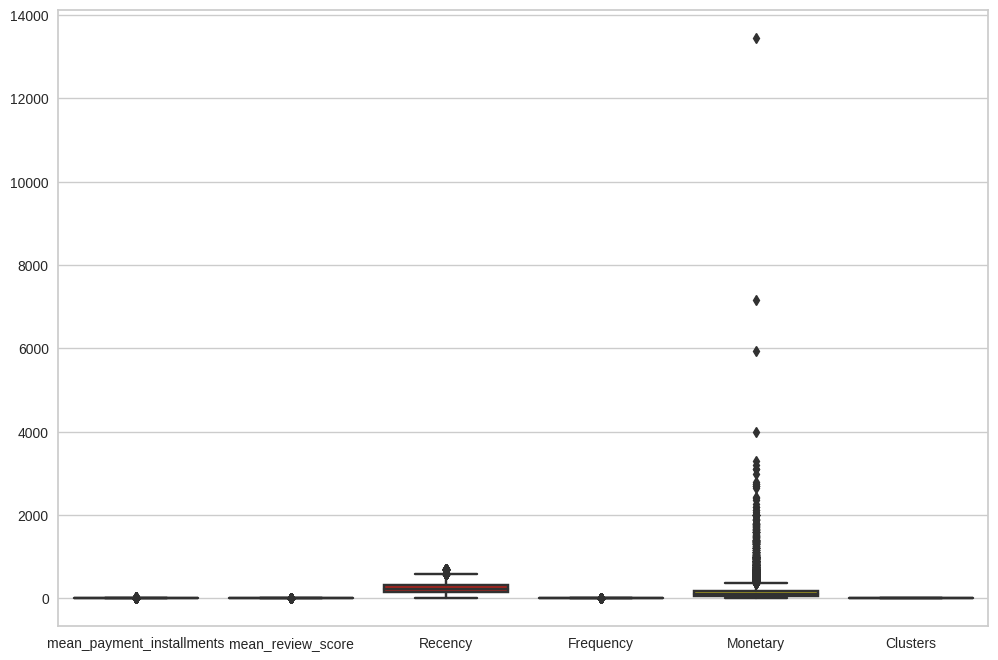

In [301]:
sns.boxplot(data = rfm_features_1_cluster_1)

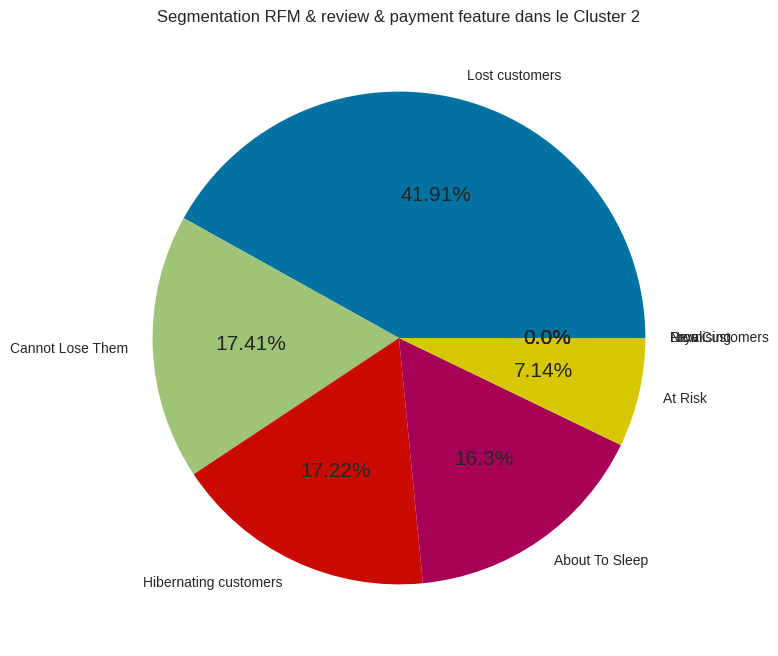

In [210]:
#Affichons les segment appartenants au cluster 2
rfm_features_1_cluster_2 = rfm_features_1[rfm_features_1['Clusters']==2]
rfm_features_1_cluster_2.Segment.unique()
rfm_features_1_cluster_2['Segment'].value_counts()
labels_rfm_features_1_2 = rfm_features_1_cluster_2.Segment.unique()

plt.pie(rfm_features_1_cluster_2['Segment'].value_counts(),
        labels = labels_rfm_features_1_2 ,
        autopct = lambda x: str(round(x, 2))
                   + '%', normalize = True)
plt.title ("Segmentation RFM & review & payment feature dans le Cluster 2")    
plt.show()

<Axes: >

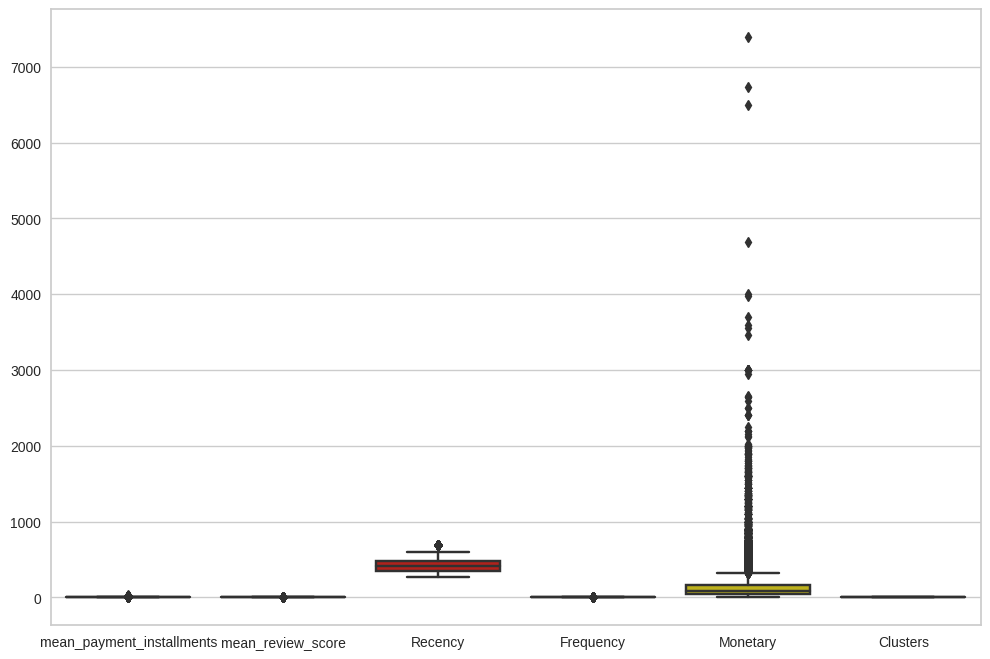

In [302]:
sns.boxplot(data = rfm_features_1_cluster_2)

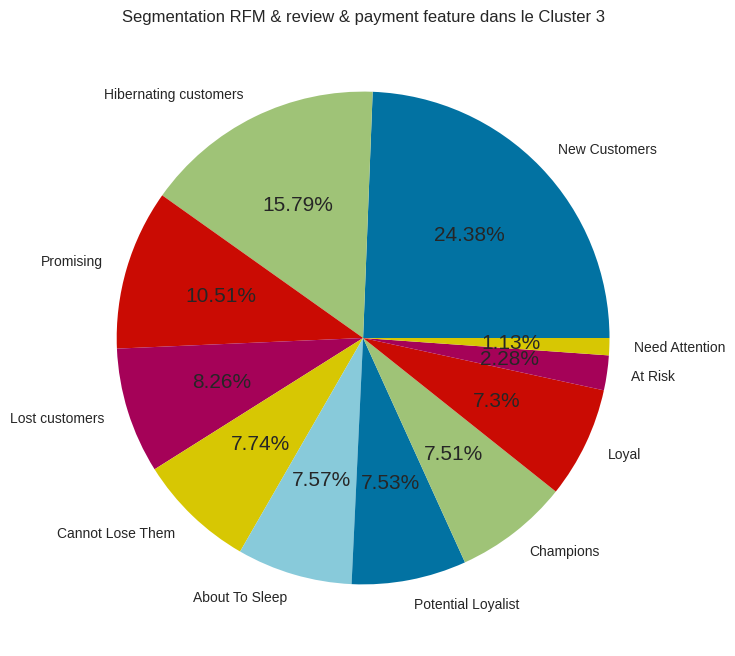

In [211]:
#Affichons les segment appartenants au cluster 3
rfm_features_1_cluster_3 = rfm_features_1[rfm_features_1['Clusters']==3]
rfm_features_1_cluster_3.Segment.unique()
rfm_features_1_cluster_3['Segment'].value_counts()
labels_rfm_features_1_3 = rfm_features_1_cluster_3.Segment.unique()

plt.pie(rfm_features_1_cluster_3['Segment'].value_counts(),
        labels = labels_rfm_features_1_3 ,
        autopct = lambda x: str(round(x, 2))
                   + '%', normalize = True)
plt.title ("Segmentation RFM & review & payment feature dans le Cluster 3")    
plt.show()

<Axes: >

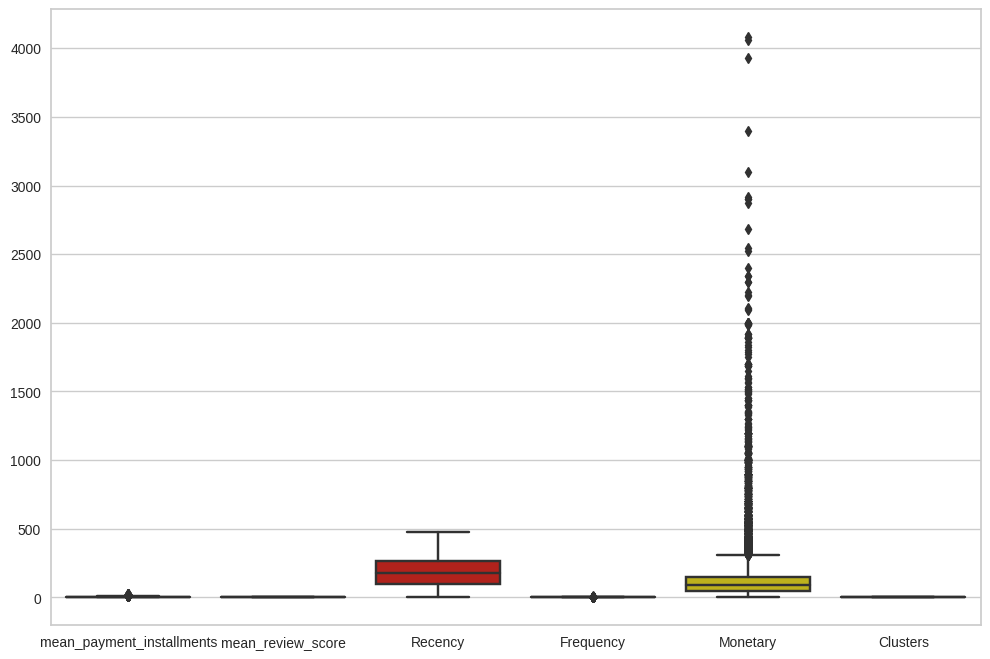

In [303]:
sns.boxplot(data = rfm_features_1_cluster_3)

In [212]:
rfm_features_1.to_csv('/content/drive/MyDrive/OC: Data Science/Datasets/Projet 5/seg_rfm_features_1.csv', index=False)

# rfm & features & nb items

On refait la meme chose mais on ne supprime pas nb items

In [213]:
rfm_features_2 = data.merge(rfm_2, on = 'customer_unique_id', how = 'left' )

In [214]:
data.columns


Index(['customer_unique_id', 'nb_orders', 'total_spend', 'freight_value',
       'mean_payment_installments', 'mean_review_score', 'total_items',
       'mean_nb_items', 'min', 'max', 'order_mean_delay', 'customer_id'],
      dtype='object')

In [215]:
rfm_features_2 

customer_unique_id  nb_orders  total_spend  \
0      0000366f3b9a7992bf8c76cfdf3221e2          1       129.90   
1      0000b849f77a49e4a4ce2b2a4ca5be3f          1        18.90   
2      0000f46a3911fa3c0805444483337064          1        69.00   
3      0000f6ccb0745a6a4b88665a16c9f078          1        25.99   
4      0004aac84e0df4da2b147fca70cf8255          1       180.00   
...                                 ...        ...          ...   
93353  fffcf5a5ff07b0908bd4e2dbc735a684          1      1570.00   
93354  fffea47cd6d3cc0a88bd621562a9d061          1        64.89   
93355  ffff371b4d645b6ecea244b27531430a          1        89.90   
93356  ffff5962728ec6157033ef9805bacc48          1       115.00   
93357  ffffd2657e2aad2907e67c3e9daecbeb          1        56.99   

       freight_value  mean_payment_installments  mean_review_score  \
0              12.00                        8.0                5.0   
1               8.29                        1.0                4.0   
2              17.22                        8.0                3.0   
3              17.63                        4.0                4.0   
4              16.89                        6.0                5.0   
...              ...                        ...                ...   
93353         497.42                       10.0                5.0   
93354          19.69                        1.0                4.0   
93355          22.56                        1.0                5.0   
93356          18.69                        5.0                5.0   
93357          14.57                        4.0                5.0   

       total_items  mean_nb_items                  min                  max  \
0              1.0            1.0  2018-05-10 10:56:27  2018-05-10 10:56:27   
1              1.0            1.0  2018-05-07 11:11:27  2018-05-07 11:11:27   
2              1.0            1.0  2017-03-10 21:05:03  2017-03-10 21:05:03   
3              1.0            1.0  2017-10-12 20:29:41  2017-10-12 20:29:41   
4              1.0            1.0  2017-11-14 19:45:42  2017-11-14 19:45:42   
...            ...            ...                  ...                  ...   
93353          2.0            2.0  2017-06-08 21:00:36  2017-06-08 21:00:36   
93354          1.0            1.0  2017-12-10 20:07:56  2017-12-10 20:07:56   
93355          1.0            1.0  2017-02-07 15:49:16  2017-02-07 15:49:16   
93356          1.0            1.0  2018-05-02 15:17:41  2018-05-02 15:17:41   
93357          1.0            1.0  2017-05-02 20:18:45  2017-05-02 20:18:45   

       order_mean_delay                       customer_id  Recency  Frequency  \
0                 111.0  fadbb3709178fc513abc1b2670aa1ad2      111          1   
1                 114.0  4cb282e167ae9234755102258dd52ee8      114          1   
2                 536.0  9b3932a6253894a02c1df9d19004239f      537          1   
3                 320.0  914991f0c02ef0843c0e7010c819d642      321          1   
4                 287.0  47227568b10f5f58a524a75507e6992c      288          1   
...                 ...                               ...      ...        ...   
93353             446.0  74be082247cd677a147d83ee670e9d53      447          1   
93354             261.0  0ecf8e0a08148af0bf313184f167670a      262          1   
93355             567.0  27f584b0f1dc4e610065c240f68b6be0      568          1   
93356             118.0  832a3b0254347d409512ae92eaf154a6      119          1   
93357             483.0  70bc4d9cf2bbeea3f7b09798370f5884      484          1   

       Monetary                Segment  Cluster  
0        129.90              Promising        3  
1         18.90          New Customers        3  
2         69.00         Lost customers        2  
3         25.99  Hibernating customers        0  
4        180.00       Cannot Lose Them        0  
...         ...                    ...      ...  
93353   1570.00       Cannot Lose Them        2  
93354     64.89     Potential Loyalist        0  
933

In [216]:
rfm_features_2.shape

(93358, 17)

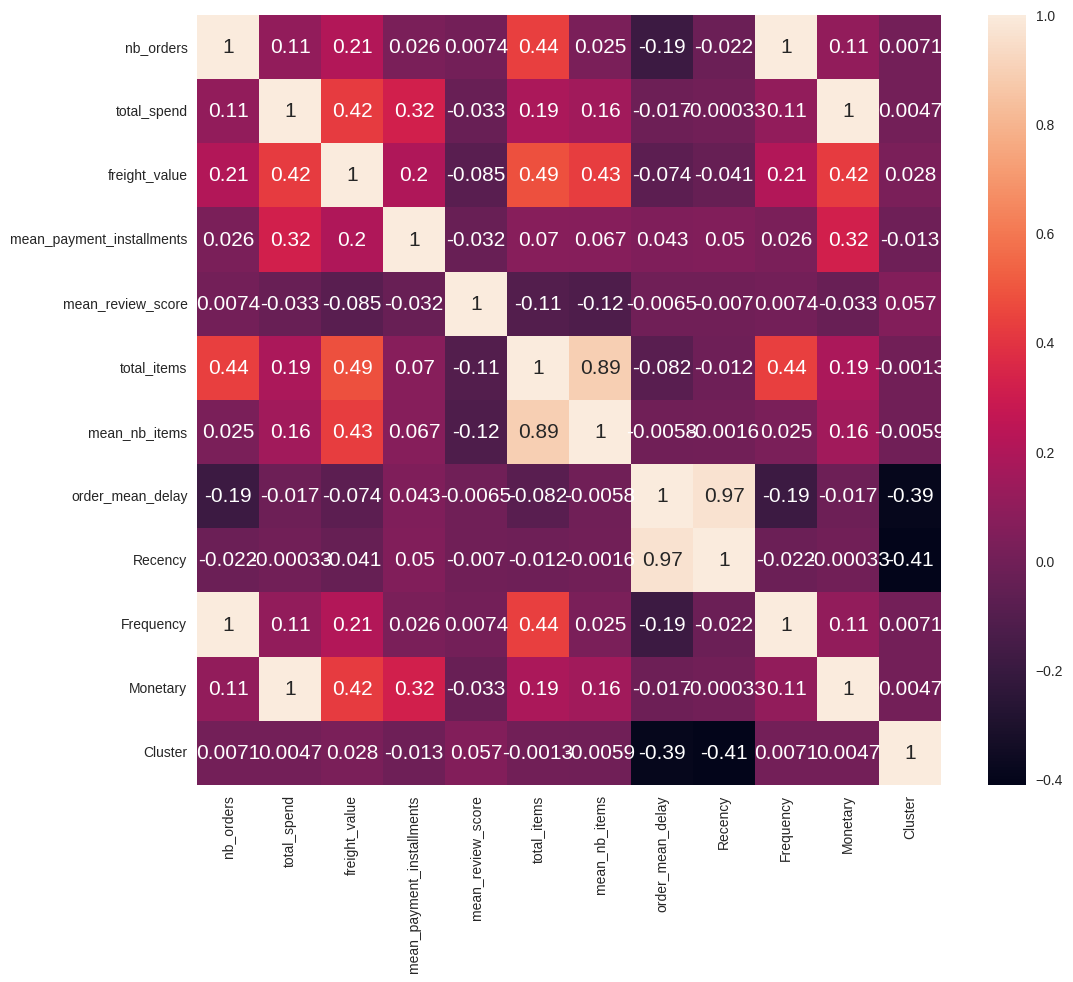

In [217]:
corr(rfm_features_2)

In [218]:
rfm_features_2 .columns

Index(['customer_unique_id', 'nb_orders', 'total_spend', 'freight_value',
       'mean_payment_installments', 'mean_review_score', 'total_items',
       'mean_nb_items', 'min', 'max', 'order_mean_delay', 'customer_id',
       'Recency', 'Frequency', 'Monetary', 'Segment', 'Cluster'],
      dtype='object')

In [219]:
rfm_features_nb = rfm_features.drop(['customer_unique_id', 'nb_orders', 'total_spend',
                                  'freight_value', 'total_items', 'min', 'max', 
                                  'order_mean_delay', 'customer_id', 'Segment', 
                                  'Cluster'],  axis =1)

In [220]:
rfm_features_nb.shape

(93358, 6)

In [221]:
rfm_features_nb.columns

Index(['mean_payment_installments', 'mean_review_score', 'mean_nb_items',
       'Recency', 'Frequency', 'Monetary'],
      dtype='object')

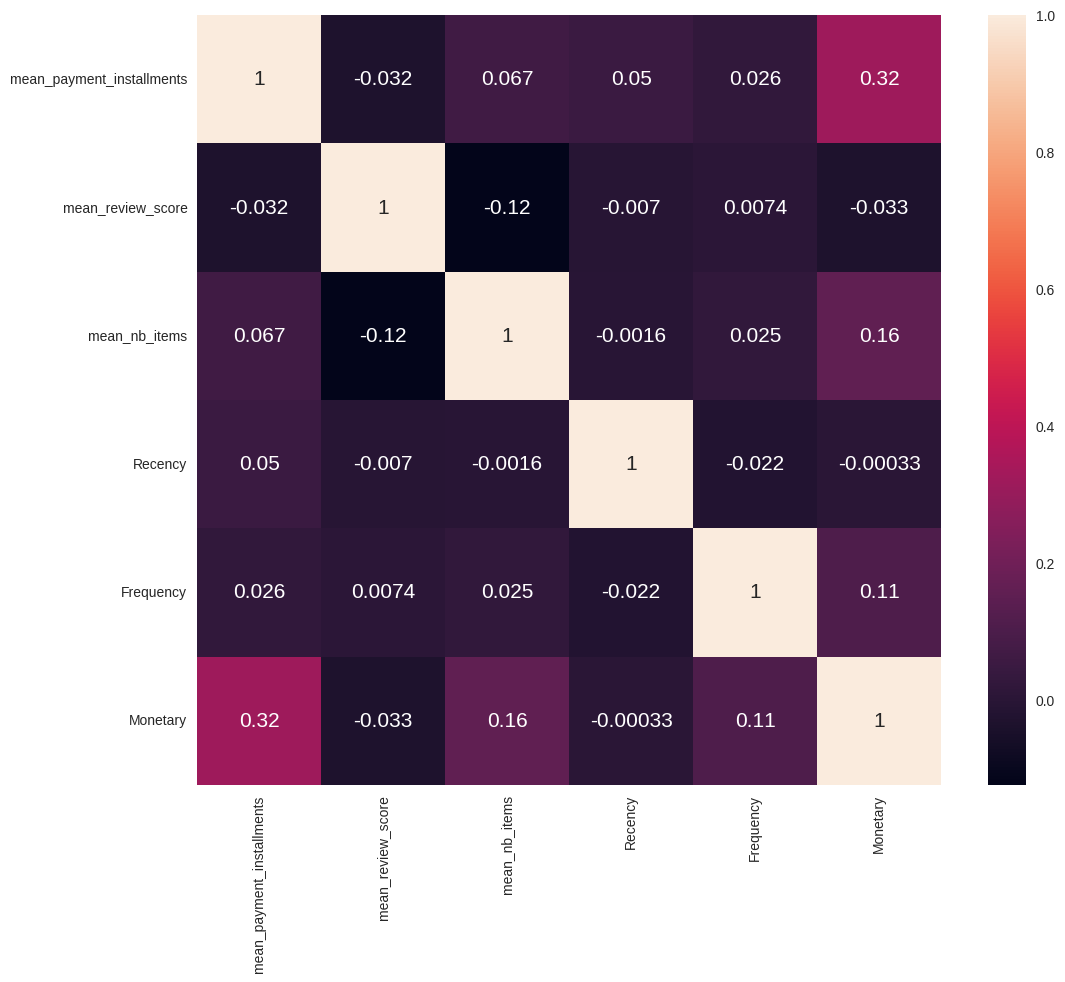

In [222]:
corr(rfm_features_nb)

In [223]:
categorical_features_nb = list(rfm_features_nb.select_dtypes(exclude=['int64', 'float64', 'uint8']).columns)
numerical_features_nb = list(rfm_features_nb.select_dtypes(include=['int64','float64', 'uint8']).columns)
print('categorical_features  : ', categorical_features_nb)
print("*****")
print('numerical_features: ', numerical_features_nb)
print("*****")
len(numerical_features_nb)

categorical_features  :  []
*****
numerical_features:  ['mean_payment_installments', 'mean_review_score', 'mean_nb_items', 'Recency', 'Frequency', 'Monetary']
*****


6

In [224]:
scaler = MinMaxScaler()

preprocessor = ColumnTransformer([('scaler', scaler, numerical_features_nb)])

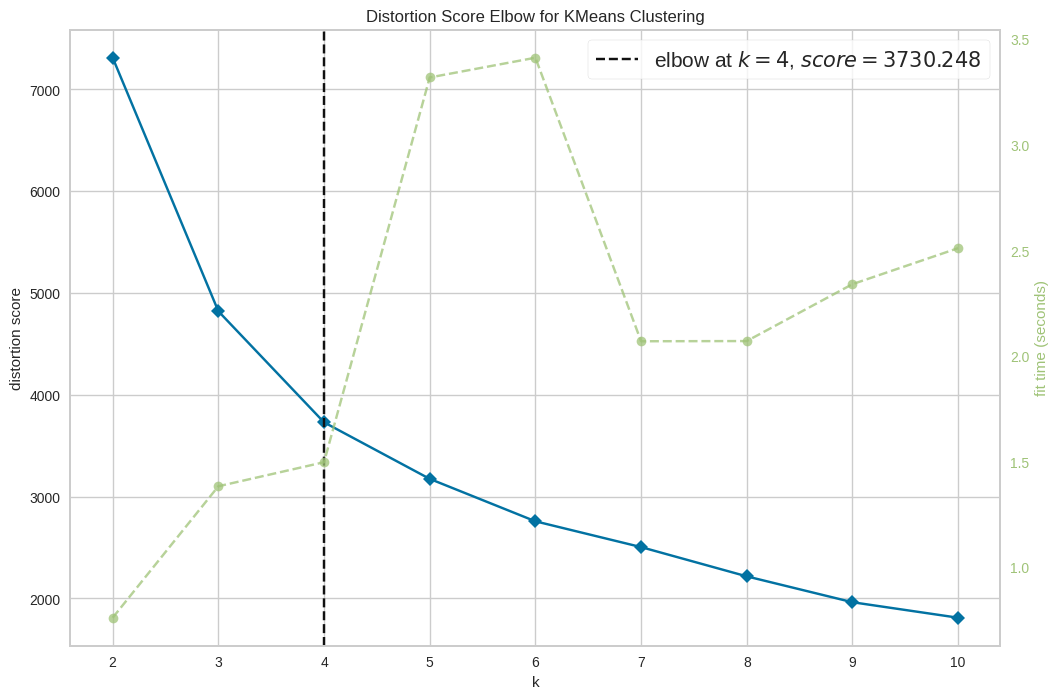

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [225]:
X = rfm_features_nb.copy()
# Elbow method
kmeans_visualizer = Pipeline([("preprocessor", preprocessor),
                              ("kelbowvisualizer", KElbowVisualizer(KMeans(),
                                                                    K=(4,12)))])
kmeans_visualizer.fit(X)
kmeans_visualizer.named_steps['kelbowvisualizer'].show()

In [226]:
# KMeans Pipeline with best K
kmeans_model = Pipeline([("preprocessor", preprocessor),
                         ("kmeans", KMeans(K))])
kmeans_model.fit(X)

# Kmeans labels
kmeans_labels_features = kmeans_model.named_steps['kmeans'].labels_
rfm_features_nb["Clusters"] = kmeans_labels_features

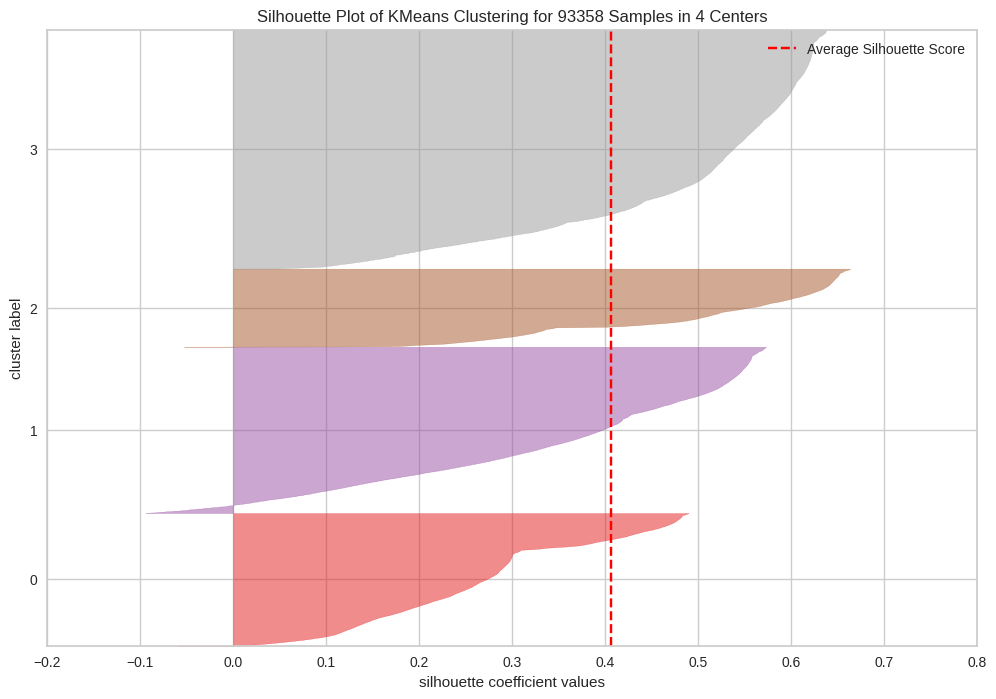

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 93358 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [227]:
K = kmeans_visualizer.named_steps['kelbowvisualizer'].elbow_value_


silhouette_visualizer = Pipeline([ ("preprocessor", preprocessor),
                                  ("silhouettevisualizer", 
                                   SilhouetteVisualizer(KMeans(K)))])
silhouette_visualizer.fit(X)
silhouette_visualizer.named_steps['silhouettevisualizer'].show()

In [228]:
kmeans_clusters_means_features = rfm_features_nb.groupby("Clusters").mean().reset_index()
kmeans_clusters_means_features 

Clusters  mean_payment_installments  mean_review_score  mean_nb_items  \
0         0                   3.228271           4.735846       1.116186   
1         1                   2.823224           3.650285       1.130354   
2         2                   3.226326           1.246853       1.313095   
3         3                   2.772999           4.996758       1.103975   

      Recency  Frequency    Monetary  
0  420.775043   1.028643  143.328459  
1  180.858593   1.038187  135.464724  
2  236.762211   1.023154  164.081604  
3  138.740203   1.037537  136.447580

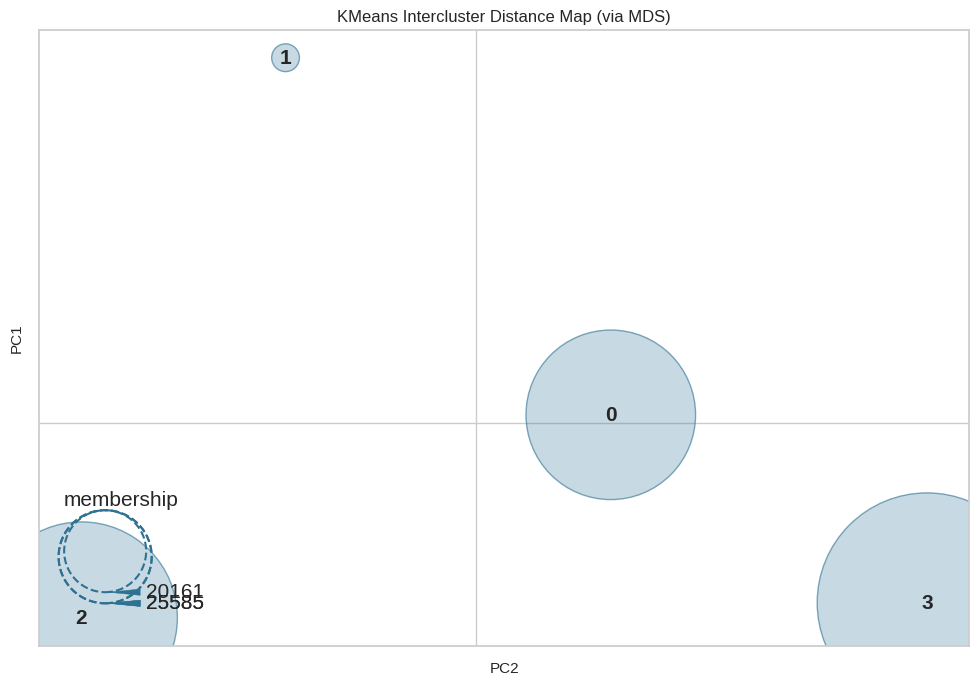

<Axes: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [229]:
distance_visualizer = Pipeline([("preprocessor", preprocessor),
                                  ("distancevisualizer", 
                                   InterclusterDistance(KMeans(K)))])
distance_visualizer.fit(X)
distance_visualizer.named_steps['distancevisualizer'].show()

In [230]:
#Scoring
rfm_features_nb["recency_score"]  = pd.qcut(rfm_features_nb['Recency'], 5, labels=[5, 4, 3, 2, 1])
rfm_features_nb["frequency_score"] = pd.qcut(rfm_features_nb['Frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
rfm_features_nb["monetary_score"] = pd.qcut(rfm_features_nb['Monetary'], 5, labels=[1, 2, 3, 4, 5])

rfm_features_nb['RFM_SCORE'] = rfm_features_nb.recency_score.astype(str)+ rfm_features_nb.frequency_score.astype(str) + rfm_features_nb.monetary_score.astype(str)

#Segmentation
rfm_features_nb['Segment'] = rfm_features_nb['recency_score'].astype(str) + rfm_features_nb['frequency_score'].astype(str) + rfm_features_nb['monetary_score'].astype(str)
rfm_features_nb['Segment'] = rfm_features_nb['Segment'].replace(seg_map, regex=True)
rfm_features_nb.head()

mean_payment_installments  mean_review_score  mean_nb_items  Recency  \
0                        8.0                5.0            1.0      111   
1                        1.0                4.0            1.0      114   
2                        8.0                3.0            1.0      537   
3                        4.0                4.0            1.0      321   
4                        6.0                5.0            1.0      288   

   Frequency  Monetary  Clusters recency_score frequency_score monetary_score  \
0          1    129.90         3             4               1              4   
1          1     18.90         1             4               1              1   
2          1     69.00         0             1               1              2   
3          1     25.99         1             2               1              1   
4          1    180.00         0             2               1              5   

  RFM_SCORE                Segment  
0       414              Promising  
1       411          New Customers  
2       112         Lost customers  
3       211  Hibernating customers  
4       215       Cannot Lose Them

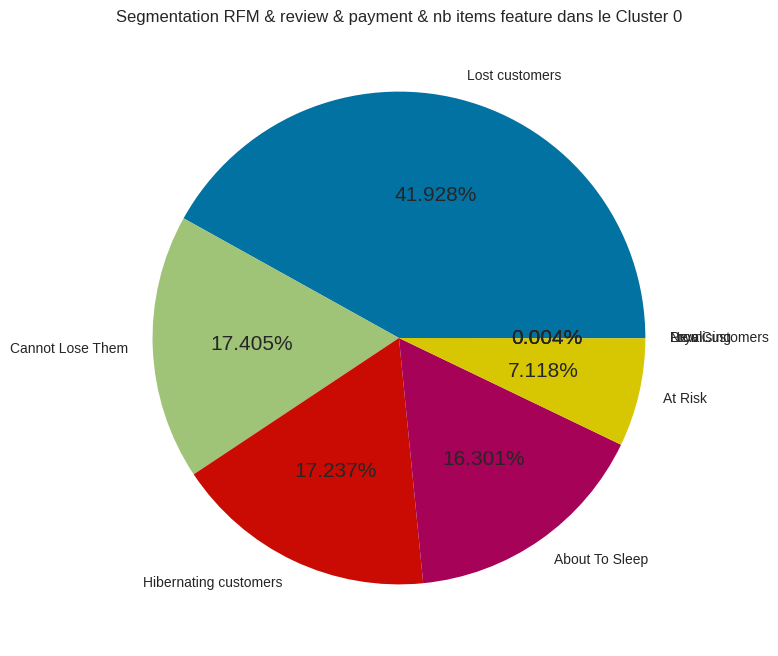

In [231]:
#Affichons les segment appartenants au cluster 0
rfm_features_nb_cluster_0 = rfm_features_nb[rfm_features_nb['Clusters']==0]
rfm_features_nb_cluster_0.Segment.unique()
rfm_features_nb_cluster_0['Segment'].value_counts()
labels_rfm_features_nb_0 = rfm_features_nb_cluster_0.Segment.unique()

plt.pie(rfm_features_nb_cluster_0['Segment'].value_counts(),
        labels = labels_rfm_features_nb_0 ,
        autopct = lambda x: str(round(x, 3))
                   + '%', normalize = True)
plt.title ("Segmentation RFM & review & payment & nb items feature dans le Cluster 0")    
plt.show()

<Axes: >

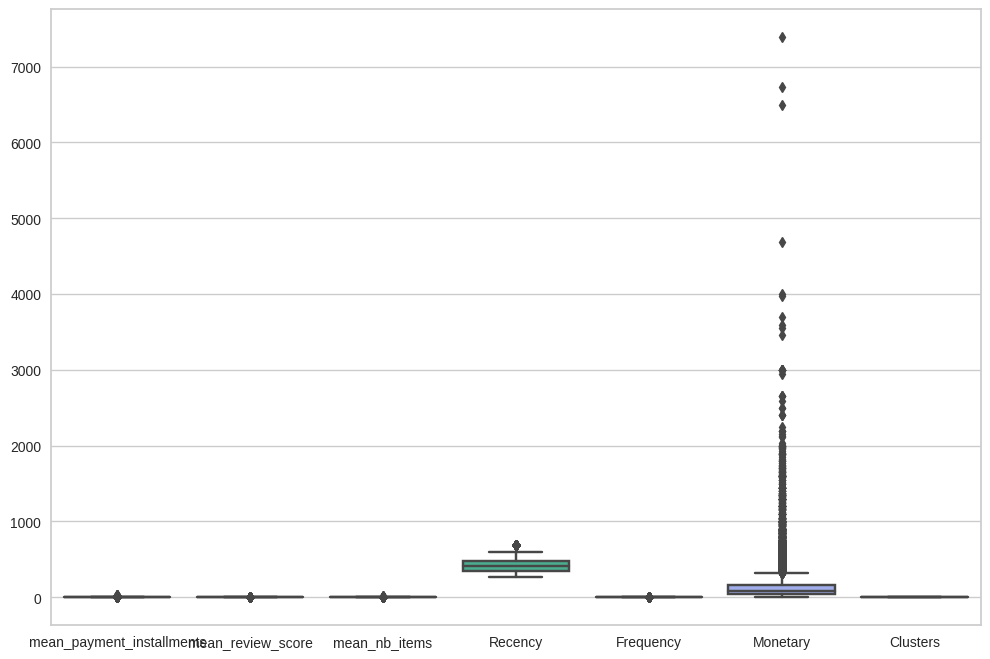

In [309]:
sns.boxplot(data = rfm_features_nb_cluster_0)

In [232]:
rfm_features_nb_cluster_0['Segment'].value_counts()

At Risk                  10715
Hibernating customers     4448
Cannot Lose Them          4405
Lost customers            4166
About To Sleep            1819
Promising                    1
New Customers                1
Loyal                        1
Name: Segment, dtype: int64

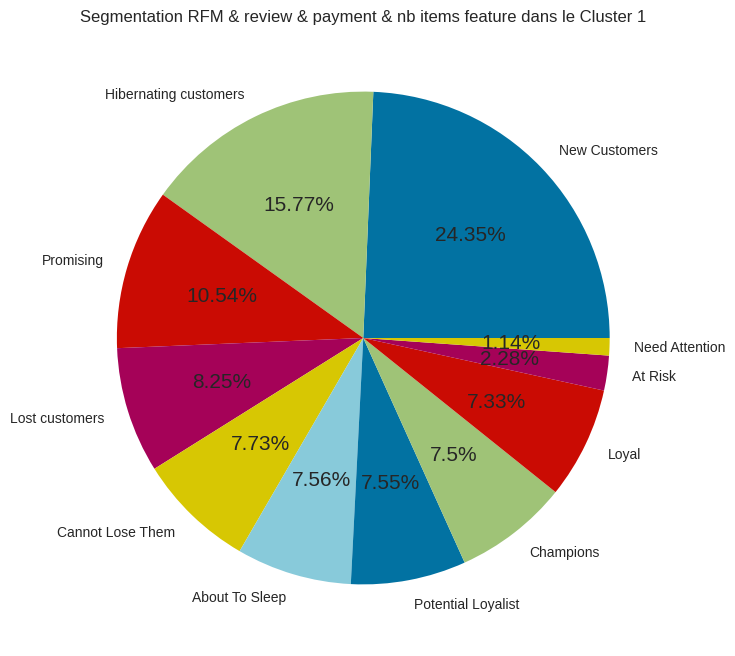

In [233]:
#Affichons les segment appartenants au cluster 1
rfm_features_nb_cluster_1 = rfm_features_nb[rfm_features_nb['Clusters']==1]
rfm_features_nb_cluster_1.Segment.unique()
rfm_features_nb_cluster_1['Segment'].value_counts()
labels_rfm_features_nb_1 = rfm_features_nb_cluster_1.Segment.unique()

plt.pie(rfm_features_nb_cluster_1['Segment'].value_counts(),
        labels = labels_rfm_features_nb_1 ,
        autopct = lambda x: str(round(x, 2))
                   + '%', normalize = True)
plt.title ("Segmentation RFM & review & payment & nb items feature dans le Cluster 1")    
plt.show()

<Axes: >

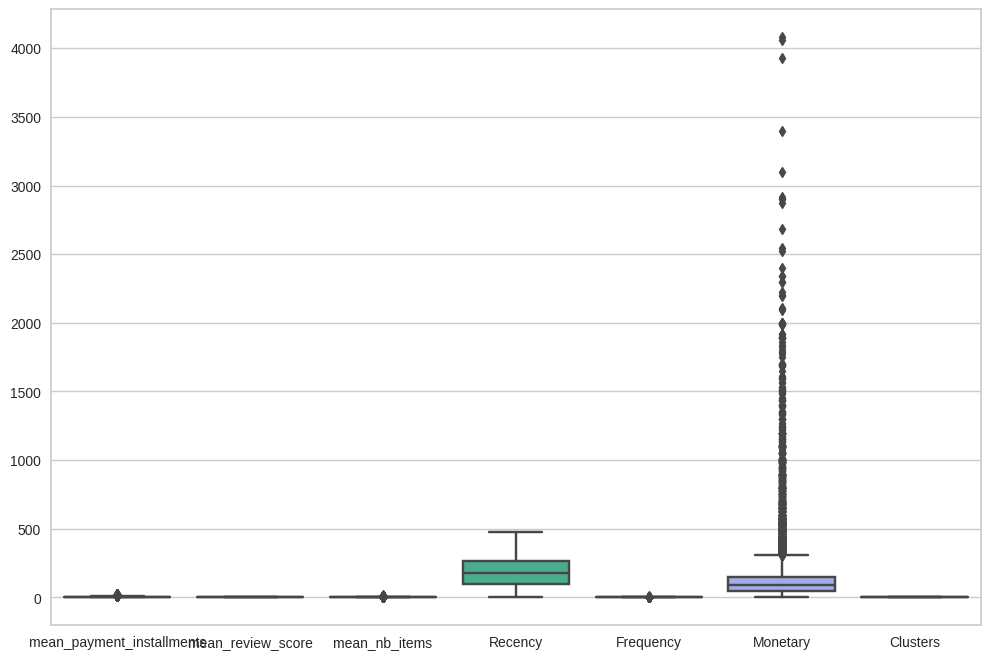

In [310]:
sns.boxplot(data = rfm_features_nb_cluster_1)

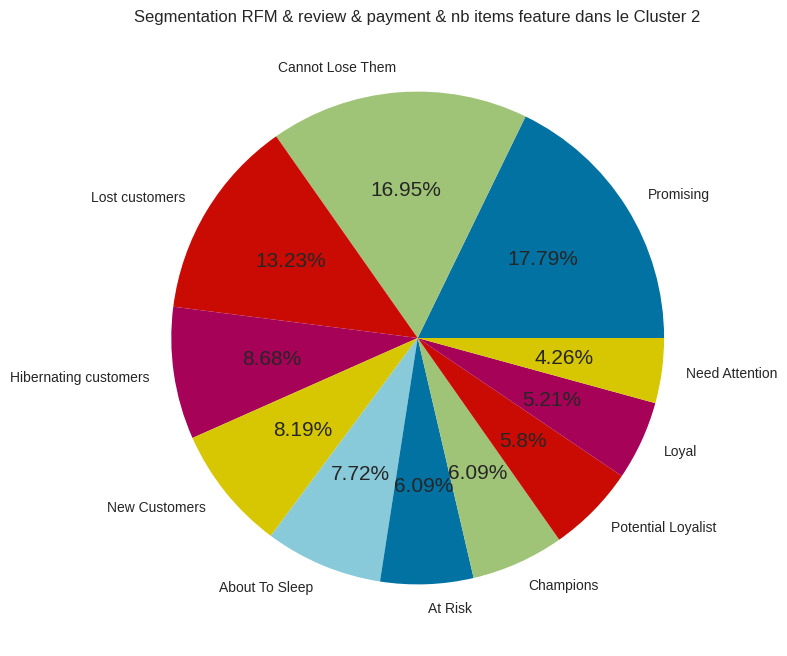

In [234]:
#Affichons les segment appartenants au cluster 2
rfm_features_nb_cluster_2 = rfm_features_nb[rfm_features_nb['Clusters']==2]
rfm_features_nb_cluster_2.Segment.unique()
rfm_features_nb_cluster_2['Segment'].value_counts()
labels_rfm_features_nb_2 = rfm_features_nb_cluster_2.Segment.unique()

plt.pie(rfm_features_nb_cluster_2['Segment'].value_counts(),
        labels = labels_rfm_features_nb_2 ,
        autopct = lambda x: str(round(x, 2))
                   + '%', normalize = True)
plt.title ("Segmentation RFM & review & payment & nb items feature dans le Cluster 2")    
plt.show()

<Axes: >

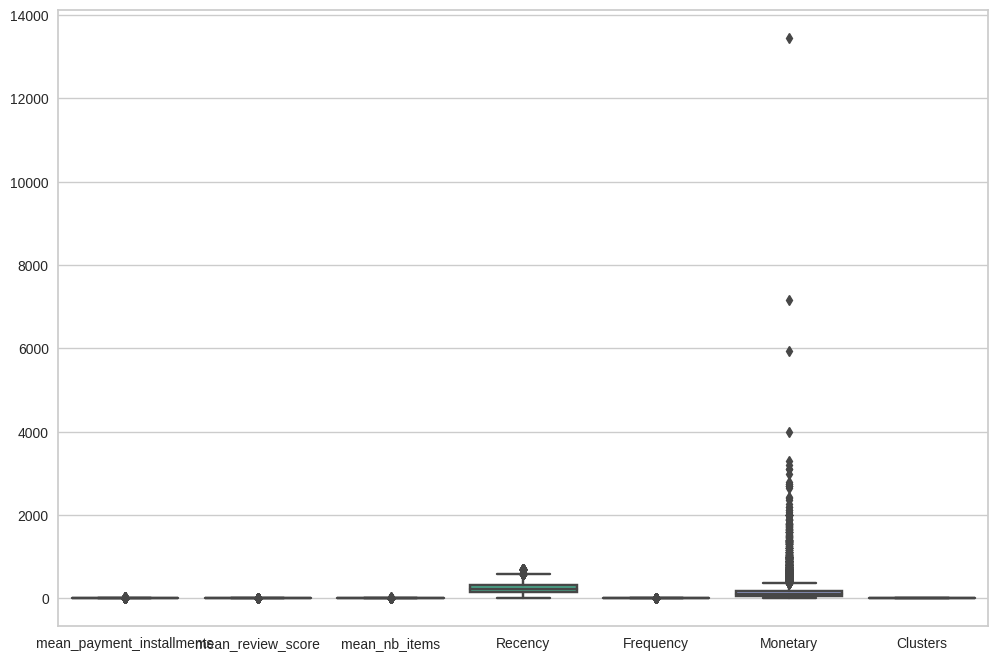

In [311]:
sns.boxplot(data = rfm_features_nb_cluster_2)

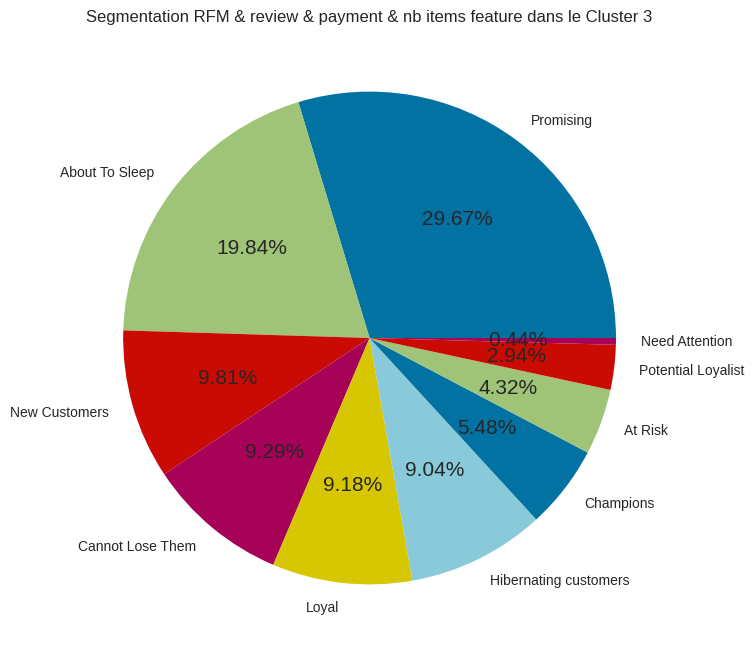

In [235]:
#Affichons les segment appartenants au cluster 3
rfm_features_nb_cluster_3 = rfm_features_nb[rfm_features_nb['Clusters']==3]
rfm_features_nb_cluster_3.Segment.unique()
rfm_features_nb_cluster_3['Segment'].value_counts()
labels_rfm_features_nb_3 = rfm_features_nb_cluster_3.Segment.unique()

plt.pie(rfm_features_nb_cluster_3['Segment'].value_counts(),
        labels = labels_rfm_features_nb_3,
        autopct = lambda x: str(round(x, 2))
                   + '%', normalize = True)
plt.title ("Segmentation RFM & review & payment & nb items feature dans le Cluster 3")    
plt.show()

<Axes: >

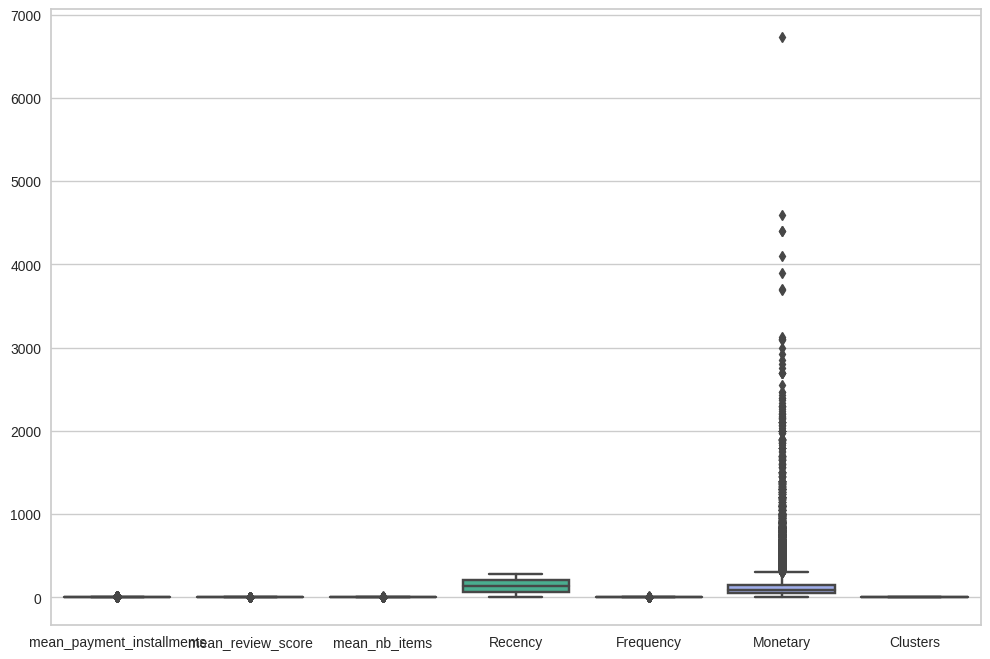

In [312]:
sns.boxplot(data = rfm_features_nb_cluster_3)

In [236]:
rfm_features_nb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93358 entries, 0 to 93357
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   mean_payment_installments  93358 non-null  float64 
 1   mean_review_score          93358 non-null  float64 
 2   mean_nb_items              93358 non-null  float64 
 3   Recency                    93358 non-null  int64   
 4   Frequency                  93358 non-null  int64   
 5   Monetary                   93358 non-null  float64 
 6   Clusters                   93358 non-null  int32   
 7   recency_score              93358 non-null  category
 8   frequency_score            93358 non-null  category
 9   monetary_score             93358 non-null  category
 10  RFM_SCORE                  93358 non-null  object  
 11  Segment                    93358 non-null  object  
dtypes: category(3), float64(4), int32(1), int64(2), object(2)
memory usage: 7.0+ MB


In [237]:
rfm_features_nb.to_csv('/content/drive/MyDrive/OC: Data Science/Datasets/Projet 5/seg_rfm_features_nb.csv', index=False)

# rfm & features & nb items & delay





On refait la meme chose mais on ne supprime pas delay

In [238]:
rfm_features = data.merge(rfm_2, on = 'customer_unique_id', how = 'left' )

In [239]:
data.columns


Index(['customer_unique_id', 'nb_orders', 'total_spend', 'freight_value',
       'mean_payment_installments', 'mean_review_score', 'total_items',
       'mean_nb_items', 'min', 'max', 'order_mean_delay', 'customer_id'],
      dtype='object')

In [240]:
rfm_features

customer_unique_id  nb_orders  total_spend  \
0      0000366f3b9a7992bf8c76cfdf3221e2          1       129.90   
1      0000b849f77a49e4a4ce2b2a4ca5be3f          1        18.90   
2      0000f46a3911fa3c0805444483337064          1        69.00   
3      0000f6ccb0745a6a4b88665a16c9f078          1        25.99   
4      0004aac84e0df4da2b147fca70cf8255          1       180.00   
...                                 ...        ...          ...   
93353  fffcf5a5ff07b0908bd4e2dbc735a684          1      1570.00   
93354  fffea47cd6d3cc0a88bd621562a9d061          1        64.89   
93355  ffff371b4d645b6ecea244b27531430a          1        89.90   
93356  ffff5962728ec6157033ef9805bacc48          1       115.00   
93357  ffffd2657e2aad2907e67c3e9daecbeb          1        56.99   

       freight_value  mean_payment_installments  mean_review_score  \
0              12.00                        8.0                5.0   
1               8.29                        1.0                4.0   
2              17.22                        8.0                3.0   
3              17.63                        4.0                4.0   
4              16.89                        6.0                5.0   
...              ...                        ...                ...   
93353         497.42                       10.0                5.0   
93354          19.69                        1.0                4.0   
93355          22.56                        1.0                5.0   
93356          18.69                        5.0                5.0   
93357          14.57                        4.0                5.0   

       total_items  mean_nb_items                  min                  max  \
0              1.0            1.0  2018-05-10 10:56:27  2018-05-10 10:56:27   
1              1.0            1.0  2018-05-07 11:11:27  2018-05-07 11:11:27   
2              1.0            1.0  2017-03-10 21:05:03  2017-03-10 21:05:03   
3              1.0            1.0  2017-10-12 20:29:41  2017-10-12 20:29:41   
4              1.0            1.0  2017-11-14 19:45:42  2017-11-14 19:45:42   
...            ...            ...                  ...                  ...   
93353          2.0            2.0  2017-06-08 21:00:36  2017-06-08 21:00:36   
93354          1.0            1.0  2017-12-10 20:07:56  2017-12-10 20:07:56   
93355          1.0            1.0  2017-02-07 15:49:16  2017-02-07 15:49:16   
93356          1.0            1.0  2018-05-02 15:17:41  2018-05-02 15:17:41   
93357          1.0            1.0  2017-05-02 20:18:45  2017-05-02 20:18:45   

       order_mean_delay                       customer_id  Recency  Frequency  \
0                 111.0  fadbb3709178fc513abc1b2670aa1ad2      111          1   
1                 114.0  4cb282e167ae9234755102258dd52ee8      114          1   
2                 536.0  9b3932a6253894a02c1df9d19004239f      537          1   
3                 320.0  914991f0c02ef0843c0e7010c819d642      321          1   
4                 287.0  47227568b10f5f58a524a75507e6992c      288          1   
...                 ...                               ...      ...        ...   
93353             446.0  74be082247cd677a147d83ee670e9d53      447          1   
93354             261.0  0ecf8e0a08148af0bf313184f167670a      262          1   
93355             567.0  27f584b0f1dc4e610065c240f68b6be0      568          1   
93356             118.0  832a3b0254347d409512ae92eaf154a6      119          1   
93357             483.0  70bc4d9cf2bbeea3f7b09798370f5884      484          1   

       Monetary                Segment  Cluster  
0        129.90              Promising        3  
1         18.90          New Customers        3  
2         69.00         Lost customers        2  
3         25.99  Hibernating customers        0  
4        180.00       Cannot Lose Them        0  
...         ...                    ...      ...  
93353   1570.00       Cannot Lose Them        2  
93354     64.89     Potential Loyalist        0  
933

In [241]:
rfm_features.to_csv('/content/drive/MyDrive/OC: Data Science/Datasets/Projet 5/seg_rfm_features_del1.csv', index=False)

In [242]:
rfm_features.shape

(93358, 17)

In [243]:
rfm_features.columns

Index(['customer_unique_id', 'nb_orders', 'total_spend', 'freight_value',
       'mean_payment_installments', 'mean_review_score', 'total_items',
       'mean_nb_items', 'min', 'max', 'order_mean_delay', 'customer_id',
       'Recency', 'Frequency', 'Monetary', 'Segment', 'Cluster'],
      dtype='object')

In [244]:
rfm_features_del = rfm_features.drop(['customer_unique_id', 'nb_orders', 'total_spend',
                                  'freight_value', 'total_items', 'min', 'max', 'customer_id', 'Segment', 
                                  'Cluster'],  axis =1)

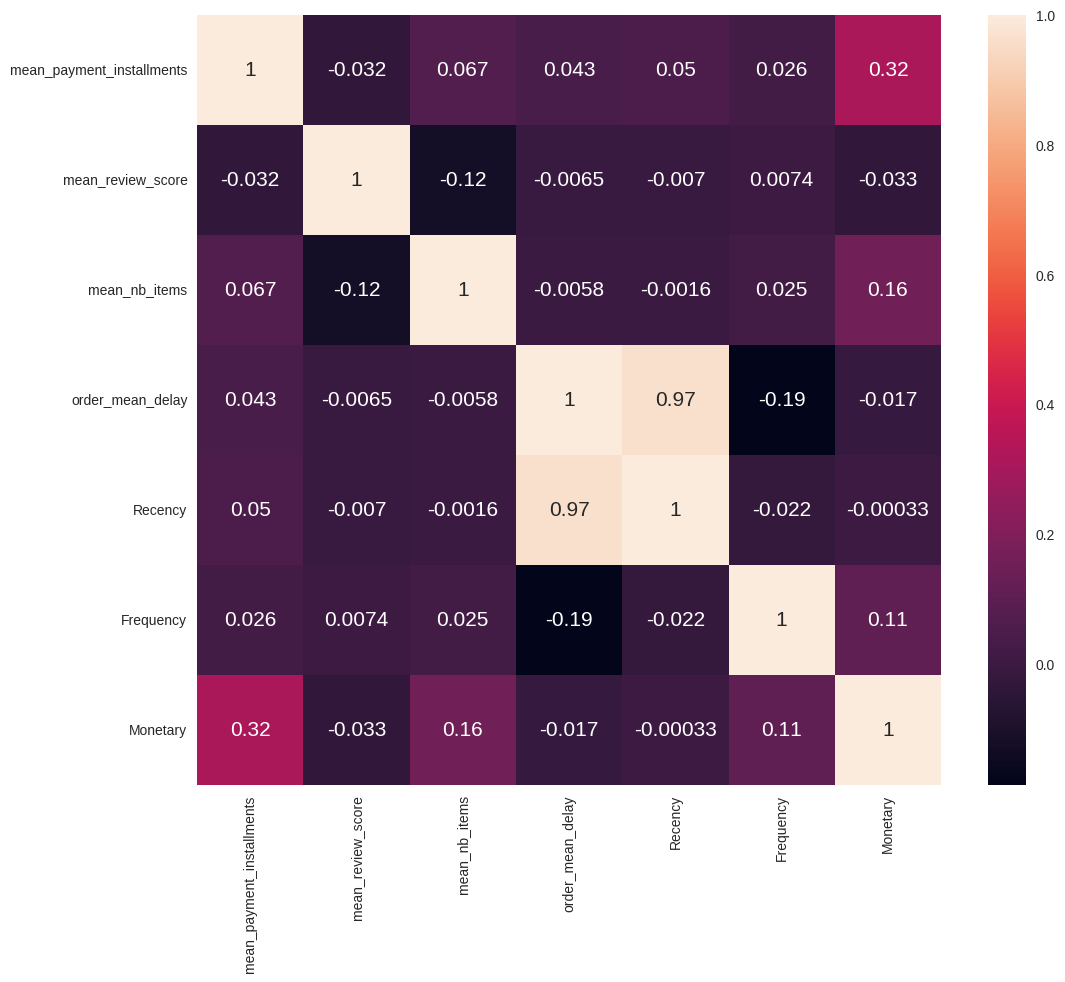

In [245]:
corr(rfm_features_del)

In [246]:
rfm_features_del.shape

(93358, 7)

In [247]:
rfm_features_del.columns

Index(['mean_payment_installments', 'mean_review_score', 'mean_nb_items',
       'order_mean_delay', 'Recency', 'Frequency', 'Monetary'],
      dtype='object')

In [248]:
categorical_features_del = list(rfm_features_del.select_dtypes(exclude=['int64', 'float64', 'uint8']).columns)
numerical_features_del = list(rfm_features_del.select_dtypes(include=['int64','float64', 'uint8']).columns)
print('categorical_features  : ', categorical_features_del)
print("*****")
print('numerical_features: ', numerical_features_del)
print("*****")
len(numerical_features_del)

categorical_features  :  []
*****
numerical_features:  ['mean_payment_installments', 'mean_review_score', 'mean_nb_items', 'order_mean_delay', 'Recency', 'Frequency', 'Monetary']
*****


7

In [249]:
scaler = MinMaxScaler()

preprocessor = ColumnTransformer([('scaler', scaler, numerical_features_del)] )

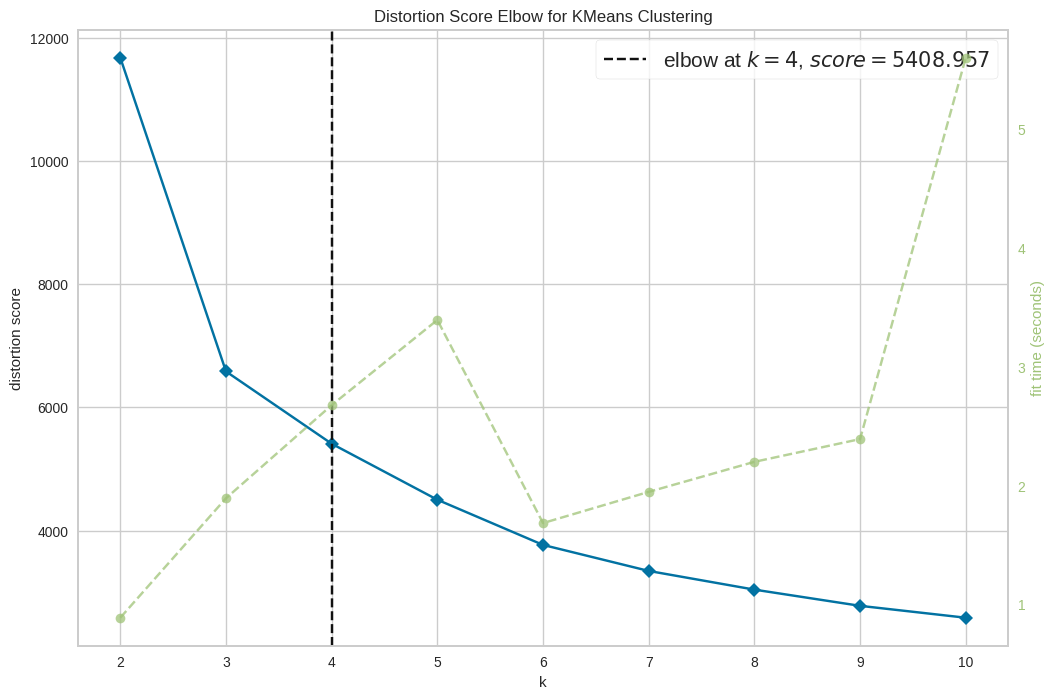

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [250]:
X = rfm_features_del.copy()
# Elbow method
kmeans_visualizer = Pipeline([("preprocessor", preprocessor),
                              ("kelbowvisualizer", KElbowVisualizer(KMeans(),
                                                                    K=(4,12)))])
kmeans_visualizer.fit(X)
kmeans_visualizer.named_steps['kelbowvisualizer'].show()

In [251]:
# KMeans Pipeline with best K
kmeans_model = Pipeline([("preprocessor", preprocessor),
                         ("kmeans", KMeans(K))])
kmeans_model.fit(X)

# Kmeans labels
kmeans_labels_features = kmeans_model.named_steps['kmeans'].labels_
rfm_features_del["Clusters"] = kmeans_labels_features

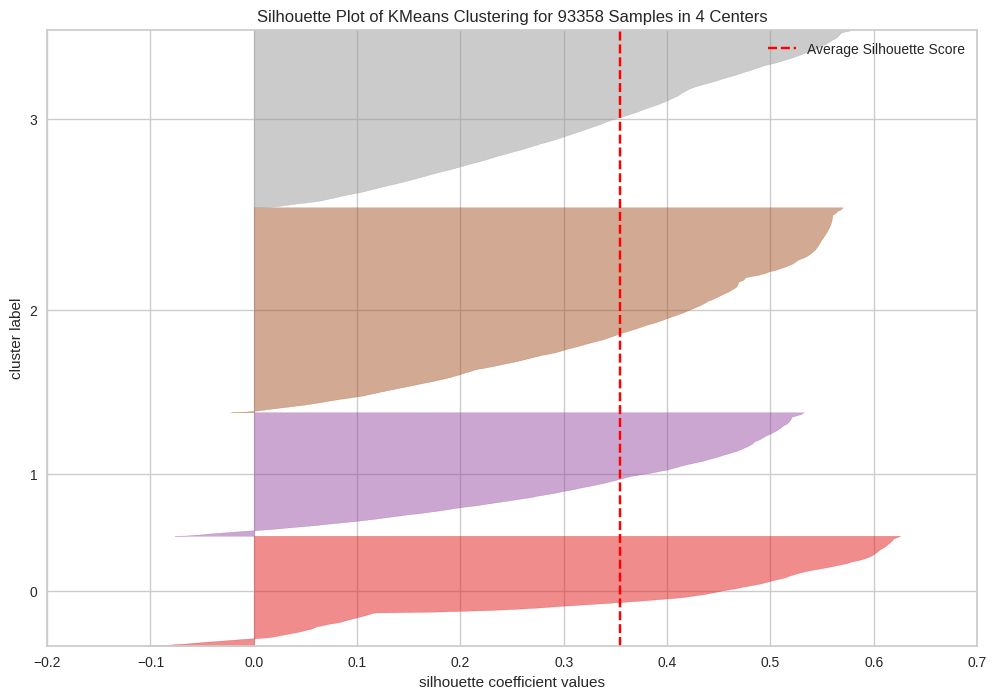

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 93358 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [252]:
K = kmeans_visualizer.named_steps['kelbowvisualizer'].elbow_value_


silhouette_visualizer = Pipeline([("preprocessor", preprocessor),
                                  ("silhouettevisualizer", 
                                   SilhouetteVisualizer(KMeans(K)))])
silhouette_visualizer.fit(X)
silhouette_visualizer.named_steps['silhouettevisualizer'].show()

In [253]:
kmeans_clusters_means_features= rfm_features_del.groupby("Clusters").mean().reset_index()
kmeans_clusters_means_features 

Clusters  mean_payment_installments  mean_review_score  mean_nb_items  \
0         0                   2.816441           4.680556       1.114261   
1         1                   3.209892           4.576159       1.117075   
2         2                   3.133208           1.754822       1.270335   
3         3                   2.864676           4.753857       1.103378   

   order_mean_delay     Recency  Frequency    Monetary  
0         81.147672   86.273744   1.059847  143.544978  
1        458.445578  459.218807   1.000852  137.346388  
2        224.725490  230.948298   1.029905  155.468513  
3        252.292199  261.207389   1.027838  133.815214

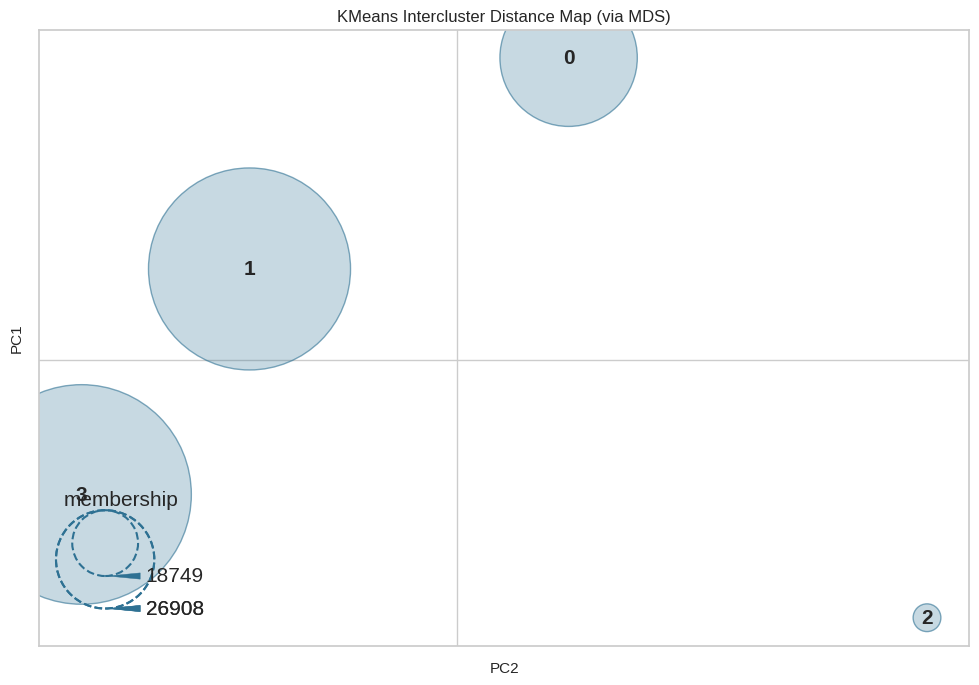

<Axes: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [254]:
distance_visualizer = Pipeline([("preprocessor", preprocessor),
                                  ("distancevisualizer", 
                                   InterclusterDistance(KMeans(K)))])
distance_visualizer.fit(X)
distance_visualizer.named_steps['distancevisualizer'].show()

In [255]:
#Scoring
rfm_features_del["recency_score"]  = pd.qcut(rfm_features_del['Recency'], 5, labels=[5, 4, 3, 2, 1])
rfm_features_del["frequency_score"] = pd.qcut(rfm_features_del['Frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
rfm_features_del["monetary_score"] = pd.qcut(rfm_features_del['Monetary'], 5, labels=[1, 2, 3, 4, 5])

rfm_features_del['RFM_SCORE'] = rfm_features_del.recency_score.astype(str) + rfm_features_del.frequency_score.astype(str) + rfm_features_del.monetary_score.astype(str)

#Segmentation
rfm_features_del['Segment'] = rfm_features_del['recency_score'].astype(str) + rfm_features_del['frequency_score'].astype(str) + rfm_features_del['monetary_score'].astype(str)
rfm_features_del['Segment'] = rfm_features_del['Segment'].replace(seg_map, regex=True)
rfm_features_del.head()

mean_payment_installments  mean_review_score  mean_nb_items  \
0                        8.0                5.0            1.0   
1                        1.0                4.0            1.0   
2                        8.0                3.0            1.0   
3                        4.0                4.0            1.0   
4                        6.0                5.0            1.0   

   order_mean_delay  Recency  Frequency  Monetary  Clusters recency_score  \
0             111.0      111          1    129.90         0             4   
1             114.0      114          1     18.90         0             4   
2             536.0      537          1     69.00         1             1   
3             320.0      321          1     25.99         3             2   
4             287.0      288          1    180.00         3             2   

  frequency_score monetary_score RFM_SCORE                Segment  
0               1              4       414              Promising  
1               1              1       411          New Customers  
2               1              2       112         Lost customers  
3               1              1       211  Hibernating customers  
4               1              5       215       Cannot Lose Them

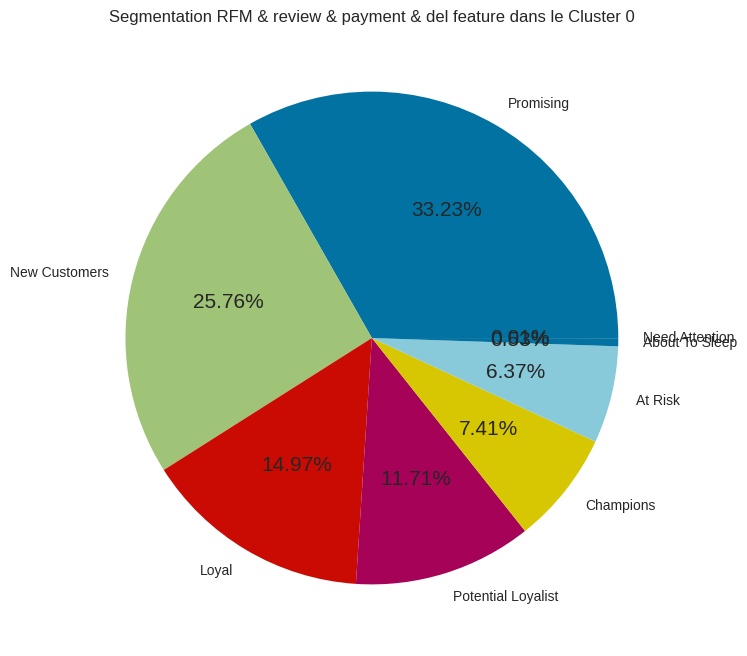

In [256]:
#Affichons les segment appartenants au cluster 0
rfm_features_del_cluster_0 = rfm_features_del[rfm_features_del['Clusters']==0]
rfm_features_del_cluster_0.Segment.unique()
rfm_features_del_cluster_0['Segment'].value_counts()
labels_rfm_features_del_0 = rfm_features_del_cluster_0.Segment.unique()

plt.pie(rfm_features_del_cluster_0['Segment'].value_counts(),
        labels = labels_rfm_features_del_0,
        autopct = lambda x: str(round(x, 2))
                   + '%', normalize = True)
plt.title ("Segmentation RFM & review & payment & del feature dans le Cluster 0")    
plt.show()

<Axes: >

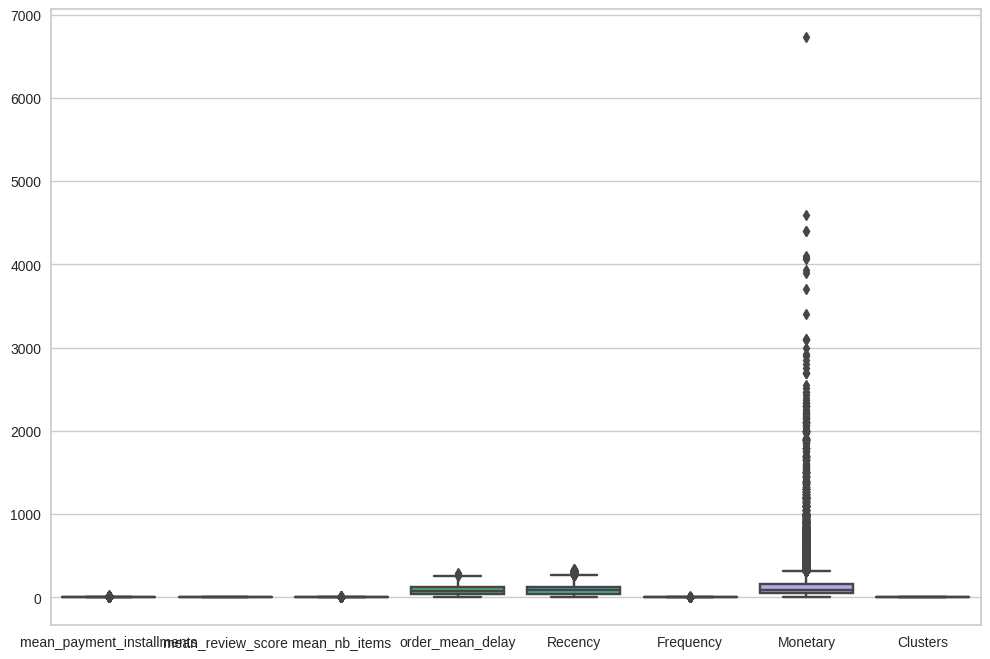

In [313]:
sns.boxplot(data = rfm_features_del_cluster_0)

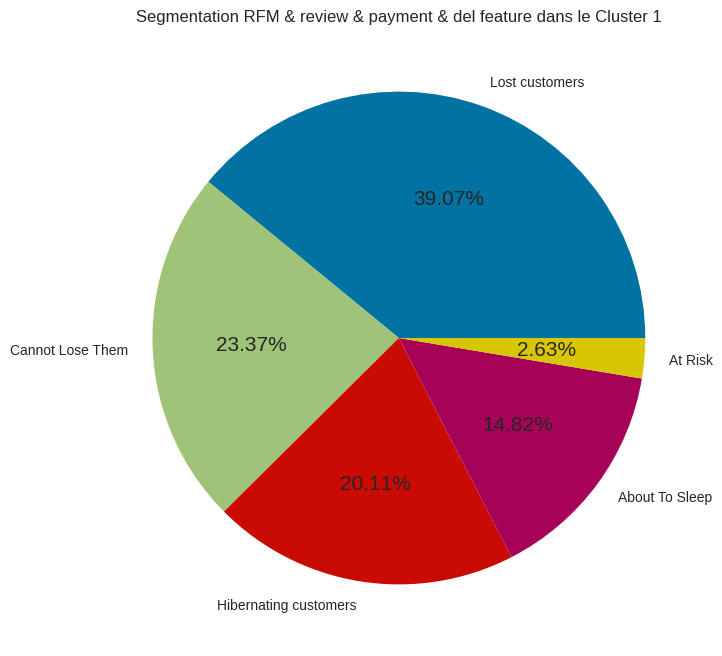

In [257]:
#Affichons les segment appartenants au cluster 1
rfm_features_del_cluster_1 = rfm_features_del[rfm_features_del['Clusters']==1]
rfm_features_del_cluster_1.Segment.unique()
rfm_features_del_cluster_1['Segment'].value_counts()
labels_rfm_features_del_1 = rfm_features_del_cluster_1.Segment.unique()

plt.pie(rfm_features_del_cluster_1['Segment'].value_counts(),
        labels = labels_rfm_features_del_1,
        autopct = lambda x: str(round(x, 2))
                   + '%', normalize = True)
plt.title ("Segmentation RFM & review & payment & del feature dans le Cluster 1")    
plt.show()

<Axes: >

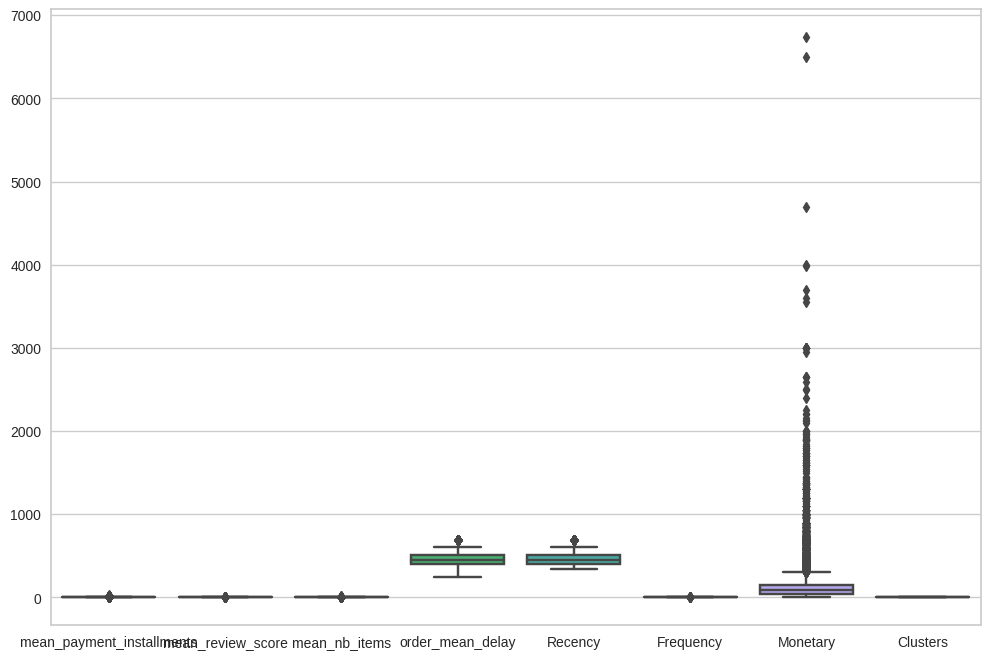

In [314]:
sns.boxplot(data = rfm_features_del_cluster_1)

In [258]:
rfm_features_del_cluster_1.Segment.unique()

array(['Lost customers', 'Cannot Lose Them', 'Hibernating customers',
       'About To Sleep', 'At Risk'], dtype=object)

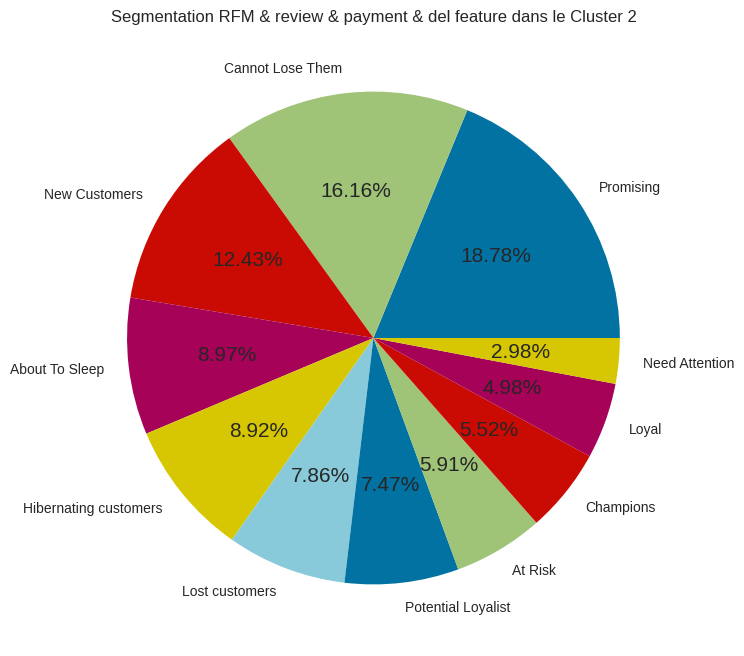

In [259]:
#Affichons les segment appartenants au cluster 2
rfm_features_del_cluster_2 = rfm_features_del[rfm_features_del['Clusters']==2]
rfm_features_del_cluster_2.Segment.unique()
rfm_features_del_cluster_2['Segment'].value_counts()
labels_rfm_features_del_2 = rfm_features_del_cluster_2.Segment.unique()

plt.pie(rfm_features_del_cluster_2['Segment'].value_counts(),
        labels = labels_rfm_features_del_2,
        autopct = lambda x: str(round(x, 2))
                   + '%', normalize = True)
plt.title ("Segmentation RFM & review & payment & del feature dans le Cluster 2")    
plt.show()

<Axes: >

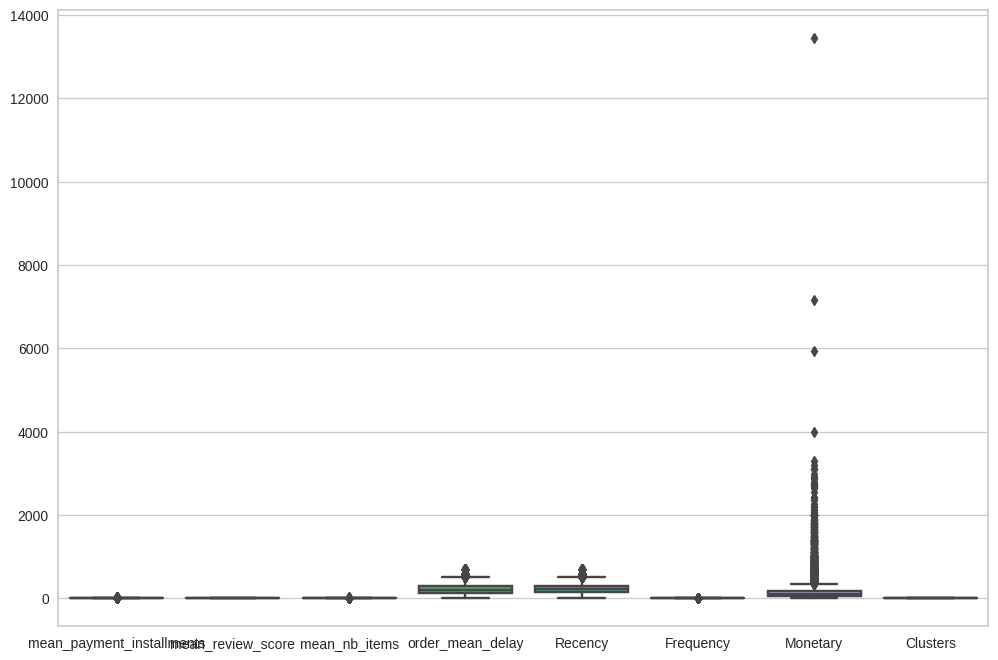

In [316]:
sns.boxplot(data = rfm_features_del_cluster_2)

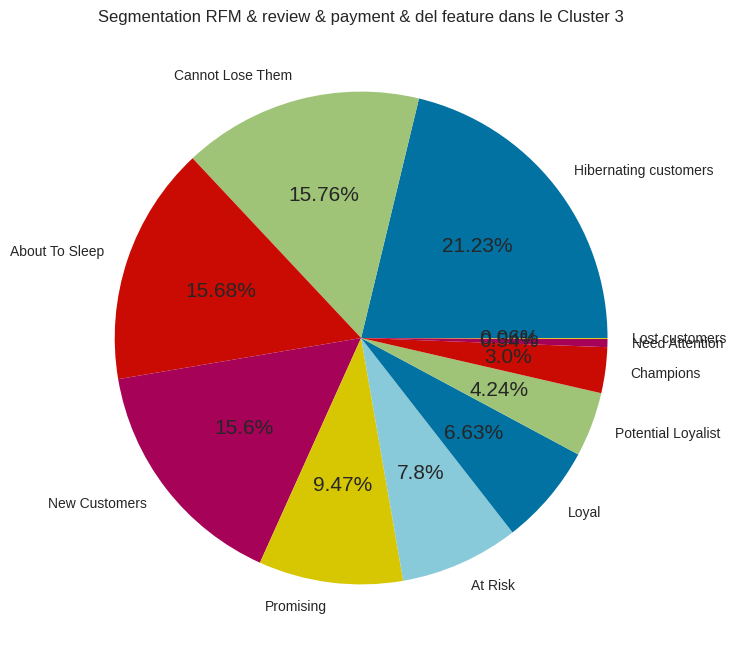

In [260]:
#Affichons les segment appartenants au cluster 3
rfm_features_del_cluster_3 = rfm_features_del[rfm_features_del['Clusters']==3]
rfm_features_del_cluster_3.Segment.unique()
rfm_features_del_cluster_3['Segment'].value_counts()
labels_rfm_features_del_3 = rfm_features_del_cluster_3.Segment.unique()

plt.pie(rfm_features_del_cluster_3['Segment'].value_counts(),
        labels = labels_rfm_features_del_3,
        autopct = lambda x: str(round(x, 2))
                   + '%', normalize = True)
plt.title ("Segmentation RFM & review & payment & del feature dans le Cluster 3")    
plt.show()

<Axes: >

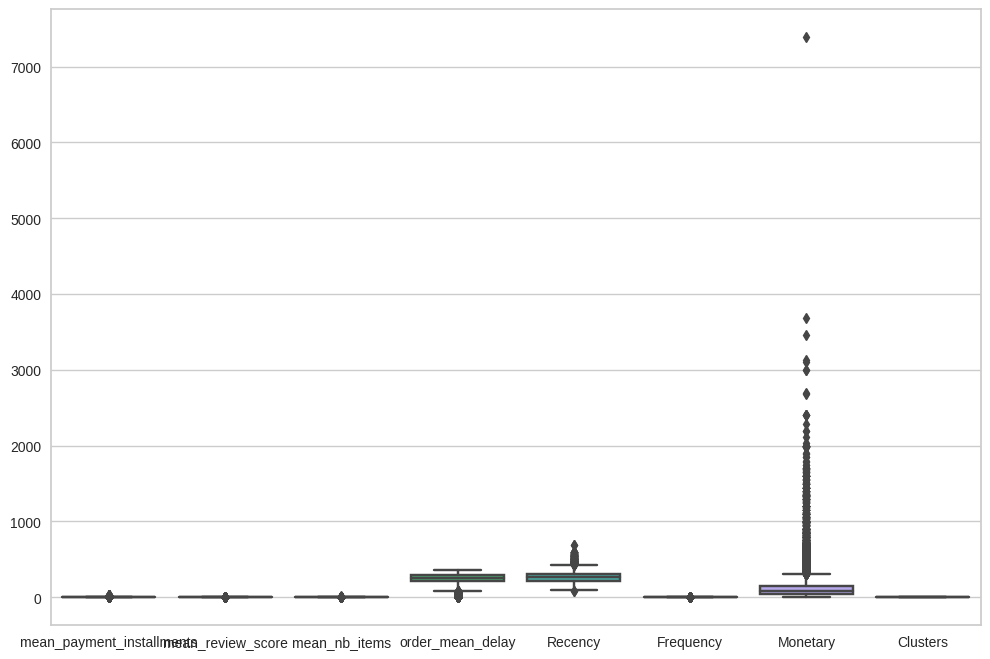

In [317]:
sns.boxplot(data = rfm_features_del_cluster_3)

In [261]:
rfm_features_del_cluster_3['Segment'].value_counts()

At Risk                  5711
About To Sleep           4241
Hibernating customers    4220
Potential Loyalist       4196
Loyal                    2547
Need Attention           2098
Promising                1785
Cannot Lose Them         1140
New Customers             808
Champions                 144
Lost customers             16
Name: Segment, dtype: int64

In [262]:
rfm_features_del.to_csv('/content/drive/MyDrive/OC: Data Science/Datasets/Projet 5/seg_rfm_features_del.csv', index=False)

# RFM & tous les features

In [263]:
data_total = data.merge(rfm, on = 'customer_unique_id', how = 'left' )
data_total

customer_unique_id  nb_orders  total_spend  \
0      0000366f3b9a7992bf8c76cfdf3221e2          1       129.90   
1      0000b849f77a49e4a4ce2b2a4ca5be3f          1        18.90   
2      0000f46a3911fa3c0805444483337064          1        69.00   
3      0000f6ccb0745a6a4b88665a16c9f078          1        25.99   
4      0004aac84e0df4da2b147fca70cf8255          1       180.00   
...                                 ...        ...          ...   
93353  fffcf5a5ff07b0908bd4e2dbc735a684          1      1570.00   
93354  fffea47cd6d3cc0a88bd621562a9d061          1        64.89   
93355  ffff371b4d645b6ecea244b27531430a          1        89.90   
93356  ffff5962728ec6157033ef9805bacc48          1       115.00   
93357  ffffd2657e2aad2907e67c3e9daecbeb          1        56.99   

       freight_value  mean_payment_installments  mean_review_score  \
0              12.00                        8.0                5.0   
1               8.29                        1.0                4.0   
2              17.22                        8.0                3.0   
3              17.63                        4.0                4.0   
4              16.89                        6.0                5.0   
...              ...                        ...                ...   
93353         497.42                       10.0                5.0   
93354          19.69                        1.0                4.0   
93355          22.56                        1.0                5.0   
93356          18.69                        5.0                5.0   
93357          14.57                        4.0                5.0   

       total_items  mean_nb_items                  min                  max  \
0              1.0            1.0  2018-05-10 10:56:27  2018-05-10 10:56:27   
1              1.0            1.0  2018-05-07 11:11:27  2018-05-07 11:11:27   
2              1.0            1.0  2017-03-10 21:05:03  2017-03-10 21:05:03   
3              1.0            1.0  2017-10-12 20:29:41  2017-10-12 20:29:41   
4              1.0            1.0  2017-11-14 19:45:42  2017-11-14 19:45:42   
...            ...            ...                  ...                  ...   
93353          2.0            2.0  2017-06-08 21:00:36  2017-06-08 21:00:36   
93354          1.0            1.0  2017-12-10 20:07:56  2017-12-10 20:07:56   
93355          1.0            1.0  2017-02-07 15:49:16  2017-02-07 15:49:16   
93356          1.0            1.0  2018-05-02 15:17:41  2018-05-02 15:17:41   
93357          1.0            1.0  2017-05-02 20:18:45  2017-05-02 20:18:45   

       order_mean_delay                       customer_id LastPurchaseDate  \
0                 111.0  fadbb3709178fc513abc1b2670aa1ad2       2018-05-10   
1                 114.0  4cb282e167ae9234755102258dd52ee8       2018-05-07   
2                 536.0  9b3932a6253894a02c1df9d19004239f       2017-03-10   
3                 320.0  914991f0c02ef0843c0e7010c819d642       2017-10-12   
4                 287.0  47227568b10f5f58a524a75507e6992c       2017-11-14   
...                 ...                               ...              ...   
93353             446.0  74be082247cd677a147d83ee670e9d53       2017-06-08   
93354             261.0  0ecf8e0a08148af0bf313184f167670a       2017-12-10   
93355             567.0  27f584b0f1dc4e610065c240f68b6be0       2017-02-07   
93356             118.0  832a3b0254347d409512ae92eaf154a6       2018-05-02   
93357             483.0  70bc4d9cf2bbeea3f7b09798370f5884       2017-05-02   

       Recency  Frequency  Monetary recency_score frequency_score  \
0          111          1    129.90             4               1   
1          114          1     18.90             4               1   
2          537          1     69.00             1               1   
3          321          1     25.99             2               1   
4          288          1    180.00             2               1   
...        ...        ...       ...           ...             ...   
93353 

In [264]:
data_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93358 entries, 0 to 93357
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   customer_unique_id         93358 non-null  object  
 1   nb_orders                  93358 non-null  int64   
 2   total_spend                93358 non-null  float64 
 3   freight_value              93358 non-null  float64 
 4   mean_payment_installments  93358 non-null  float64 
 5   mean_review_score          93358 non-null  float64 
 6   total_items                93358 non-null  float64 
 7   mean_nb_items              93358 non-null  float64 
 8   min                        93358 non-null  object  
 9   max                        93358 non-null  object  
 10  order_mean_delay           93358 non-null  float64 
 11  customer_id                93358 non-null  object  
 12  LastPurchaseDate           93358 non-null  object  
 13  Recency                    9335

In [265]:
data_total = data_total.drop(['customer_unique_id', 'min', 'max', 'customer_id', 'LastPurchaseDate', 'recency_score', 'frequency_score', 'monetary_score', 'RFM_SCORE', 'Segment'], axis= 1)

In [266]:
categorical_total = list(data_total.select_dtypes(exclude=['int64', 'float64', 'uint8']).columns)
numerical_total = list(data_total.select_dtypes(include=['int64','float64', 'uint8']).columns)
print('categorical_features  : ', categorical_total)
print("*****")
print('numerical_features: ', numerical_total)
print("*****")
len(numerical_total)

categorical_features  :  []
*****
numerical_features:  ['nb_orders', 'total_spend', 'freight_value', 'mean_payment_installments', 'mean_review_score', 'total_items', 'mean_nb_items', 'order_mean_delay', 'Recency', 'Frequency', 'Monetary']
*****


11

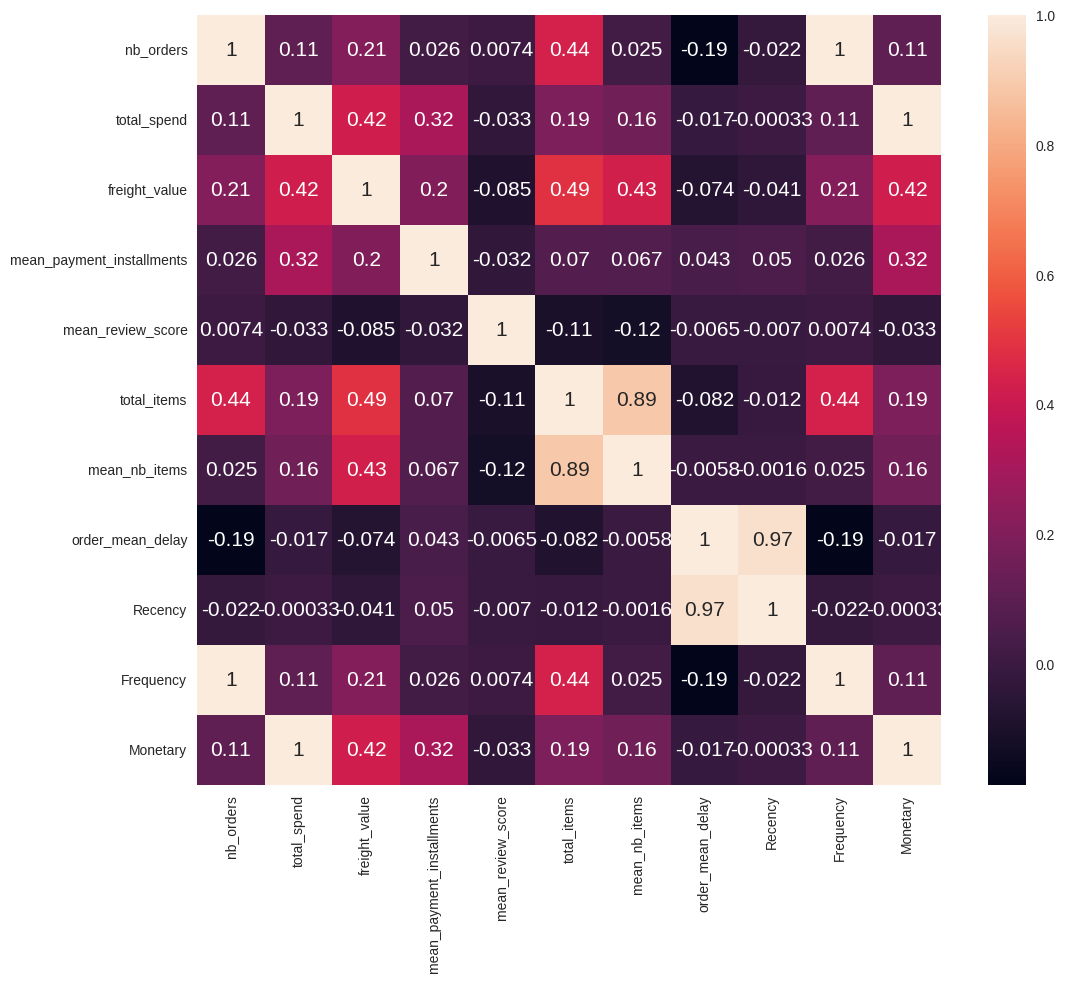

In [267]:
corr(data_total)

In [268]:
scaler = MinMaxScaler()

preprocessor = ColumnTransformer([('scaler', scaler, numerical_total)] )

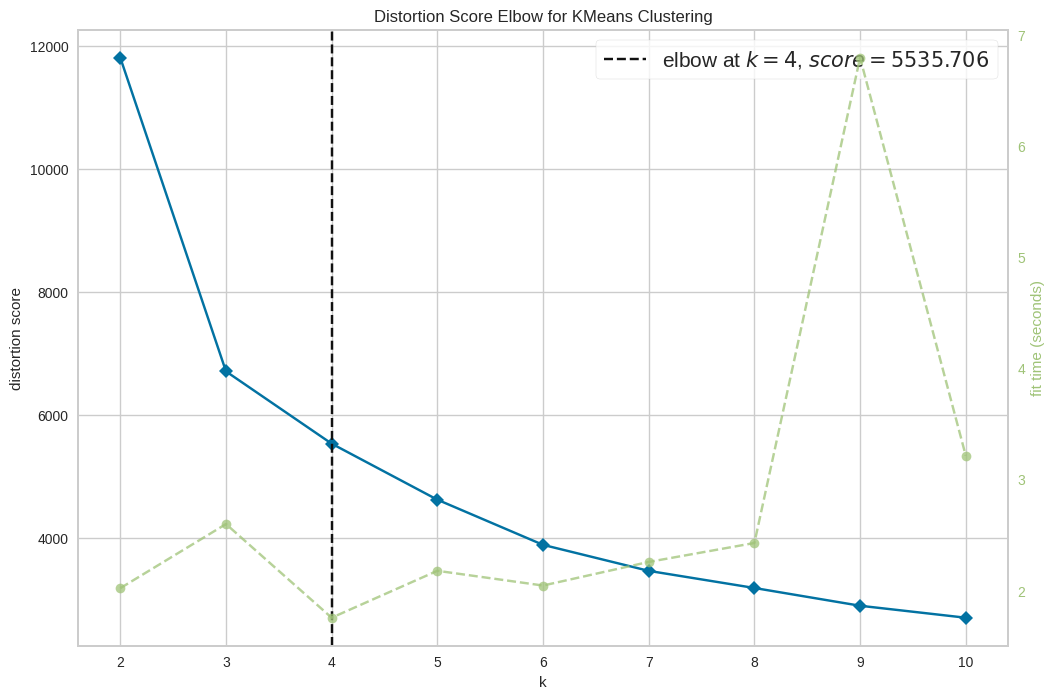

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [269]:
X = data_total.copy()
# Elbow method
kmeans_visualizer = Pipeline([("preprocessor", preprocessor),
                              ("kelbowvisualizer", KElbowVisualizer(KMeans(),
                                                                    K=(4,12)))])
kmeans_visualizer.fit(X)
kmeans_visualizer.named_steps['kelbowvisualizer'].show()

In [270]:
# KMeans Pipeline with best K
kmeans_model = Pipeline([("preprocessor", preprocessor),
                         ("kmeans", KMeans(K))])
kmeans_model.fit(X)

# Kmeans labels
kmeans_labels_features = kmeans_model.named_steps['kmeans'].labels_
data_total["Clusters"] = kmeans_labels_features

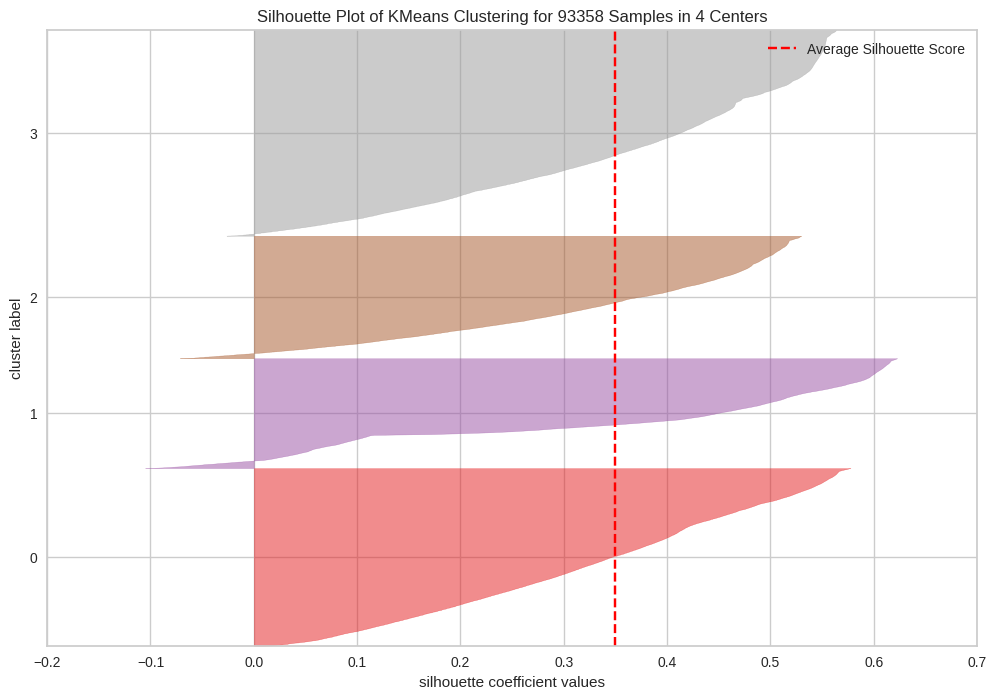

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 93358 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [271]:
K = kmeans_visualizer.named_steps['kelbowvisualizer'].elbow_value_


silhouette_visualizer = Pipeline([("preprocessor", preprocessor),
                                   ("silhouettevisualizer", 
                                    SilhouetteVisualizer(KMeans(K)))])
silhouette_visualizer.fit(X)
silhouette_visualizer.named_steps['silhouettevisualizer'].show()

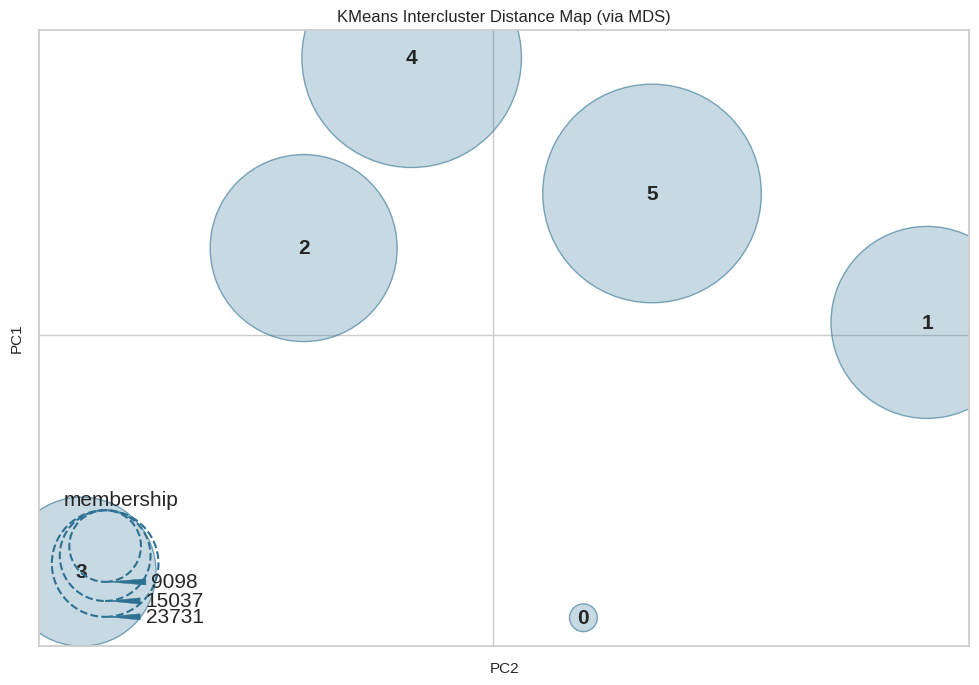

<Axes: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [272]:
distance_visualizer = Pipeline([("preprocessor", preprocessor),
                                  ("distancevisualizer",
                                   InterclusterDistance(KMeans(6)))])
distance_visualizer.fit(X)
distance_visualizer.named_steps['distancevisualizer'].show()

In [273]:
#Scoring
data_total["recency_score"]  = pd.qcut(data_total['Recency'], 5, labels=[5, 4, 3, 2, 1])
data_total["frequency_score"] = pd.qcut(data_total['Frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
data_total["monetary_score"] = pd.qcut(data_total['Monetary'], 5, labels=[1, 2, 3, 4, 5])

data_total['RFM_SCORE'] = data_total.recency_score.astype(str) + data_total.frequency_score.astype(str) + data_total.monetary_score.astype(str)

#Segmentation
data_total['Segment'] = data_total['recency_score'].astype(str) + data_total['frequency_score'].astype(str) + data_total['monetary_score'].astype(str)
data_total['Segment'] = data_total['Segment'].replace(seg_map, regex=True)
data_total.head()

nb_orders  total_spend  freight_value  mean_payment_installments  \
0          1       129.90          12.00                        8.0   
1          1        18.90           8.29                        1.0   
2          1        69.00          17.22                        8.0   
3          1        25.99          17.63                        4.0   
4          1       180.00          16.89                        6.0   

   mean_review_score  total_items  mean_nb_items  order_mean_delay  Recency  \
0                5.0          1.0            1.0             111.0      111   
1                4.0          1.0            1.0             114.0      114   
2                3.0          1.0            1.0             536.0      537   
3                4.0          1.0            1.0             320.0      321   
4                5.0          1.0            1.0             287.0      288   

   Frequency  Monetary  Clusters recency_score frequency_score monetary_score  \
0          1    129.90         2             4               1              4   
1          1     18.90         2             4               1              1   
2          1     69.00         3             1               1              2   
3          1     25.99         0             2               1              1   
4          1    180.00         0             2               1              5   

  RFM_SCORE                Segment  
0       414              Promising  
1       411          New Customers  
2       112         Lost customers  
3       211  Hibernating customers  
4       215       Cannot Lose Them

In [274]:
data_total.describe()

nb_orders   total_spend  freight_value  mean_payment_installments  \
count  93358.000000  93358.000000   93358.000000               93358.000000   
mean       1.033420    141.621480      23.546730                   2.965951   
std        0.209097    215.694014      22.780318                   2.717719   
min        1.000000      0.850000       0.000000                   0.000000   
25%        1.000000     47.650000      14.070000                   1.000000   
50%        1.000000     89.730000      17.600000                   2.000000   
75%        1.000000    154.737500      25.520000                   4.000000   
max       15.000000  13440.000000    1794.960000                  26.000000   

       mean_review_score   total_items  mean_nb_items  order_mean_delay  \
count       93358.000000  93358.000000   93358.000000      93358.000000   
mean            4.158806      1.180370       1.139531        231.940296   
std             1.278290      0.620857       0.527075        154.162700   
min             1.000000      1.000000       1.000000          0.000000   
25%             4.000000      1.000000       1.000000        107.000000   
50%             5.000000      1.000000       1.000000        212.000000   
75%             5.000000      1.000000       1.000000        341.000000   
max             5.000000     24.000000      21.000000        713.000000   

            Recency     Frequency      Monetary      Clusters  
count  93358.000000  93358.000000  93358.000000  93358.000000  
mean     237.478877      1.033420    141.621480      1.444836  
std      152.595054      0.209097    215.694014      1.106222  
min        0.000000      1.000000      0.850000      0.000000  
25%      114.000000      1.000000     47.650000      0.000000  
50%      218.000000      1.000000     89.730000      2.000000  
75%      346.000000      1.000000    154.737500      2.000000  
max      713.000000     15.000000  13440.000000      3.000000

In [275]:
data_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93358 entries, 0 to 93357
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   nb_orders                  93358 non-null  int64   
 1   total_spend                93358 non-null  float64 
 2   freight_value              93358 non-null  float64 
 3   mean_payment_installments  93358 non-null  float64 
 4   mean_review_score          93358 non-null  float64 
 5   total_items                93358 non-null  float64 
 6   mean_nb_items              93358 non-null  float64 
 7   order_mean_delay           93358 non-null  float64 
 8   Recency                    93358 non-null  int64   
 9   Frequency                  93358 non-null  int64   
 10  Monetary                   93358 non-null  float64 
 11  Clusters                   93358 non-null  int32   
 12  recency_score              93358 non-null  category
 13  frequency_score            9335

In [276]:
data_total['Clusters'].value_counts()

2    31107
0    26922
3    18672
1    16657
Name: Clusters, dtype: int64

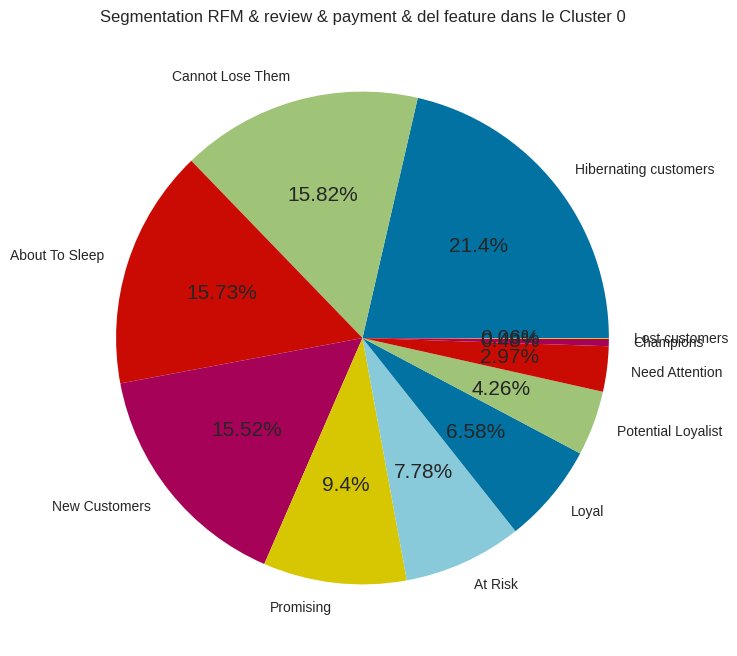

In [277]:
#Affichons les segment appartenants au cluster 0
data_total_cluster_0 = data_total[data_total['Clusters'] == 0]
data_total_cluster_0.Segment.unique()
data_total_cluster_0['Segment'].value_counts()
labels_data_total_cluster_0 = data_total_cluster_0.Segment.unique()

plt.pie(data_total_cluster_0['Segment'].value_counts(),
        labels = labels_data_total_cluster_0,
        autopct = lambda x: str(round(x, 2))
                   + '%', normalize = True)
plt.title ("Segmentation RFM & review & payment & del feature dans le Cluster 0")    
plt.show()

<Axes: >

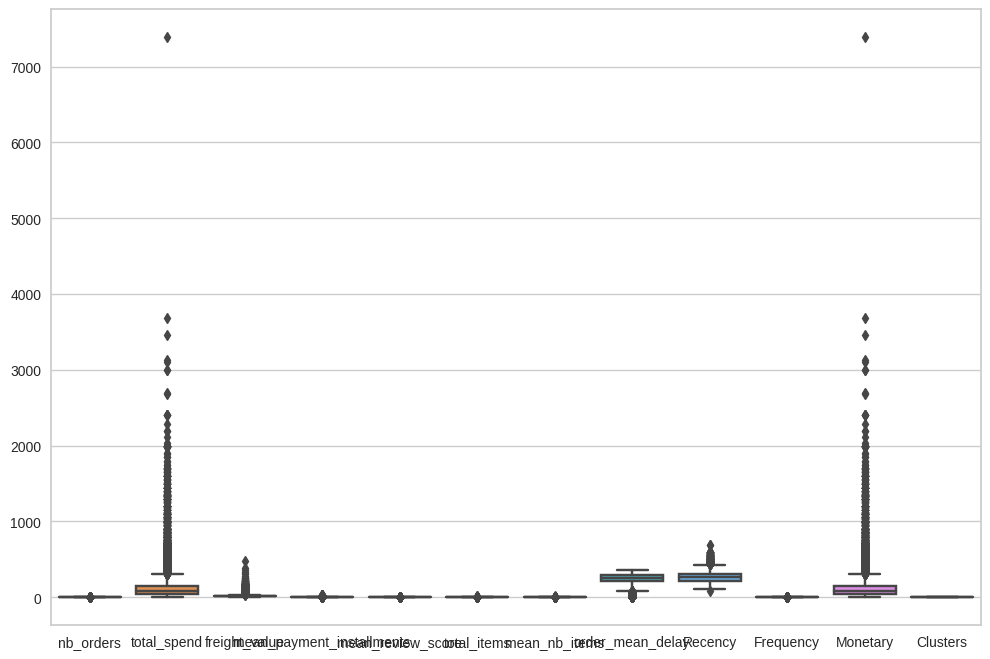

In [318]:
sns.boxplot(data = data_total_cluster_0)

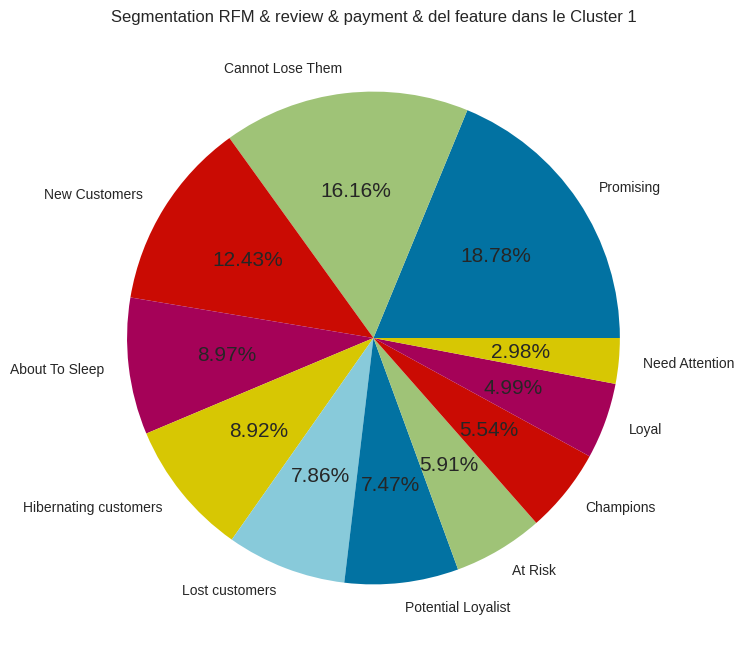

In [278]:
#Affichons les segment appartenants au cluster 1
data_total_cluster_1 = data_total[data_total['Clusters'] == 1]
data_total_cluster_1.Segment.unique()
data_total_cluster_1['Segment'].value_counts()
labels_data_total_cluster_1 = data_total_cluster_1.Segment.unique()

plt.pie(data_total_cluster_1['Segment'].value_counts(),
        labels = labels_data_total_cluster_1,
        autopct = lambda x: str(round(x, 2))
                   + '%', normalize = True)
plt.title ("Segmentation RFM & review & payment & del feature dans le Cluster 1")    
plt.show()

<Axes: >

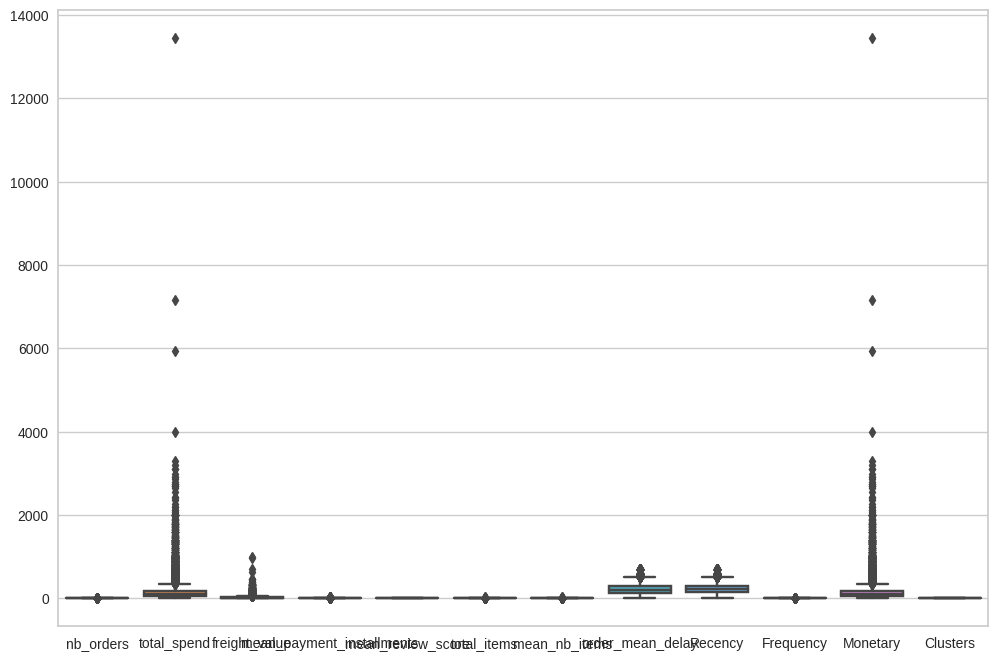

In [319]:
sns.boxplot(data = data_total_cluster_1)

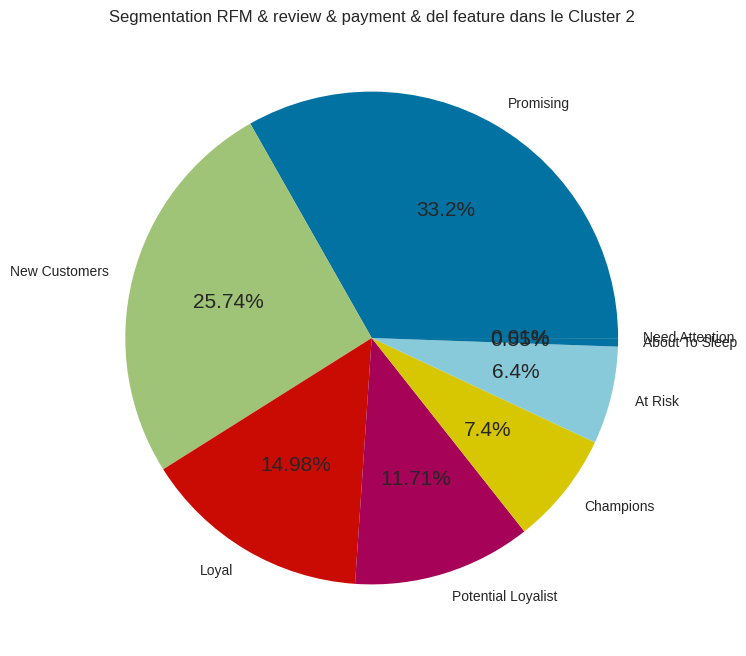

In [279]:
#Affichons les segment appartenants au cluster 2
data_total_cluster_2 = data_total[data_total['Clusters'] == 2]
data_total_cluster_2.Segment.unique()
data_total_cluster_2['Segment'].value_counts()
labels_data_total_cluster_2 = data_total_cluster_2.Segment.unique()

plt.pie(data_total_cluster_2['Segment'].value_counts(),
        labels = labels_data_total_cluster_2,
        autopct = lambda x: str(round(x, 2))
                   + '%', normalize = True)
plt.title ("Segmentation RFM & review & payment & del feature dans le Cluster 2")    
plt.show()

<Axes: >

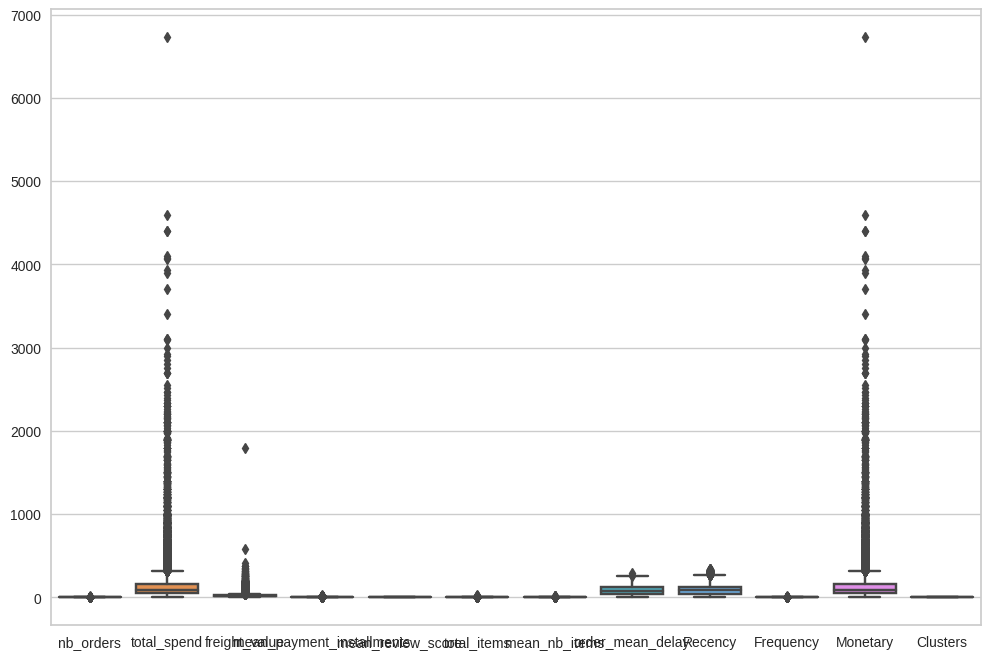

In [320]:
sns.boxplot(data = data_total_cluster_2)

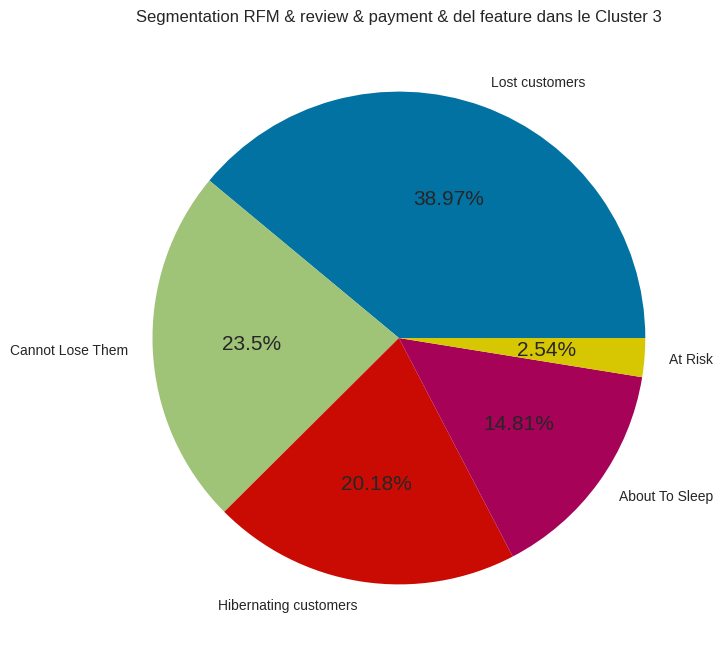

In [280]:
#Affichons les segment appartenants au cluster 3
data_total_cluster_3 = data_total[data_total['Clusters'] == 3]
data_total_cluster_3.Segment.unique()
data_total_cluster_3['Segment'].value_counts()
labels_data_total_cluster_3 = data_total_cluster_3.Segment.unique()

plt.pie(data_total_cluster_3['Segment'].value_counts(),
        labels = labels_data_total_cluster_3,
        autopct = lambda x: str(round(x, 2))
                   + '%', normalize = True)
plt.title ("Segmentation RFM & review & payment & del feature dans le Cluster 3")    
plt.show()

<Axes: >

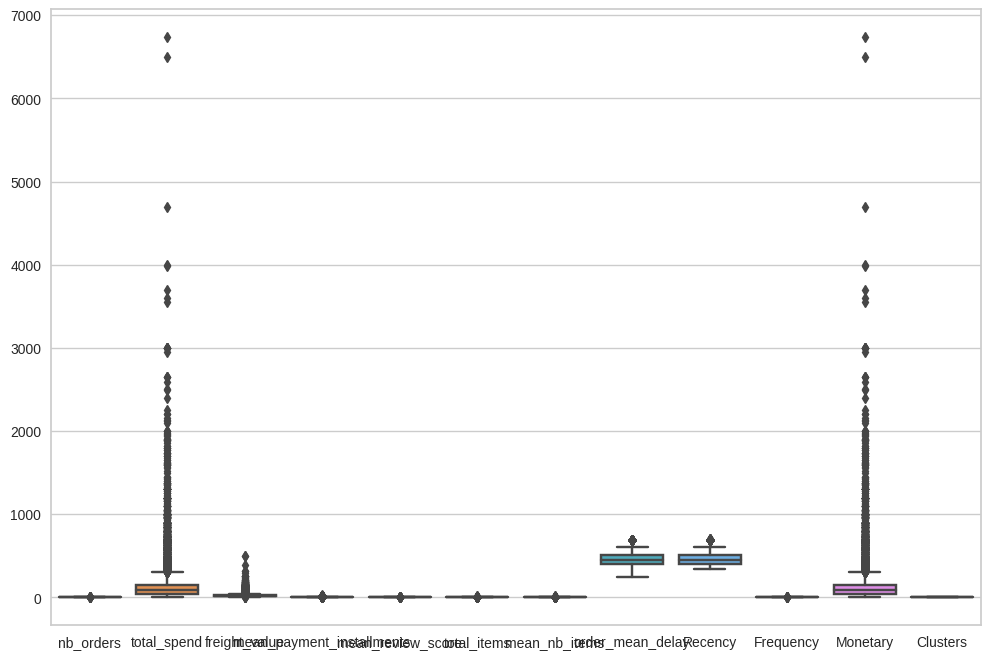

In [321]:
sns.boxplot(data = data_total_cluster_3)

In [281]:
data_total_cluster_3['Segment'].value_counts()

At Risk                  7276
Lost customers           4387
Cannot Lose Them         3768
Hibernating customers    2766
About To Sleep            475
Name: Segment, dtype: int64

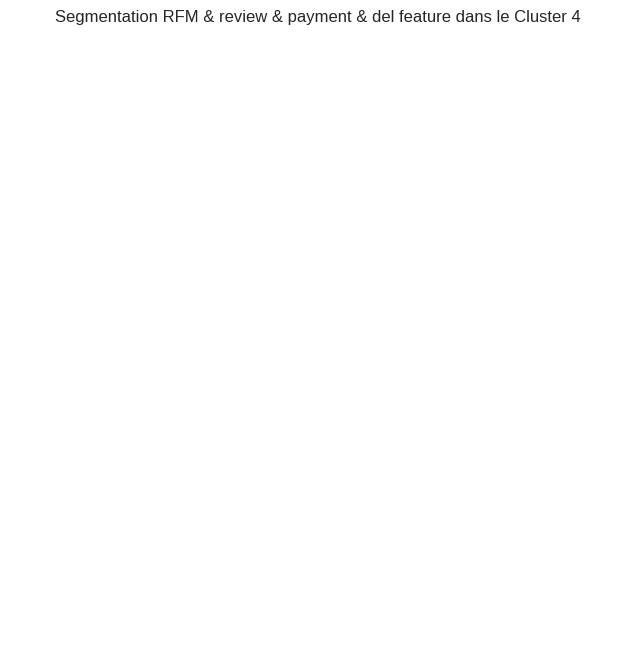

In [282]:
#Affichons les segment appartenants au cluster 4
data_total_cluster_4 = data_total[data_total['Clusters'] == 4]
data_total_cluster_4.Segment.unique()
data_total_cluster_4['Segment'].value_counts()
labels_data_total_cluster_4 = data_total_cluster_4.Segment.unique()

plt.pie(data_total_cluster_4['Segment'].value_counts(),
        labels = labels_data_total_cluster_4,
        autopct = lambda x: str(round(x, 2))
                   + '%', normalize = True)
plt.title ("Segmentation RFM & review & payment & del feature dans le Cluster 4")    
plt.show()

<Axes: >

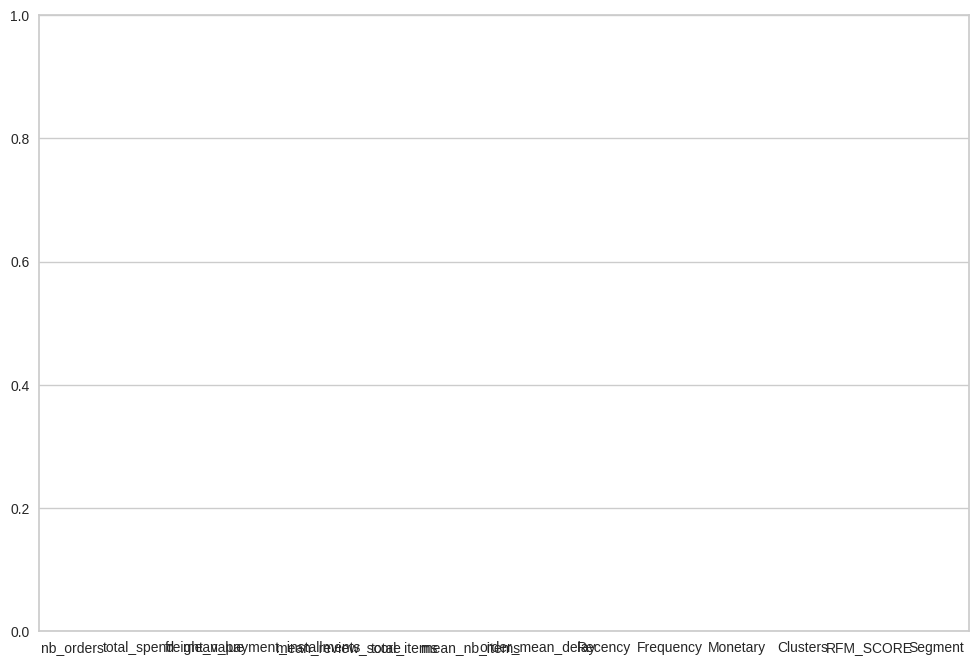

In [322]:
sns.boxplot(data = data_total_cluster_4)

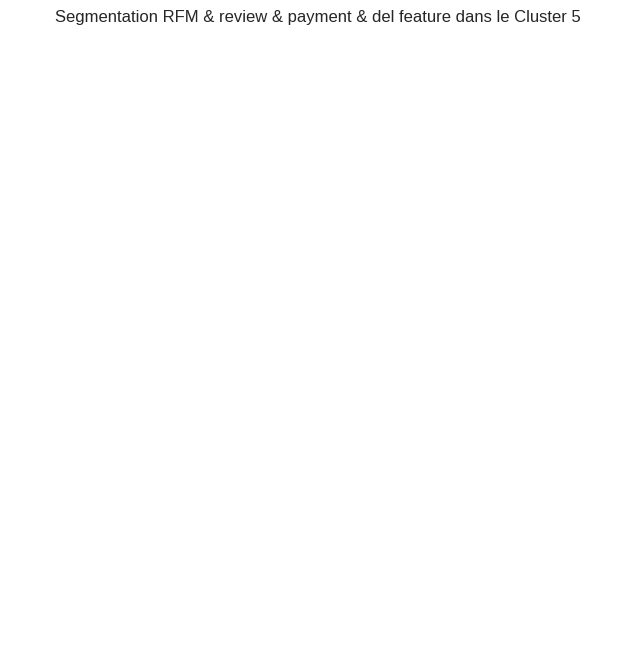

In [283]:
#Affichons les segment appartenants au cluster 5
data_total_cluster_5 = data_total[data_total['Clusters'] == 5]
data_total_cluster_5.Segment.unique()
data_total_cluster_5['Segment'].value_counts()
labels_data_total_cluster_5 = data_total_cluster_5.Segment.unique()

plt.pie(data_total_cluster_5['Segment'].value_counts(),
        labels = labels_data_total_cluster_5,
        autopct = lambda x: str(round(x, 2))
                   + '%', normalize = True)
plt.title ("Segmentation RFM & review & payment & del feature dans le Cluster 5")    
plt.show()

<Axes: >

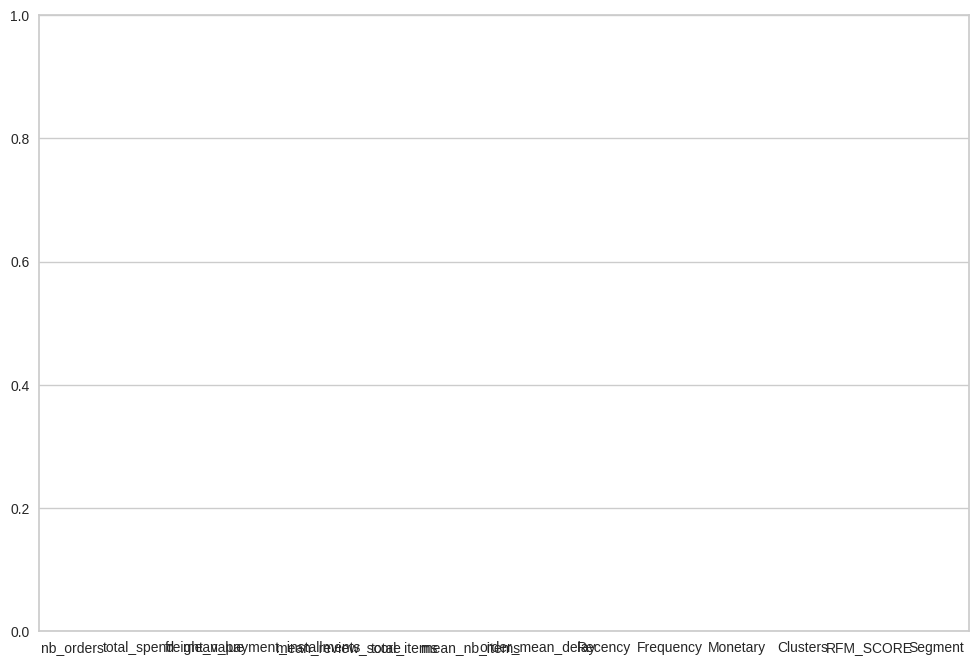

In [323]:
sns.boxplot(data = data_total_cluster_5)

Nous remarquons que la meilleure distribution est celle RFM donc nous continuons notre etude avec notre segmentation et clustering RFM


In [284]:
data_total.to_csv('/content/drive/MyDrive/OC: Data Science/Datasets/Projet 5/seg_data_total.csv', index=False)

Nous allons dans le note book suivant etudier la stabilite de notre Kmeans, ensuite la maintenance que nous pourrons proposer
